In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
import random
import os

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold

In [ ]:
import keras
from keras import utils as np_utils
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

### seed reset code

In [45]:
def reset_seed(seed):
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)

### Data load

In [49]:
def getdata_random(fn, sample=True):
    
    #negative set
    df0 = pd.read_csv('../data/random2.out', header=None, names=['seq'])
    df0['label'] = 0
    
    #positive se# Data loadt
    df1 = pd.read_csv(fn, header=None, names=['seq','cnt'])
    df1['label'] = 1
    
    if sample==True:
        df1=df1.sample(frac=1, random_state=seed_num).reset_index(drop=True)
        df0=df0.sample(frac=1, random_state=seed_num).reset_index(drop=True)
        df1.drop('cnt', axis=1, inplace=True)
        df = pd.concat([df1[:10000], df0[:10000]])
    else:
        #cnt가 3 이상인 데이터만 추출
        df1 = df1[df1.cnt>=3]
        
        # Train, Test set에 cnt값은 필요 없기 때문에 제거
        df1.drop('cnt', axis=1, inplace=True)

        # [:sample_size]
        df = pd.concat([df1[:10000], df0[:10000]])
        
    df = df.reset_index(drop=True)
    return df

### One-hot Encoding

In [47]:
def preprocessing(df):
    encoded_list = []

    def encode_seq(s):
        Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1], 'N':[0,0,0,0]}
        return [Encode[x] for x in s]

    for i in df.seq:
        x = encode_seq(i)
        encoded_list.append(x)

    X = np.array(encoded_list)
    X = X.astype('float32')
    X.shape
    
    return X

### Train, test split

In [48]:
def data_split(df,seed):
    dataX= preprocessing(df)
    dataY=df.label
    X_train,X_test,Y_train,Y_test=train_test_split(dataX,dataY,test_size=0.4,random_state=seed)

    Y_train = keras.utils.np_utils.to_categorical(Y_train)
    Y_test = keras.utils.np_utils.to_categorical(Y_test)

    return X_train,X_test,Y_train,Y_test

### Evaluation Function

In [51]:
def make_plot(name,history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [52]:
def model_evaluation(model, X_test, Y_test,verbose=0):
    test_prediction = model.predict(X_test,verbose = 0)
    prediction = np.argmax(test_prediction, axis=1)
    prediction2 = test_prediction.T[1].T
    answer = np.argmax(Y_test, axis=1)
    confusion = confusion_matrix(answer, prediction)
    
    
    acc = accuracy_score(answer, prediction)
    
    
    auc  = roc_auc_score(answer, prediction2)
    
    
    pre = precision_score(answer, prediction)
    

    recall = recall_score(answer, prediction)
    

    specificity = confusion[0,0]/(confusion[0,1]+confusion[0,0])
    

    f1 = f1_score(answer, prediction)
    
    
    
    if verbose == 1:
        print('\nTest confusion matrix :')
        print(pd.DataFrame(confusion))
        print('\nTest Accuracy score: ',acc)
        print('Test AUC score: ', auc)
        print('Test Precision score: ', pre)
        print('Test Recall score: ', recall)
        print('Test Specificity score: ', specificity)
        print('Test F1_score: ', f1,'\n')
    
    return acc , auc, pre, recall, specificity, f1, answer, prediction2

### Transformer

In [53]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim,num_heads=1):
        reset_seed(seed_num)
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads
        
        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)
        
        self.att_map = 0
    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights
    
    def get_attmap():
        return self.att_map

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, self.attention_map = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [54]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        reset_seed(seed_num)
        super(TransformerBlock, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dff = dff
        
        
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def get_config(self):
        return {'embedding_dim':self.embedding_dim,'num_heads':self.num_heads,'dff':self.dff}

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [56]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        reset_seed(seed_num)
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.position = position
        self.d_model = d_model
        
    def get_config(self):
        return {'position':self.position,'d_model':self.d_model}
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position/2 * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])

        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)/5

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [58]:
def Transformer():
    reset_seed(seed_num)
    embedding_dim = 4  # 각 단어의 임베딩 벡터의 차원
    num_heads = 4  # 어텐션 헤드의 수
    dff = 64  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
    max_len = 30
    inputs = tf.keras.layers.Input(shape=(max_len,embedding_dim))
    embedding_layer = PositionalEncoding(max_len, embedding_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
    x = transformer_block(x)
    transformer_block2 = TransformerBlock(embedding_dim, num_heads, dff)
    x = transformer_block2(x)
    transformer_block3 = TransformerBlock(embedding_dim, num_heads, dff)
    x = transformer_block3(x)
    x = tf.keras.layers.Dense(128,input_shape=(30,4), activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64,input_shape=(30,4), activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32,input_shape=(30,4), activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy','AUC'])
    
    return model

### GRU

In [60]:
def GRU_model():
    reset_seed(seed_num)
    GRU_model = Sequential([
        Bidirectional(GRU(15, return_sequences=True),input_shape=(30, 4)),
        Dropout(0.1),
        Bidirectional(GRU(10, return_sequences=True)),
        Dropout(0.1),
        Bidirectional(GRU(5, return_sequences=True)),
        Dropout(0.1),
        keras.layers.Flatten(),
        Dense(80, activation = 'relu'),
        Dropout(0.1),
        Dense(2, activation = 'softmax')    
    ])

    GRU_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy','AUC'])
    
    return GRU_model

### CNN

In [61]:
def CNN_model():
    reset_seed(seed_num)
    CNN_model = Sequential([
        Conv1D(128, 3 ,strides=1, activation='relu',input_shape=(30,4)),
        Dropout(0.1),
        Conv1D(64, 3,strides=1, activation='relu'),
        Dropout(0.1),
        Conv1D(32, 3,strides=1, activation='relu'),
        Dropout(0.1),
        Conv1D(16, 3,strides=1, activation='relu'),
        Dropout(0.1),
        Conv1D(8, 3,strides=1, activation='relu'),
        Dropout(0.1),
        keras.layers.Flatten(),
        Dense(2, activation = 'softmax')
    ])
    CNN_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy','AUC'])
    return CNN_model

### Model train

In [62]:
def mlp_train(data, df,epoch,r,seed):
    call_back = tf.keras.callbacks.ModelCheckpoint(
                f'R{r}_mlp_{seed}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch', options=None
                )
    mlp_model = MLP_model()
    history = mlp_model.fit(data[0], data[1], batch_size = 1024, 
                                        epochs=epoch, validation_data=(data[2],data[3]), 
                                        shuffle=True,callbacks=[call_back],
                                        verbose = 0)
    make_plot('mlp',history)
    best_model = tf.keras.models.load_model(f'R{r}_mlp_{seed}.h5')
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[4],data[5],verbose = 1)
    df.loc[len(df)] = ['mlp',r,0 , acc , auc, pre, recall, f1]
    
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[6],data[5],verbose = 1)
    df.loc[len(df)] = ['mlp',r,1,acc , auc, pre, recall, f1]
    
    
    return best_model, df, answer, pred


In [63]:
def cnn_train(data, df,epoch,r,seed):
    call_back = tf.keras.callbacks.ModelCheckpoint(
                f'R{r}_cnn_{seed}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch', options=None
                )
    cnn_model = CNN_model()
    history = cnn_model.fit(data[0], data[1], batch_size = 1024, 
                                        epochs=epoch, validation_data=(data[2],data[3]), 
                                        shuffle=True,callbacks=[call_back],
                                        verbose = 0)
    make_plot('cnn',history)
    best_model = tf.keras.models.load_model(f'R{r}_cnn_{seed}.h5')
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[4],data[5],verbose = 1)
    df.loc[len(df)] = ['cnn',r,0 , acc , auc, pre, recall, f1]
    
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[6],data[5],verbose = 1)
    df.loc[len(df)] = ['cnn',r,1,acc , auc, pre, recall, f1]
    
    
    return best_model, df, answer, pred


In [64]:
def gru_train(data, df,epoch,r,seed):
    call_back = tf.keras.callbacks.ModelCheckpoint(
                f'R{r}_gru_{seed}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch', options=None
                )
    gru_model = GRU_model()
    history = gru_model.fit(data[0], data[1], batch_size = 1024, 
                                        epochs=epoch, validation_data=(data[2],data[3]), 
                                        shuffle=True,callbacks=[call_back],
                                        verbose = 0)
    make_plot('gru',history)
    best_model = tf.keras.models.load_model(f'R{r}_gru_{seed}.h5')
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[4],data[5],verbose = 1)
    df.loc[len(df)] = ['gru',r,0 , acc , auc, pre, recall, f1]
    
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[6],data[5],verbose = 1)
    df.loc[len(df)] = ['gru',r,1,acc , auc, pre, recall, f1]
    
    
    return best_model, df, answer, pred


In [65]:
class SeedCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_seed):
        super(SeedCallback, self).__init__()
        self.initial_seed = initial_seed

    def on_epoch_begin(self, epoch, logs=None):
        global epoch_seed
        epoch_seed = self.initial_seed + epoch
        tf.random.set_seed(epoch_seed)

In [66]:
def transformer_train(data, df,epoch,r,seed):
#     seed_callback = SeedCallback(itr)
    
    call_back = tf.keras.callbacks.ModelCheckpoint(
                f'R{r}_transformer_{seed}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch', options=None
                )
    Transformer_model = Transformer()
    history = Transformer_model.fit(data[0], data[1], batch_size = 1024, 
                                        epochs=epoch, validation_data=(data[2],data[3]), 
                                        shuffle=True,callbacks=[call_back],
                                        verbose = 0)
    make_plot('transformer',history)
    best_model = tf.keras.models.load_model(f'R{r}_transformer_{seed}.h5',custom_objects={'PositionalEncoding':PositionalEncoding,'TransformerBlock':TransformerBlock})
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[4],data[5],verbose = 1)
    df.loc[len(df)] = ['transformer',r,0, acc , auc, pre, recall, f1]
    
    acc , auc, pre, recall, specificity, f1,answer,pred = model_evaluation(best_model, data[6],data[5],verbose = 1)
    df.loc[len(df)] = ['transformer',r,1, acc , auc, pre, recall, f1]
    
    
    
    return best_model, df, answer, pred


### Results

2023-07-19 09:01:45.737588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:01:45.740619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:01:45.740832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 09:01:45.741203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

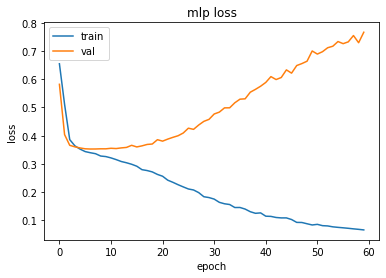

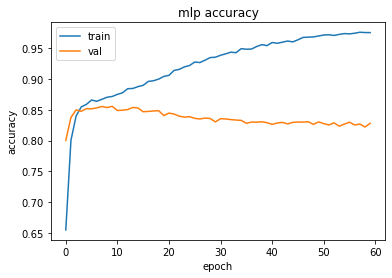


Test confusion matrix :
      0     1
0  1732   268
1   281  1719

Test Accuracy score:  0.86275
Test AUC score:  0.9299884999999999
Test Precision score:  0.8651233014594867
Test Recall score:  0.8595
Test Specificity score:  0.866
Test F1_score:  0.8623024830699775 


Test confusion matrix :
      0     1
0  1727   273
1   405  1595

Test Accuracy score:  0.8305
Test AUC score:  0.9087231250000001
Test Precision score:  0.8538543897216274
Test Recall score:  0.7975
Test Specificity score:  0.8635
Test F1_score:  0.8247156153050673 



2023-07-19 09:01:56.521153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


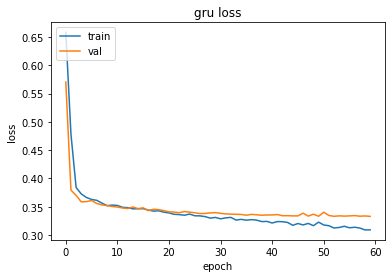

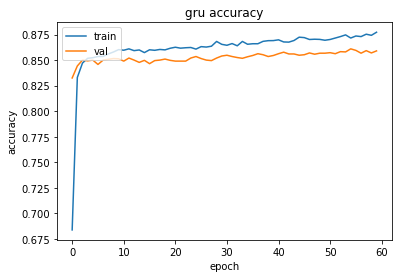


Test confusion matrix :
      0     1
0  1710   290
1   222  1778

Test Accuracy score:  0.872
Test AUC score:  0.934715875
Test Precision score:  0.8597678916827853
Test Recall score:  0.889
Test Specificity score:  0.855
Test F1_score:  0.8741396263520158 


Test confusion matrix :
      0     1
0  1706   294
1   371  1629

Test Accuracy score:  0.83375
Test AUC score:  0.9105272499999999
Test Precision score:  0.8471138845553822
Test Recall score:  0.8145
Test Specificity score:  0.853
Test F1_score:  0.8304868722916136 



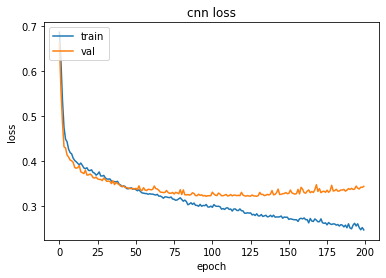

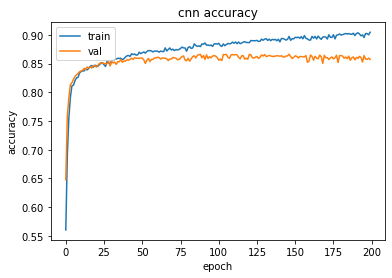


Test confusion matrix :
      0     1
0  1708   292
1   214  1786

Test Accuracy score:  0.8735
Test AUC score:  0.937495
Test Precision score:  0.8594802694898941
Test Recall score:  0.893
Test Specificity score:  0.854
Test F1_score:  0.87591956841589 


Test confusion matrix :
      0     1
0  1724   276
1   512  1488

Test Accuracy score:  0.803
Test AUC score:  0.888128
Test Precision score:  0.8435374149659864
Test Recall score:  0.744
Test Specificity score:  0.862
Test F1_score:  0.7906482465462273 



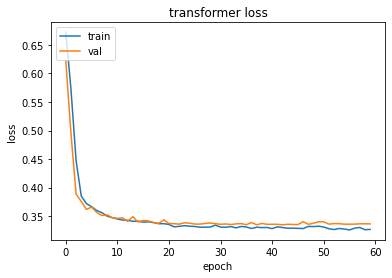

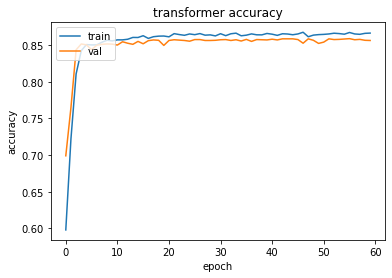


Test confusion matrix :
      0     1
0  1703   297
1   224  1776

Test Accuracy score:  0.86975
Test AUC score:  0.9346365000000001
Test Precision score:  0.8567293777134588
Test Recall score:  0.888
Test Specificity score:  0.8515
Test F1_score:  0.8720844586300026 


Test confusion matrix :
      0     1
0  1698   302
1   319  1681

Test Accuracy score:  0.84475
Test AUC score:  0.914564875
Test Precision score:  0.8477054967221381
Test Recall score:  0.8405
Test Specificity score:  0.849
Test F1_score:  0.8440873713281446 



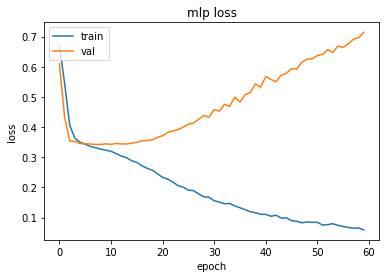

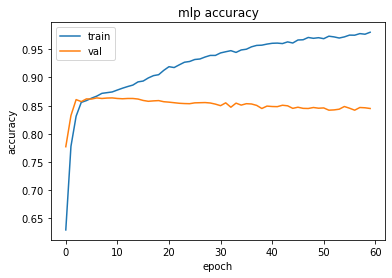


Test confusion matrix :
      0     1
0  1636   330
1   253  1781

Test Accuracy score:  0.85425
Test AUC score:  0.9190012163515255
Test Precision score:  0.8436759829464708
Test Recall score:  0.8756145526057031
Test Specificity score:  0.832146490335707
Test F1_score:  0.8593486127864897 


Test confusion matrix :
      0     1
0  1630   336
1   378  1656

Test Accuracy score:  0.8215
Test AUC score:  0.8966442551897498
Test Precision score:  0.8313253012048193
Test Recall score:  0.8141592920353983
Test Specificity score:  0.8290946083418108
Test F1_score:  0.8226527570789867 



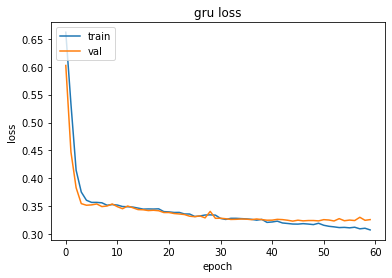

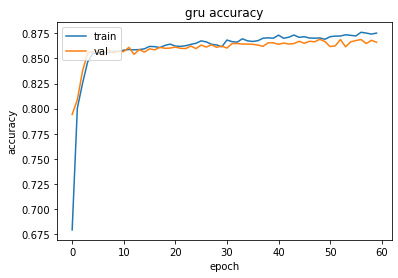


Test confusion matrix :
      0     1
0  1622   344
1   233  1801

Test Accuracy score:  0.85575
Test AUC score:  0.9250144541772571
Test Precision score:  0.8396270396270397
Test Recall score:  0.8854473942969519
Test Specificity score:  0.8250254323499492
Test F1_score:  0.8619286910744197 


Test confusion matrix :
      0     1
0  1632   334
1   356  1678

Test Accuracy score:  0.8275
Test AUC score:  0.9011011682376207
Test Precision score:  0.8339960238568589
Test Recall score:  0.8249754178957719
Test Specificity score:  0.8301119023397762
Test F1_score:  0.8294611962432032 



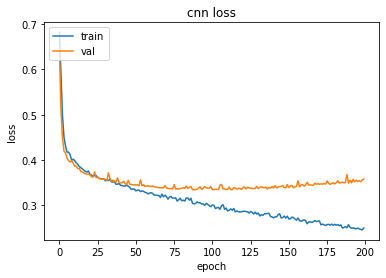

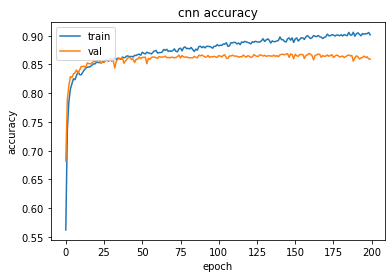


Test confusion matrix :
      0     1
0  1683   283
1   251  1783

Test Accuracy score:  0.8665
Test AUC score:  0.9289923537902454
Test Precision score:  0.8630203291384317
Test Recall score:  0.8765978367748279
Test Specificity score:  0.8560528992878942
Test F1_score:  0.8697560975609756 


Test confusion matrix :
      0     1
0  1685   281
1   577  1457

Test Accuracy score:  0.7855
Test AUC score:  0.8786199211572144
Test Precision score:  0.8383199079401611
Test Recall score:  0.716322517207473
Test Specificity score:  0.8570701932858596
Test F1_score:  0.7725344644750796 



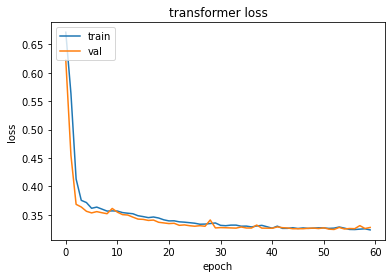

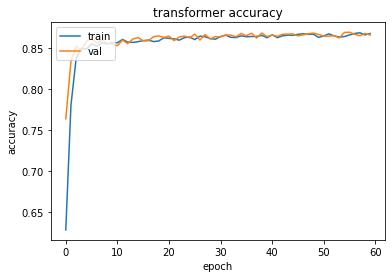


Test confusion matrix :
      0     1
0  1632   334
1   248  1786

Test Accuracy score:  0.8545
Test AUC score:  0.9244449145803136
Test Precision score:  0.8424528301886792
Test Recall score:  0.8780727630285152
Test Specificity score:  0.8301119023397762
Test F1_score:  0.8598940779971113 


Test confusion matrix :
      0     1
0  1641   325
1   356  1678

Test Accuracy score:  0.82975
Test AUC score:  0.9051315830274949
Test Precision score:  0.8377433849226161
Test Recall score:  0.8249754178957719
Test Specificity score:  0.8346897253306206
Test F1_score:  0.8313103789943027 



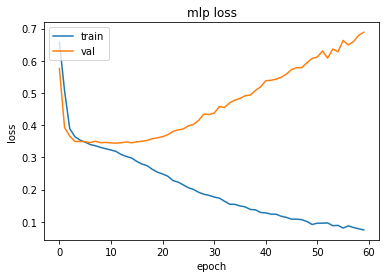

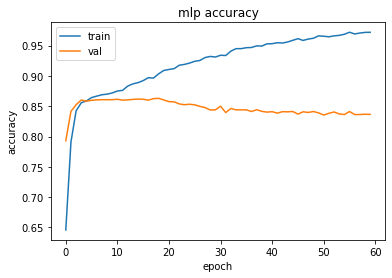


Test confusion matrix :
      0     1
0  1749   284
1   273  1694

Test Accuracy score:  0.86075
Test AUC score:  0.9274088620626967
Test Precision score:  0.8564206268958544
Test Recall score:  0.8612099644128114
Test Specificity score:  0.8603049680275455
Test F1_score:  0.858808618504436 


Test confusion matrix :
      0     1
0  1759   274
1   408  1559

Test Accuracy score:  0.8295
Test AUC score:  0.9083746800066318
Test Precision score:  0.8505182760501909
Test Recall score:  0.7925775292323335
Test Specificity score:  0.8652238071815052
Test F1_score:  0.8205263157894737 



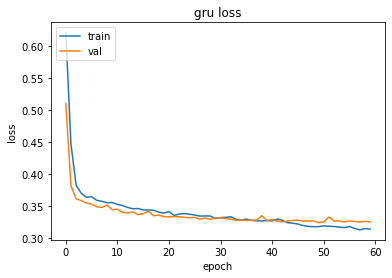

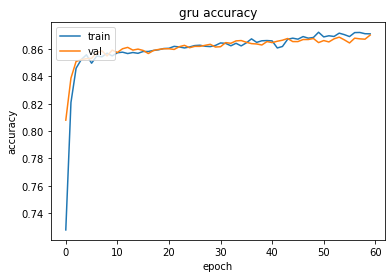


Test confusion matrix :
      0     1
0  1734   299
1   244  1723

Test Accuracy score:  0.86425
Test AUC score:  0.9329181119559802
Test Precision score:  0.8521266073194856
Test Recall score:  0.8759532282663955
Test Specificity score:  0.852926709296606
Test F1_score:  0.8638756580596642 


Test confusion matrix :
      0     1
0  1747   286
1   372  1595

Test Accuracy score:  0.8355
Test AUC score:  0.9114635209435769
Test Precision score:  0.847953216374269
Test Recall score:  0.8108795119471276
Test Specificity score:  0.8593212001967536
Test F1_score:  0.829002079002079 



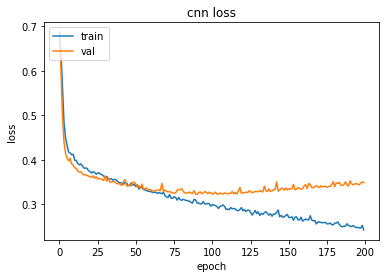

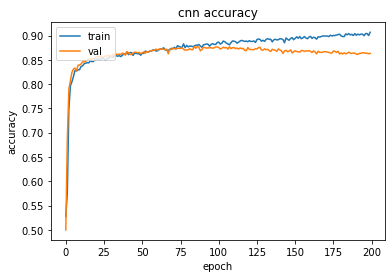


Test confusion matrix :
      0     1
0  1757   276
1   244  1723

Test Accuracy score:  0.87
Test AUC score:  0.9394806486065832
Test Precision score:  0.8619309654827414
Test Recall score:  0.8759532282663955
Test Specificity score:  0.8642400393507133
Test F1_score:  0.8688855269793243 


Test confusion matrix :
      0     1
0  1766   267
1   515  1452

Test Accuracy score:  0.8045
Test AUC score:  0.8929731119297228
Test Precision score:  0.8446771378708552
Test Recall score:  0.7381799694966955
Test Specificity score:  0.8686669945892769
Test F1_score:  0.7878459034183398 



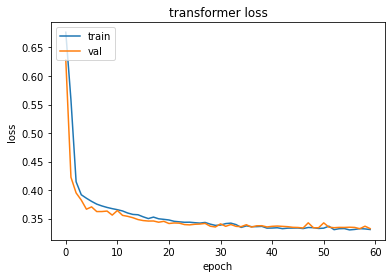

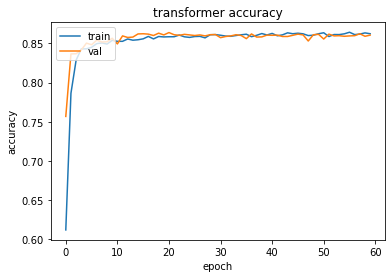


Test confusion matrix :
      0     1
0  1716   317
1   233  1734

Test Accuracy score:  0.8625
Test AUC score:  0.9309578282687462
Test Precision score:  0.8454412481716236
Test Recall score:  0.8815455007625826
Test Specificity score:  0.8440727988194786
Test F1_score:  0.8631159780985564 


Test confusion matrix :
      0     1
0  1727   306
1   336  1631

Test Accuracy score:  0.8395
Test AUC score:  0.9105598999327567
Test Precision score:  0.8420237480640165
Test Recall score:  0.8291814946619217
Test Specificity score:  0.8494835218888342
Test F1_score:  0.8355532786885246 



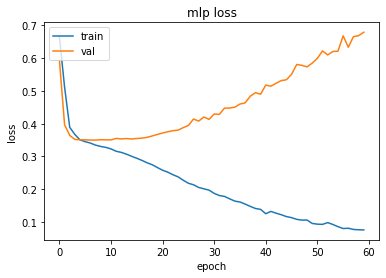

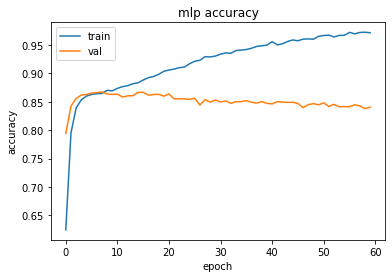


Test confusion matrix :
      0     1
0  1683   307
1   259  1751

Test Accuracy score:  0.8585
Test AUC score:  0.9285188379709493
Test Precision score:  0.8508260447035957
Test Recall score:  0.8711442786069652
Test Specificity score:  0.8457286432160804
Test F1_score:  0.86086529006883 


Test confusion matrix :
      0     1
0  1688   302
1   338  1672

Test Accuracy score:  0.84
Test AUC score:  0.9121644291107277
Test Precision score:  0.8470111448834853
Test Recall score:  0.8318407960199005
Test Specificity score:  0.8482412060301507
Test F1_score:  0.8393574297188754 



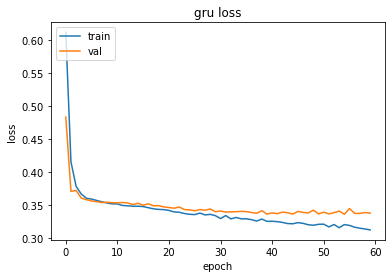

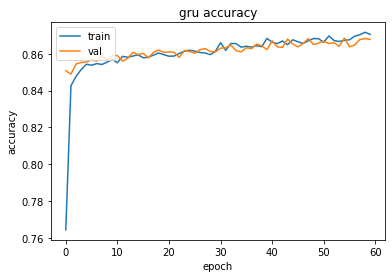


Test confusion matrix :
      0     1
0  1677   313
1   214  1796

Test Accuracy score:  0.86825
Test AUC score:  0.9380073251831296
Test Precision score:  0.8515884305357989
Test Recall score:  0.8935323383084577
Test Specificity score:  0.8427135678391959
Test F1_score:  0.8720563243505705 


Test confusion matrix :
      0     1
0  1683   307
1   337  1673

Test Accuracy score:  0.839
Test AUC score:  0.913105702642566
Test Precision score:  0.8449494949494949
Test Recall score:  0.8323383084577114
Test Specificity score:  0.8457286432160804
Test F1_score:  0.8385964912280701 



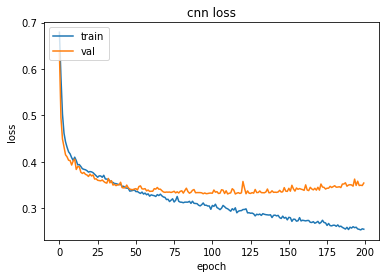

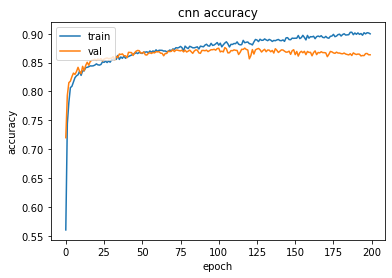


Test confusion matrix :
      0     1
0  1704   286
1   208  1802

Test Accuracy score:  0.8765
Test AUC score:  0.9405911397784944
Test Precision score:  0.8630268199233716
Test Recall score:  0.8965174129353234
Test Specificity score:  0.8562814070351759
Test F1_score:  0.879453391898487 


Test confusion matrix :
      0     1
0  1683   307
1   472  1538

Test Accuracy score:  0.80525
Test AUC score:  0.8888465961649042
Test Precision score:  0.8336043360433605
Test Recall score:  0.7651741293532338
Test Specificity score:  0.8457286432160804
Test F1_score:  0.7979247730220492 



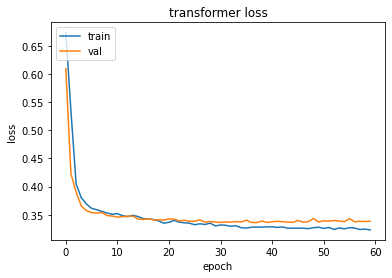

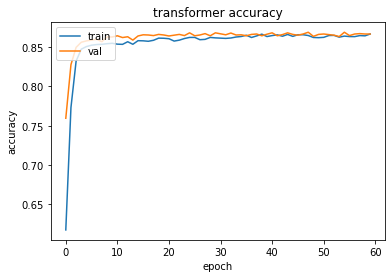


Test confusion matrix :
      0     1
0  1672   318
1   229  1781

Test Accuracy score:  0.86325
Test AUC score:  0.9347362434060853
Test Precision score:  0.8484992853739877
Test Recall score:  0.8860696517412935
Test Specificity score:  0.8402010050251256
Test F1_score:  0.8668775857872961 


Test confusion matrix :
      0     1
0  1669   321
1   302  1708

Test Accuracy score:  0.84425
Test AUC score:  0.9155581389534739
Test Precision score:  0.8417939871858058
Test Recall score:  0.8497512437810946
Test Specificity score:  0.8386934673366834
Test F1_score:  0.8457538994800693 



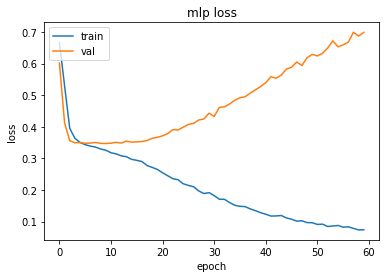

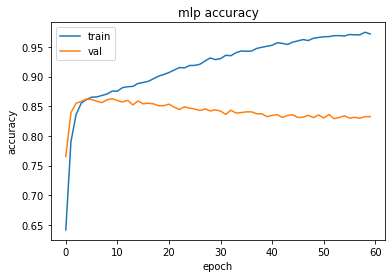


Test confusion matrix :
      0     1
0  1674   309
1   271  1746

Test Accuracy score:  0.855
Test AUC score:  0.924191772855589
Test Precision score:  0.8496350364963504
Test Recall score:  0.8656420426375806
Test Specificity score:  0.8441754916792739
Test F1_score:  0.8575638506876229 


Test confusion matrix :
      0     1
0  1678   305
1   393  1624

Test Accuracy score:  0.8255
Test AUC score:  0.9026254646898239
Test Precision score:  0.8418869880767237
Test Recall score:  0.8051561725334655
Test Specificity score:  0.8461926374180535
Test F1_score:  0.8231120121642169 



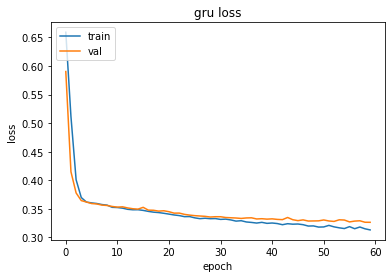

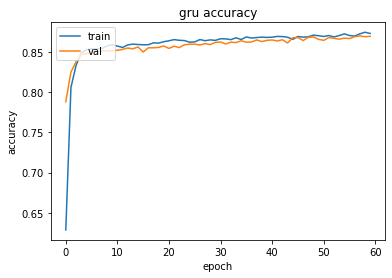


Test confusion matrix :
      0     1
0  1661   322
1   232  1785

Test Accuracy score:  0.8615
Test AUC score:  0.9312242809542989
Test Precision score:  0.8471760797342193
Test Recall score:  0.8849776896380763
Test Specificity score:  0.83761976802824
Test F1_score:  0.8656644034917556 


Test confusion matrix :
      0     1
0  1680   303
1   347  1670

Test Accuracy score:  0.8375
Test AUC score:  0.905175523931604
Test Precision score:  0.8464267612772428
Test Recall score:  0.82796232027764
Test Specificity score:  0.8472012102874432
Test F1_score:  0.8370927318295739 



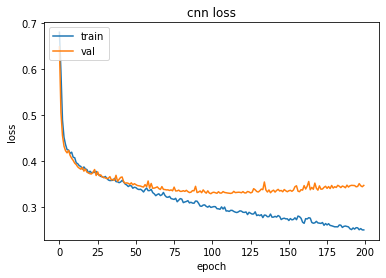

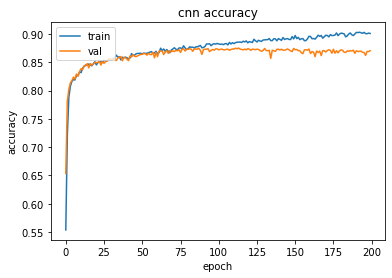


Test confusion matrix :
      0     1
0  1703   280
1   234  1783

Test Accuracy score:  0.8715
Test AUC score:  0.9365911687119394
Test Precision score:  0.8642753271934076
Test Recall score:  0.8839861179970253
Test Specificity score:  0.8587997982854261
Test F1_score:  0.8740196078431373 


Test confusion matrix :
      0     1
0  1705   278
1   537  1480

Test Accuracy score:  0.79625
Test AUC score:  0.8826787735413884
Test Precision score:  0.8418657565415245
Test Recall score:  0.7337630143777888
Test Specificity score:  0.8598083711548159
Test F1_score:  0.7841059602649006 



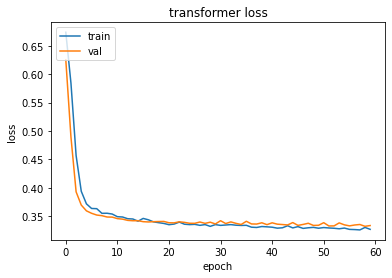

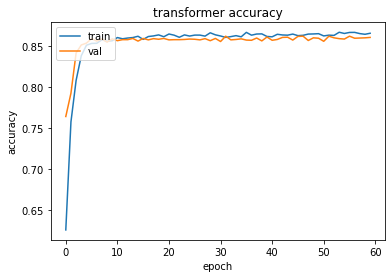


Test confusion matrix :
      0     1
0  1636   347
1   221  1796

Test Accuracy score:  0.858
Test AUC score:  0.927195989910271
Test Precision score:  0.8380774615025665
Test Recall score:  0.8904313336638572
Test Specificity score:  0.8250126071608673
Test F1_score:  0.8634615384615384 


Test confusion matrix :
      0     1
0  1645   338
1   305  1712

Test Accuracy score:  0.83925
Test AUC score:  0.9056706847069701
Test Precision score:  0.8351219512195122
Test Recall score:  0.8487853247397125
Test Specificity score:  0.8295511850731215
Test F1_score:  0.8418982050651587 



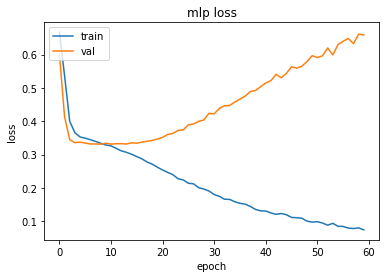

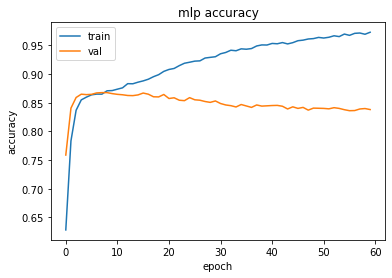


Test confusion matrix :
      0     1
0  1702   307
1   241  1750

Test Accuracy score:  0.863
Test AUC score:  0.9258573736118156
Test Precision score:  0.8507535245503159
Test Recall score:  0.8789552988448016
Test Specificity score:  0.8471876555500248
Test F1_score:  0.8646245059288538 


Test confusion matrix :
      0     1
0  1684   325
1   372  1619

Test Accuracy score:  0.82575
Test AUC score:  0.9010976222268501
Test Precision score:  0.8328189300411523
Test Recall score:  0.8131592164741336
Test Specificity score:  0.8382279741164759
Test F1_score:  0.8228716645489199 



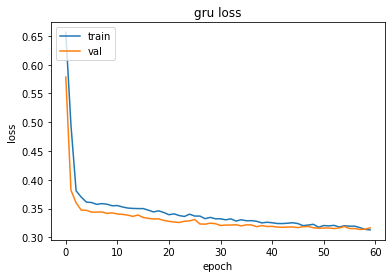

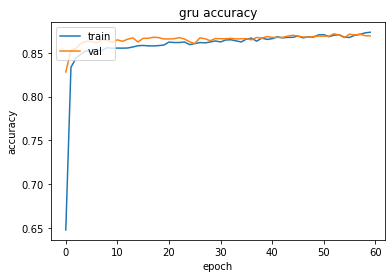


Test confusion matrix :
      0     1
0  1699   310
1   224  1767

Test Accuracy score:  0.8665
Test AUC score:  0.9318759954889086
Test Precision score:  0.8507462686567164
Test Recall score:  0.8874937217478654
Test Specificity score:  0.8456943753111
Test F1_score:  0.8687315634218289 


Test confusion matrix :
      0     1
0  1690   319
1   373  1618

Test Accuracy score:  0.827
Test AUC score:  0.9046294437462359
Test Precision score:  0.8353123386680433
Test Recall score:  0.8126569563033651
Test Specificity score:  0.8412145345943255
Test F1_score:  0.8238289205702647 



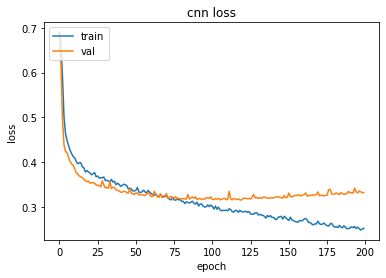

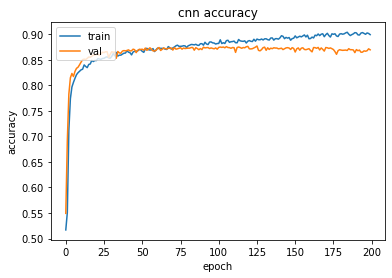


Test confusion matrix :
      0     1
0  1711   298
1   211  1780

Test Accuracy score:  0.87275
Test AUC score:  0.9367758447108554
Test Precision score:  0.8565928777670837
Test Recall score:  0.8940231039678553
Test Specificity score:  0.8516674962667994
Test F1_score:  0.8749078397640698 


Test confusion matrix :
      0     1
0  1681   328
1   537  1454

Test Accuracy score:  0.78375
Test AUC score:  0.8722655383771523
Test Precision score:  0.8159371492704826
Test Recall score:  0.730286288297338
Test Specificity score:  0.8367346938775511
Test F1_score:  0.7707394646170156 



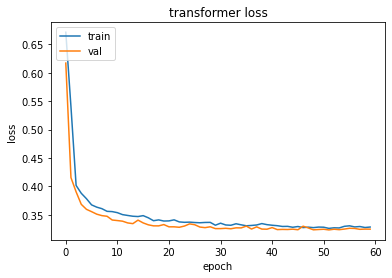

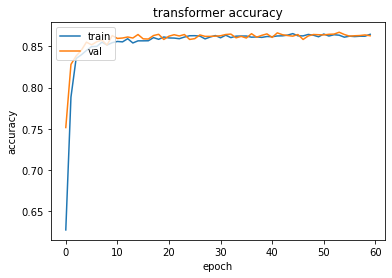


Test confusion matrix :
      0     1
0  1674   335
1   207  1784

Test Accuracy score:  0.8645
Test AUC score:  0.9296589505937495
Test Precision score:  0.8419065596979708
Test Recall score:  0.8960321446509292
Test Specificity score:  0.8332503733200597
Test F1_score:  0.8681265206812653 


Test confusion matrix :
      0     1
0  1674   335
1   315  1676

Test Accuracy score:  0.8375
Test AUC score:  0.9070196171472472
Test Precision score:  0.8334162108403779
Test Recall score:  0.8417880462079357
Test Specificity score:  0.8332503733200597
Test F1_score:  0.8375812093953022 



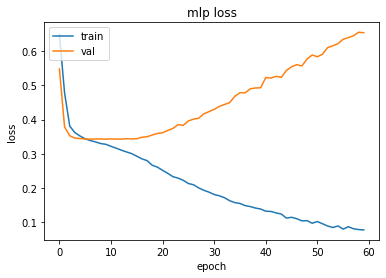

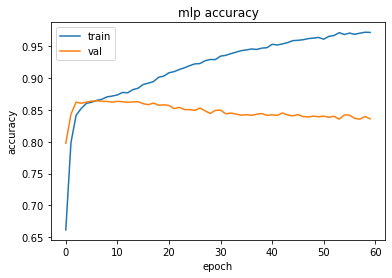


Test confusion matrix :
      0     1
0  1685   315
1   246  1754

Test Accuracy score:  0.85975
Test AUC score:  0.924651375
Test Precision score:  0.8477525374577091
Test Recall score:  0.877
Test Specificity score:  0.8425
Test F1_score:  0.8621282870484148 


Test confusion matrix :
      0     1
0  1674   326
1   353  1647

Test Accuracy score:  0.83025
Test AUC score:  0.903000375
Test Precision score:  0.8347693867207299
Test Recall score:  0.8235
Test Specificity score:  0.837
Test F1_score:  0.8290964007047571 



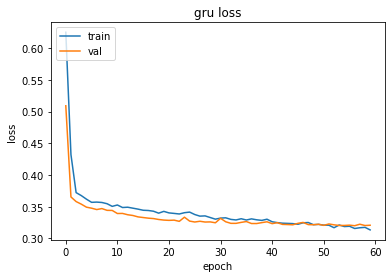

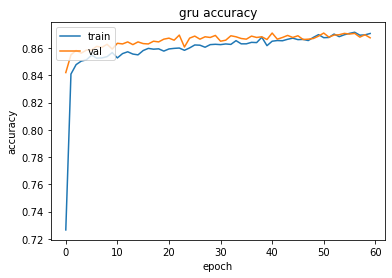


Test confusion matrix :
      0     1
0  1685   315
1   222  1778

Test Accuracy score:  0.86575
Test AUC score:  0.932623
Test Precision score:  0.8494983277591973
Test Recall score:  0.889
Test Specificity score:  0.8425
Test F1_score:  0.8688003909113119 


Test confusion matrix :
      0     1
0  1684   316
1   357  1643

Test Accuracy score:  0.83175
Test AUC score:  0.9033551249999999
Test Precision score:  0.8386932108218479
Test Recall score:  0.8215
Test Specificity score:  0.842
Test F1_score:  0.830007577671129 



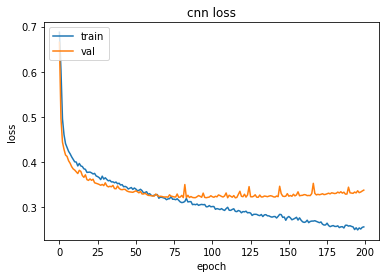

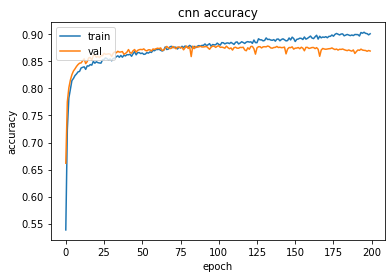


Test confusion matrix :
      0     1
0  1708   292
1   232  1768

Test Accuracy score:  0.869
Test AUC score:  0.93606925
Test Precision score:  0.858252427184466
Test Recall score:  0.884
Test Specificity score:  0.854
Test F1_score:  0.870935960591133 


Test confusion matrix :
      0     1
0  1673   327
1   509  1491

Test Accuracy score:  0.791
Test AUC score:  0.8805892500000001
Test Precision score:  0.8201320132013201
Test Recall score:  0.7455
Test Specificity score:  0.8365
Test F1_score:  0.78103719224725 



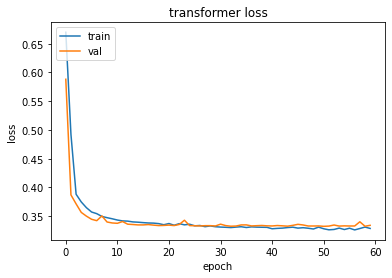

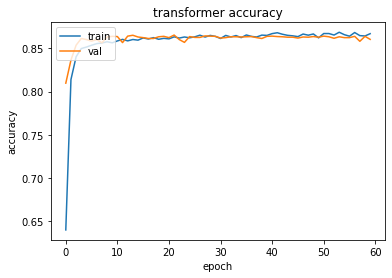


Test confusion matrix :
      0     1
0  1693   307
1   239  1761

Test Accuracy score:  0.8635
Test AUC score:  0.92894325
Test Precision score:  0.8515473887814313
Test Recall score:  0.8805
Test Specificity score:  0.8465
Test F1_score:  0.8657817109144542 


Test confusion matrix :
      0     1
0  1680   320
1   344  1656

Test Accuracy score:  0.834
Test AUC score:  0.9103251250000001
Test Precision score:  0.8380566801619433
Test Recall score:  0.828
Test Specificity score:  0.84
Test F1_score:  0.8329979879275654 



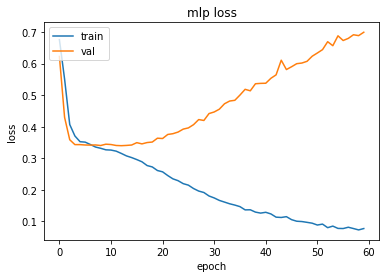

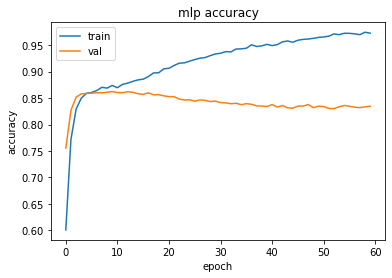


Test confusion matrix :
      0     1
0  1761   324
1   239  1676

Test Accuracy score:  0.85925
Test AUC score:  0.9264378784178923
Test Precision score:  0.838
Test Recall score:  0.875195822454308
Test Specificity score:  0.8446043165467626
Test F1_score:  0.8561941251596423 


Test confusion matrix :
      0     1
0  1762   323
1   364  1551

Test Accuracy score:  0.82825
Test AUC score:  0.9006836097701473
Test Precision score:  0.8276414087513341
Test Recall score:  0.8099216710182767
Test Specificity score:  0.8450839328537171
Test F1_score:  0.8186856690419636 



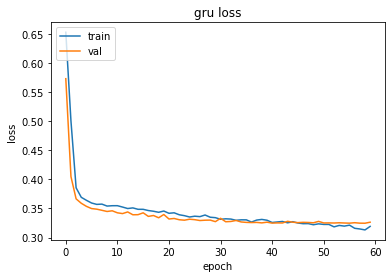

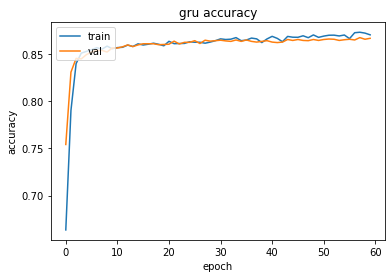


Test confusion matrix :
      0     1
0  1761   324
1   212  1703

Test Accuracy score:  0.866
Test AUC score:  0.9355758839403672
Test Precision score:  0.8401578687715836
Test Recall score:  0.8892950391644908
Test Specificity score:  0.8446043165467626
Test F1_score:  0.8640284119736173 


Test confusion matrix :
      0     1
0  1748   337
1   309  1606

Test Accuracy score:  0.8385
Test AUC score:  0.9047796332124899
Test Precision score:  0.8265568708183222
Test Recall score:  0.8386422976501305
Test Specificity score:  0.8383693045563549
Test F1_score:  0.8325557283566614 



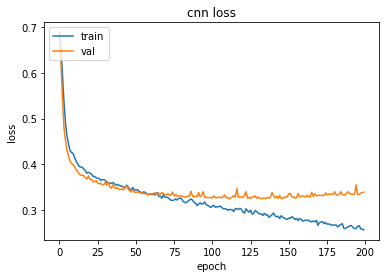

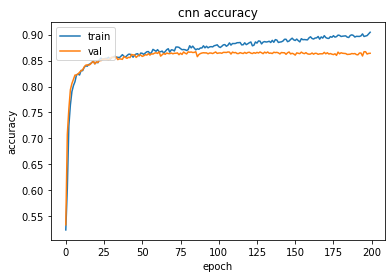


Test confusion matrix :
      0     1
0  1785   300
1   216  1699

Test Accuracy score:  0.871
Test AUC score:  0.9345760780409615
Test Precision score:  0.8499249624812406
Test Recall score:  0.8872062663185378
Test Specificity score:  0.8561151079136691
Test F1_score:  0.8681655595298927 


Test confusion matrix :
      0     1
0  1764   321
1   453  1462

Test Accuracy score:  0.8065
Test AUC score:  0.8875304769239439
Test Precision score:  0.8199663488502524
Test Recall score:  0.7634464751958224
Test Specificity score:  0.8460431654676259
Test F1_score:  0.7906976744186046 



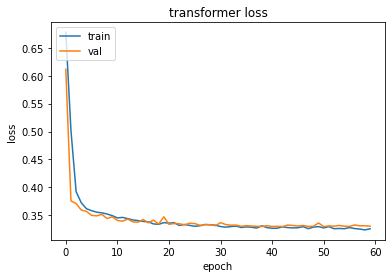

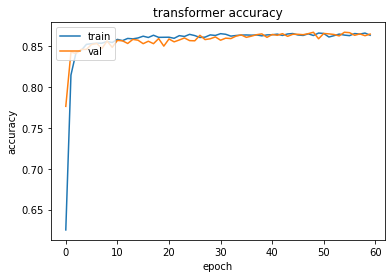


Test confusion matrix :
      0     1
0  1760   325
1   224  1691

Test Accuracy score:  0.86275
Test AUC score:  0.9313294638440685
Test Precision score:  0.8387896825396826
Test Recall score:  0.8830287206266318
Test Specificity score:  0.8441247002398081
Test F1_score:  0.8603408801831595 


Test confusion matrix :
      0     1
0  1749   336
1   296  1619

Test Accuracy score:  0.842
Test AUC score:  0.909347759390399
Test Precision score:  0.8281329923273657
Test Recall score:  0.8454308093994778
Test Specificity score:  0.8388489208633093
Test F1_score:  0.8366925064599483 



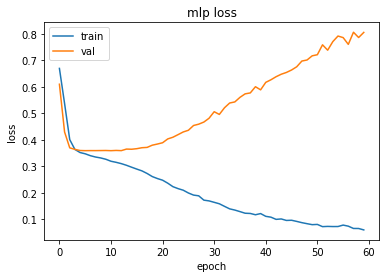

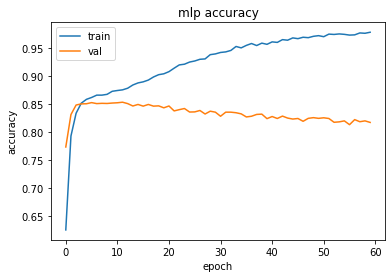


Test confusion matrix :
      0     1
0  1719   258
1   239  1784

Test Accuracy score:  0.87575
Test AUC score:  0.9354368365216299
Test Precision score:  0.8736532810969637
Test Recall score:  0.8818586258032625
Test Specificity score:  0.8694992412746586
Test F1_score:  0.8777367773677737 


Test confusion matrix :
      0     1
0  1722   255
1   382  1641

Test Accuracy score:  0.84075
Test AUC score:  0.9119381038142296
Test Precision score:  0.865506329113924
Test Recall score:  0.8111715274345032
Test Specificity score:  0.8710166919575114
Test F1_score:  0.8374585353406481 



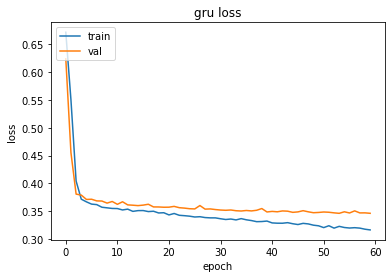

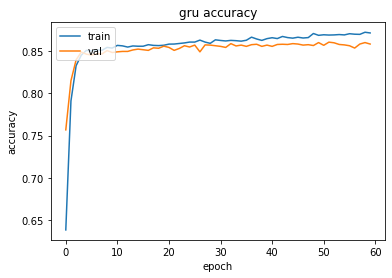


Test confusion matrix :
      0     1
0  1722   255
1   232  1791

Test Accuracy score:  0.87825
Test AUC score:  0.9400336944560918
Test Precision score:  0.875366568914956
Test Recall score:  0.8853188334157193
Test Specificity score:  0.8710166919575114
Test F1_score:  0.8803145736053085 


Test confusion matrix :
      0     1
0  1722   255
1   385  1638

Test Accuracy score:  0.84
Test AUC score:  0.912768463629315
Test Precision score:  0.8652931854199684
Test Recall score:  0.8096885813148789
Test Specificity score:  0.8710166919575114
Test F1_score:  0.836567926455567 



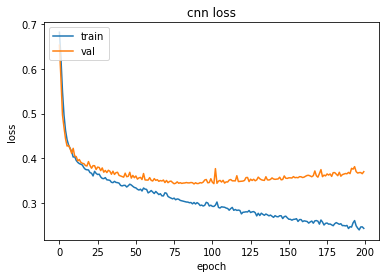

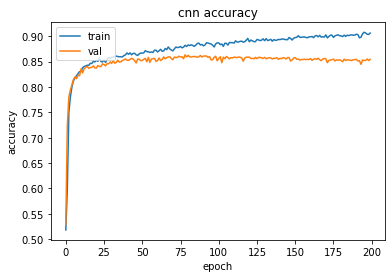


Test confusion matrix :
      0     1
0  1710   267
1   202  1821

Test Accuracy score:  0.88275
Test AUC score:  0.9440831049906351
Test Precision score:  0.8721264367816092
Test Recall score:  0.9001482946119624
Test Specificity score:  0.8649468892261002
Test F1_score:  0.8859158355631233 


Test confusion matrix :
      0     1
0  1704   273
1   498  1525

Test Accuracy score:  0.80725
Test AUC score:  0.890354124332943
Test Precision score:  0.8481646273637374
Test Recall score:  0.7538309441423628
Test Specificity score:  0.8619119878603946
Test F1_score:  0.7982203611619995 



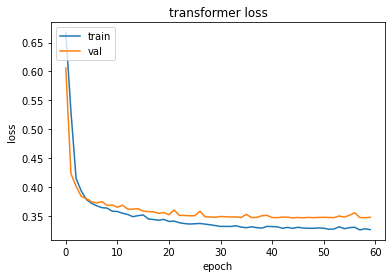

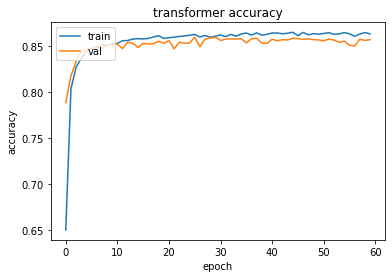


Test confusion matrix :
      0     1
0  1694   283
1   199  1824

Test Accuracy score:  0.8795
Test AUC score:  0.939428364401192
Test Precision score:  0.8656858092074039
Test Recall score:  0.9016312407315867
Test Specificity score:  0.8568538189175519
Test F1_score:  0.8832929782082325 


Test confusion matrix :
      0     1
0  1691   286
1   308  1715

Test Accuracy score:  0.8515
Test AUC score:  0.9184434641481337
Test Precision score:  0.8570714642678661
Test Recall score:  0.8477508650519031
Test Specificity score:  0.855336368234699
Test F1_score:  0.8523856858846918 



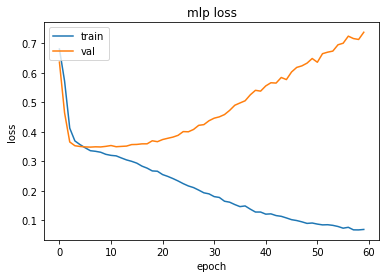

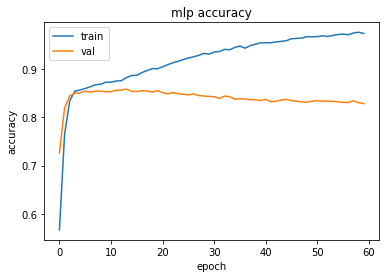


Test confusion matrix :
      0     1
0  1786   273
1   277  1664

Test Accuracy score:  0.8625
Test AUC score:  0.926237308017302
Test Precision score:  0.8590604026845637
Test Recall score:  0.8572900566718187
Test Specificity score:  0.8674113647401651
Test F1_score:  0.8581743166580711 


Test confusion matrix :
      0     1
0  1770   289
1   371  1570

Test Accuracy score:  0.835
Test AUC score:  0.9074729783594172
Test Precision score:  0.8445400753093061
Test Recall score:  0.8088614116434827
Test Specificity score:  0.8596406022340942
Test F1_score:  0.8263157894736841 



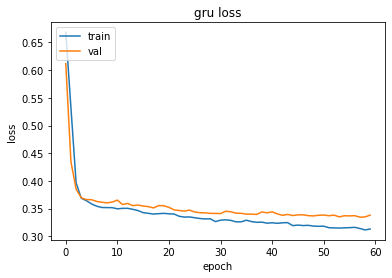

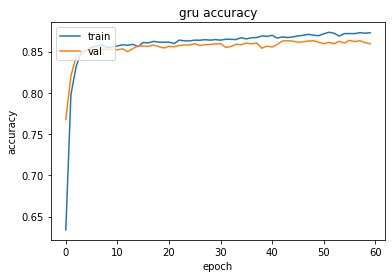


Test confusion matrix :
      0     1
0  1794   265
1   273  1668

Test Accuracy score:  0.8655
Test AUC score:  0.9341709622799241
Test Precision score:  0.8629073978272116
Test Recall score:  0.8593508500772797
Test Specificity score:  0.8712967459932006
Test F1_score:  0.8611254517294786 


Test confusion matrix :
      0     1
0  1782   277
1   395  1546

Test Accuracy score:  0.832
Test AUC score:  0.9107085441105122
Test Precision score:  0.848052660449808
Test Recall score:  0.7964966512107161
Test Specificity score:  0.8654686741136474
Test F1_score:  0.8214665249734325 



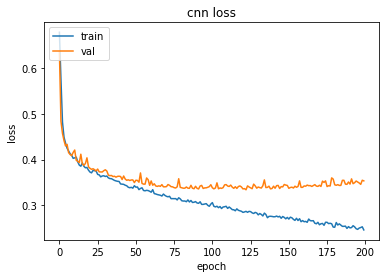

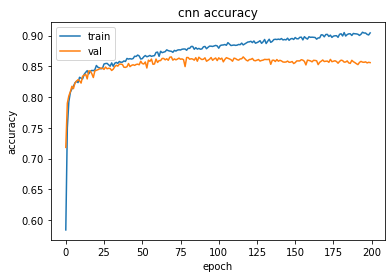


Test confusion matrix :
      0     1
0  1801   258
1   279  1662

Test Accuracy score:  0.86575
Test AUC score:  0.9325962168577205
Test Precision score:  0.865625
Test Recall score:  0.8562596599690881
Test Specificity score:  0.8746964545896067
Test F1_score:  0.860916860916861 


Test confusion matrix :
      0     1
0  1789   270
1   563  1378

Test Accuracy score:  0.79175
Test AUC score:  0.8800619989545903
Test Precision score:  0.8361650485436893
Test Recall score:  0.7099433281813499
Test Specificity score:  0.8688683827100534
Test F1_score:  0.7679019225410979 



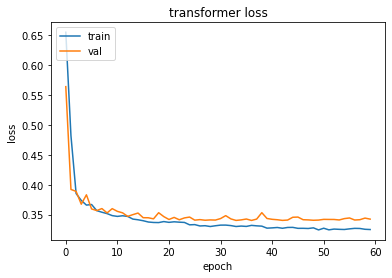

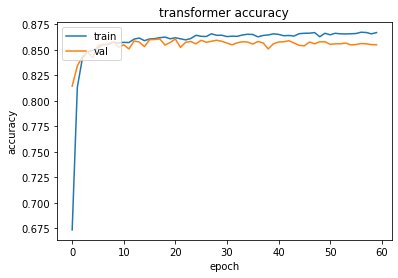


Test confusion matrix :
      0     1
0  1764   295
1   235  1706

Test Accuracy score:  0.8675
Test AUC score:  0.9322150101125505
Test Precision score:  0.8525737131434283
Test Recall score:  0.8789283874291602
Test Specificity score:  0.8567265662943176
Test F1_score:  0.8655504819888381 


Test confusion matrix :
      0     1
0  1747   312
1   300  1641

Test Accuracy score:  0.847
Test AUC score:  0.9144824533550323
Test Precision score:  0.8402457757296466
Test Recall score:  0.8454404945904173
Test Specificity score:  0.8484701311316173
Test F1_score:  0.8428351309707242 



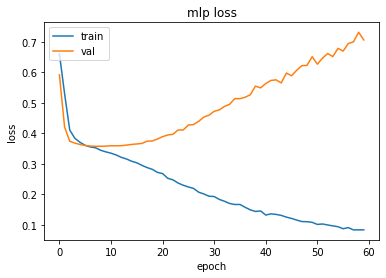

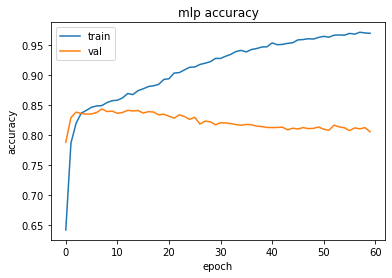


Test confusion matrix :
      0     1
0  1627   373
1   232  1768

Test Accuracy score:  0.84875
Test AUC score:  0.9210788749999999
Test Precision score:  0.8257823446987389
Test Recall score:  0.884
Test Specificity score:  0.8135
Test F1_score:  0.8539000241487563 


Test confusion matrix :
      0     1
0  1632   368
1   345  1655

Test Accuracy score:  0.82175
Test AUC score:  0.9019595
Test Precision score:  0.8180919426594168
Test Recall score:  0.8275
Test Specificity score:  0.816
Test F1_score:  0.8227690778026349 



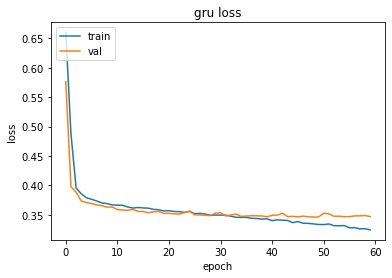

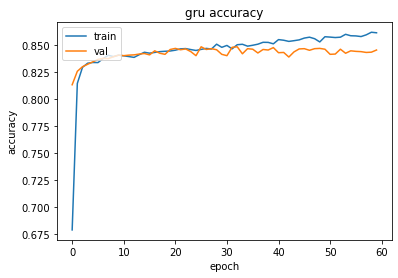


Test confusion matrix :
      0     1
0  1659   341
1   235  1765

Test Accuracy score:  0.856
Test AUC score:  0.926140875
Test Precision score:  0.8380816714150048
Test Recall score:  0.8825
Test Specificity score:  0.8295
Test F1_score:  0.8597174866049684 


Test confusion matrix :
      0     1
0  1656   344
1   376  1624

Test Accuracy score:  0.82
Test AUC score:  0.9027497499999999
Test Precision score:  0.8252032520325203
Test Recall score:  0.812
Test Specificity score:  0.828
Test F1_score:  0.8185483870967741 



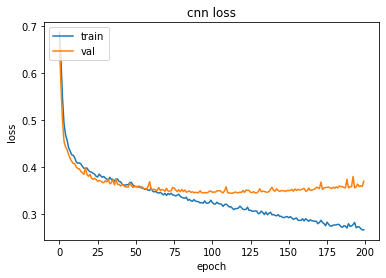

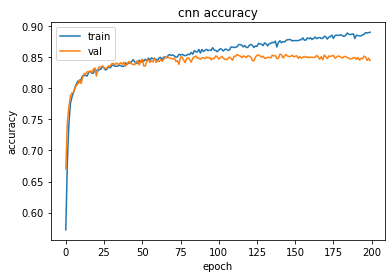


Test confusion matrix :
      0     1
0  1695   305
1   280  1720

Test Accuracy score:  0.85375
Test AUC score:  0.9278945
Test Precision score:  0.8493827160493828
Test Recall score:  0.86
Test Specificity score:  0.8475
Test F1_score:  0.8546583850931678 


Test confusion matrix :
      0     1
0  1696   304
1   501  1499

Test Accuracy score:  0.79875
Test AUC score:  0.8885934999999999
Test Precision score:  0.8313921242373822
Test Recall score:  0.7495
Test Specificity score:  0.848
Test F1_score:  0.7883250065737576 



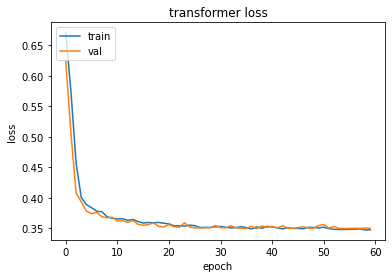

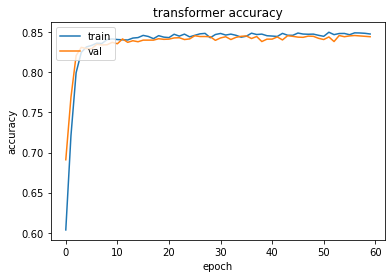


Test confusion matrix :
      0     1
0  1643   357
1   228  1772

Test Accuracy score:  0.85375
Test AUC score:  0.92390375
Test Precision score:  0.8323156411460779
Test Recall score:  0.886
Test Specificity score:  0.8215
Test F1_score:  0.8583192056187939 


Test confusion matrix :
      0     1
0  1639   361
1   331  1669

Test Accuracy score:  0.827
Test AUC score:  0.9045745000000002
Test Precision score:  0.822167487684729
Test Recall score:  0.8345
Test Specificity score:  0.8195
Test F1_score:  0.8282878411910669 



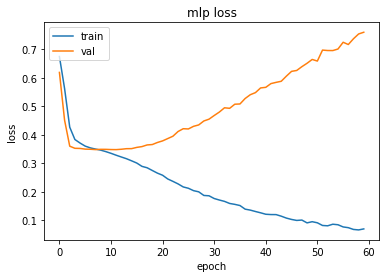

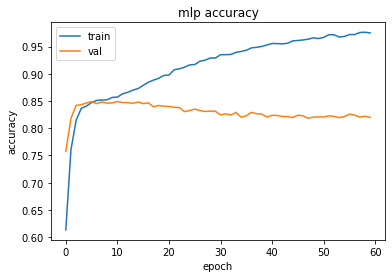


Test confusion matrix :
      0     1
0  1582   384
1   250  1784

Test Accuracy score:  0.8415
Test AUC score:  0.9135765236153248
Test Precision score:  0.8228782287822878
Test Recall score:  0.8770894788593904
Test Specificity score:  0.8046795523906409
Test F1_score:  0.8491194669205141 


Test confusion matrix :
      0     1
0  1579   387
1   351  1683

Test Accuracy score:  0.8155
Test AUC score:  0.8916731935529368
Test Precision score:  0.8130434782608695
Test Recall score:  0.827433628318584
Test Specificity score:  0.8031536113936928
Test F1_score:  0.8201754385964913 



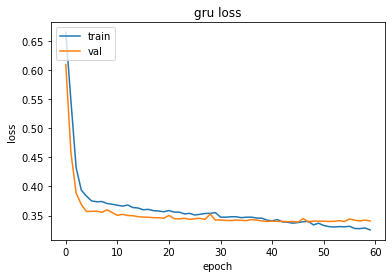

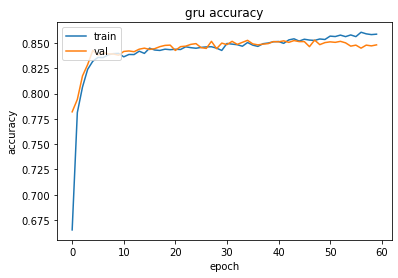


Test confusion matrix :
      0     1
0  1556   410
1   223  1811

Test Accuracy score:  0.84175
Test AUC score:  0.9158259236919469
Test Precision score:  0.8153984691580369
Test Recall score:  0.8903638151425762
Test Specificity score:  0.7914547304170906
Test F1_score:  0.8512338425381903 


Test confusion matrix :
      0     1
0  1573   393
1   332  1702

Test Accuracy score:  0.81875
Test AUC score:  0.8963581725118558
Test Precision score:  0.8124105011933174
Test Recall score:  0.8367748279252704
Test Specificity score:  0.8001017293997965
Test F1_score:  0.8244126907241464 



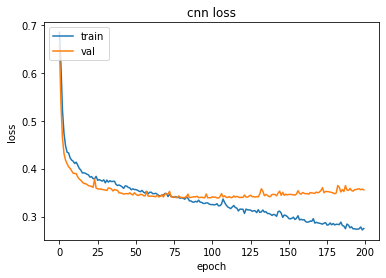

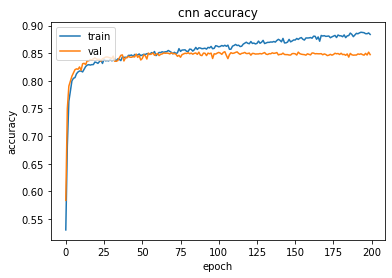


Test confusion matrix :
      0     1
0  1591   375
1   260  1774

Test Accuracy score:  0.84125
Test AUC score:  0.9154751973320292
Test Precision score:  0.8255002326663564
Test Recall score:  0.872173058013766
Test Specificity score:  0.8092573753814852
Test F1_score:  0.8481950753048052 


Test confusion matrix :
      0     1
0  1609   357
1   431  1603

Test Accuracy score:  0.803
Test AUC score:  0.8840713716263999
Test Precision score:  0.8178571428571428
Test Recall score:  0.788102261553589
Test Specificity score:  0.818413021363174
Test F1_score:  0.8027040560841261 



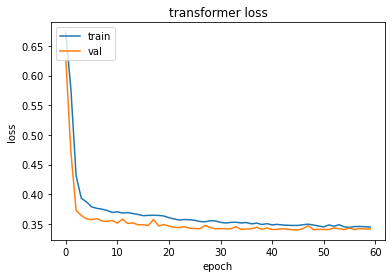

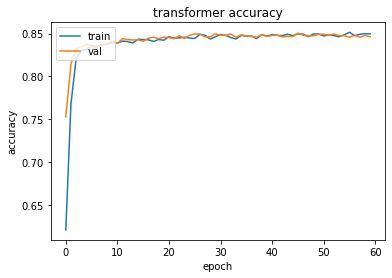


Test confusion matrix :
      0     1
0  1555   411
1   223  1811

Test Accuracy score:  0.8415
Test AUC score:  0.9146136983588258
Test Precision score:  0.815031503150315
Test Recall score:  0.8903638151425762
Test Specificity score:  0.7909460834181078
Test F1_score:  0.8510338345864661 


Test confusion matrix :
      0     1
0  1571   395
1   301  1733

Test Accuracy score:  0.826
Test AUC score:  0.8974696187198099
Test Precision score:  0.8143796992481203
Test Recall score:  0.852015732546706
Test Specificity score:  0.7990844354018312
Test F1_score:  0.8327727054300817 



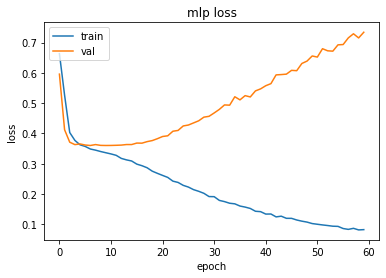

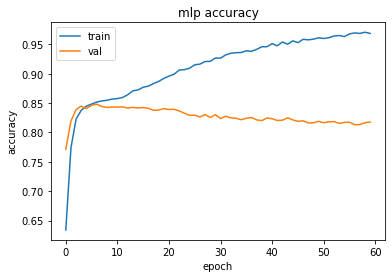


Test confusion matrix :
      0     1
0  1623   410
1   230  1737

Test Accuracy score:  0.84
Test AUC score:  0.9160470188008685
Test Precision score:  0.8090358639962739
Test Recall score:  0.8830706659888155
Test Specificity score:  0.7983275946876537
Test F1_score:  0.844433641225085 


Test confusion matrix :
      0     1
0  1633   400
1   340  1627

Test Accuracy score:  0.815
Test AUC score:  0.894464768033097
Test Precision score:  0.8026640355204736
Test Recall score:  0.8271479410269446
Test Specificity score:  0.8032464338416134
Test F1_score:  0.8147220831246871 



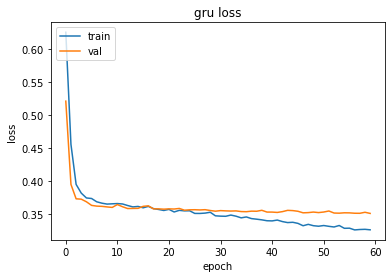

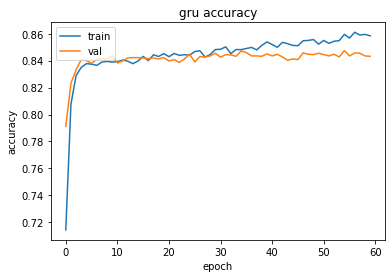


Test confusion matrix :
      0     1
0  1679   354
1   248  1719

Test Accuracy score:  0.8495
Test AUC score:  0.9208419492206752
Test Precision score:  0.829232995658466
Test Recall score:  0.8739196746314184
Test Specificity score:  0.8258730939498279
Test F1_score:  0.850990099009901 


Test confusion matrix :
      0     1
0  1690   343
1   415  1552

Test Accuracy score:  0.8105
Test AUC score:  0.8947140859098889
Test Precision score:  0.8189973614775725
Test Recall score:  0.7890188103711235
Test Specificity score:  0.8312838170191835
Test F1_score:  0.803728638011393 



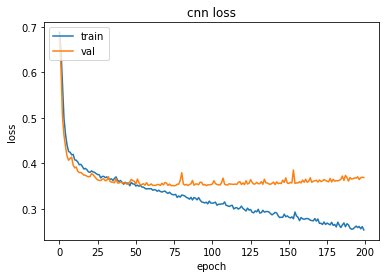

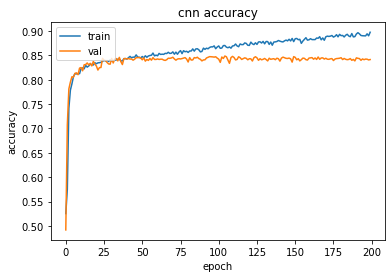


Test confusion matrix :
      0     1
0  1693   340
1   253  1714

Test Accuracy score:  0.85175
Test AUC score:  0.9227787265082918
Test Precision score:  0.8344693281402142
Test Recall score:  0.871377732587697
Test Specificity score:  0.8327594687653713
Test F1_score:  0.8525242476995772 


Test confusion matrix :
      0     1
0  1692   341
1   473  1494

Test Accuracy score:  0.7965
Test AUC score:  0.8885351536955937
Test Precision score:  0.8141689373297003
Test Recall score:  0.7595322826639552
Test Specificity score:  0.8322675848499754
Test F1_score:  0.7859021567596002 



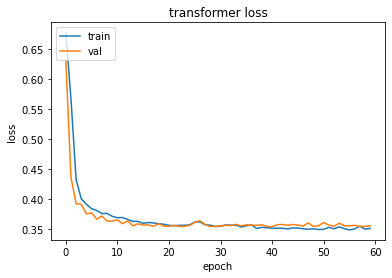

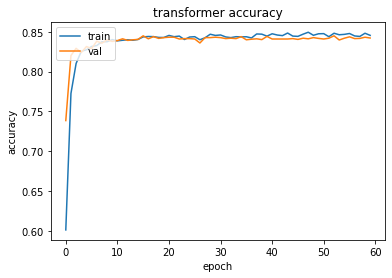


Test confusion matrix :
      0     1
0  1645   388
1   229  1738

Test Accuracy score:  0.84575
Test AUC score:  0.9200884940925167
Test Precision score:  0.8174976481655691
Test Recall score:  0.8835790543975597
Test Specificity score:  0.809149040826365
Test F1_score:  0.8492548253115074 


Test confusion matrix :
      0     1
0  1648   385
1   352  1615

Test Accuracy score:  0.81575
Test AUC score:  0.8977359086011167
Test Precision score:  0.8075
Test Recall score:  0.8210472801220132
Test Specificity score:  0.8106246925725529
Test F1_score:  0.814217292664482 



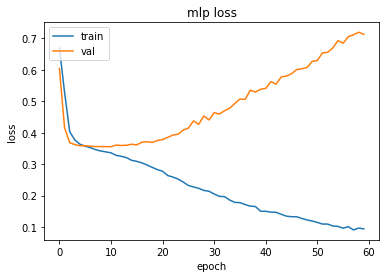

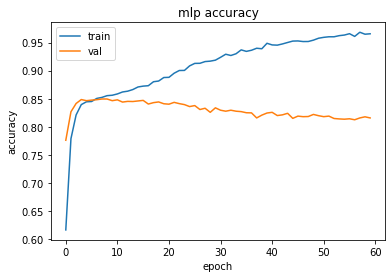


Test confusion matrix :
      0     1
0  1596   394
1   234  1776

Test Accuracy score:  0.843
Test AUC score:  0.9162022800570016
Test Precision score:  0.8184331797235023
Test Recall score:  0.8835820895522388
Test Specificity score:  0.8020100502512563
Test F1_score:  0.8497607655502393 


Test confusion matrix :
      0     1
0  1606   384
1   348  1662

Test Accuracy score:  0.817
Test AUC score:  0.8938329708242707
Test Precision score:  0.8123167155425219
Test Recall score:  0.826865671641791
Test Specificity score:  0.807035175879397
Test F1_score:  0.819526627218935 



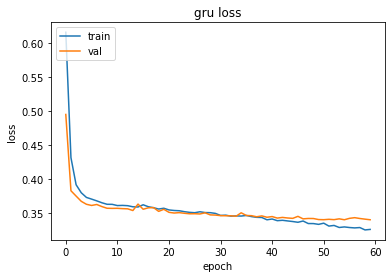

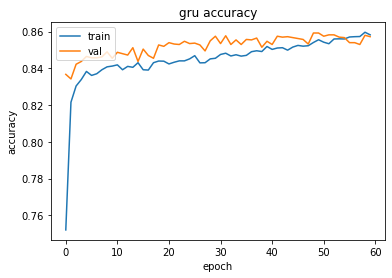


Test confusion matrix :
      0     1
0  1613   377
1   226  1784

Test Accuracy score:  0.84925
Test AUC score:  0.9227676941923548
Test Precision score:  0.8255437297547432
Test Recall score:  0.8875621890547264
Test Specificity score:  0.8105527638190955
Test F1_score:  0.8554303524334692 


Test confusion matrix :
      0     1
0  1619   371
1   361  1649

Test Accuracy score:  0.817
Test AUC score:  0.8929538238455961
Test Precision score:  0.8163366336633663
Test Recall score:  0.8203980099502488
Test Specificity score:  0.8135678391959799
Test F1_score:  0.818362282878412 



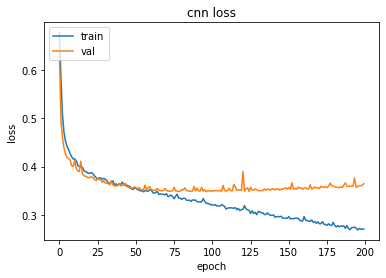

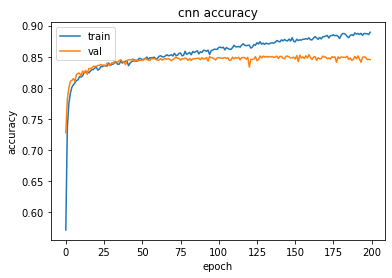


Test confusion matrix :
      0     1
0  1641   349
1   257  1753

Test Accuracy score:  0.8485
Test AUC score:  0.923492962324058
Test Precision score:  0.8339676498572788
Test Recall score:  0.8721393034825871
Test Specificity score:  0.8246231155778895
Test F1_score:  0.8526264591439688 


Test confusion matrix :
      0     1
0  1643   347
1   448  1562

Test Accuracy score:  0.80125
Test AUC score:  0.8799789994749869
Test Precision score:  0.8182294394971189
Test Recall score:  0.7771144278606965
Test Specificity score:  0.8256281407035176
Test F1_score:  0.7971421280939015 



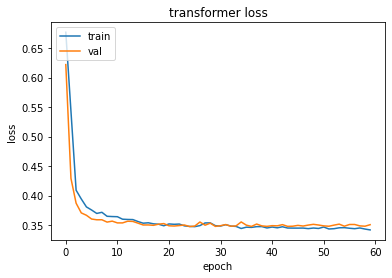

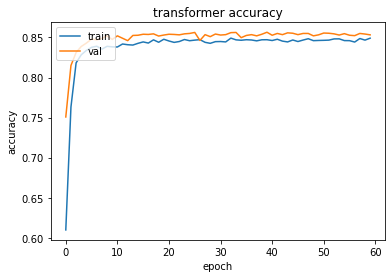


Test confusion matrix :
      0     1
0  1597   393
1   239  1771

Test Accuracy score:  0.842
Test AUC score:  0.9197036175904398
Test Precision score:  0.8183918669131238
Test Recall score:  0.881094527363184
Test Specificity score:  0.8025125628140704
Test F1_score:  0.8485864877815046 


Test confusion matrix :
      0     1
0  1615   375
1   340  1670

Test Accuracy score:  0.82125
Test AUC score:  0.8949196229905747
Test Precision score:  0.8166259168704156
Test Recall score:  0.8308457711442786
Test Specificity score:  0.8115577889447236
Test F1_score:  0.8236744759556104 



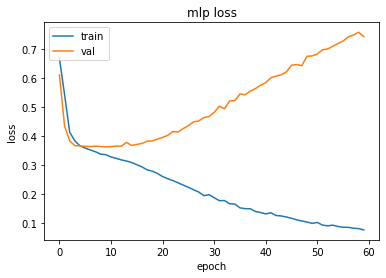

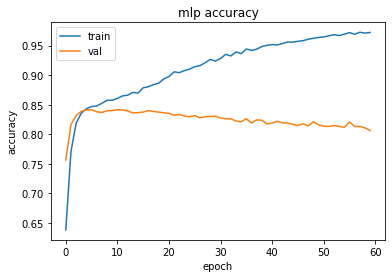


Test confusion matrix :
      0     1
0  1606   377
1   271  1746

Test Accuracy score:  0.838
Test AUC score:  0.9148871005930178
Test Precision score:  0.8224211022138483
Test Recall score:  0.8656420426375806
Test Specificity score:  0.8098840141200202
Test F1_score:  0.8434782608695652 


Test confusion matrix :
      0     1
0  1601   382
1   390  1627

Test Accuracy score:  0.807
Test AUC score:  0.8900995596931878
Test Precision score:  0.8098556495769039
Test Recall score:  0.8066435299950422
Test Specificity score:  0.8073625819465456
Test F1_score:  0.8082463984103329 



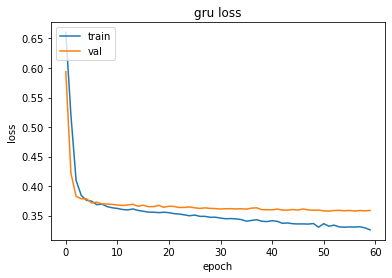

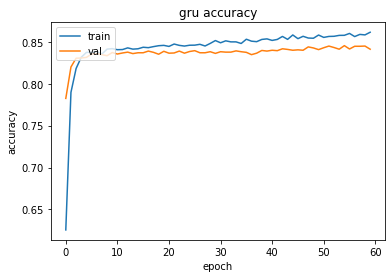


Test confusion matrix :
      0     1
0  1580   403
1   218  1799

Test Accuracy score:  0.84475
Test AUC score:  0.9207012706668056
Test Precision score:  0.8169845594913715
Test Recall score:  0.8919186911254338
Test Specificity score:  0.7967725668179526
Test F1_score:  0.8528087224460772 


Test confusion matrix :
      0     1
0  1600   383
1   357  1660

Test Accuracy score:  0.815
Test AUC score:  0.8943751186023191
Test Precision score:  0.8125305922662751
Test Recall score:  0.8230044620723848
Test Specificity score:  0.8068582955118507
Test F1_score:  0.8177339901477834 



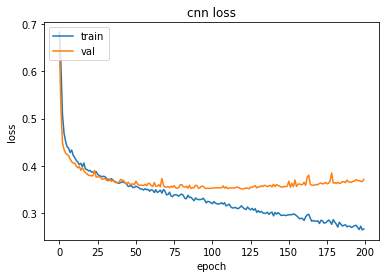

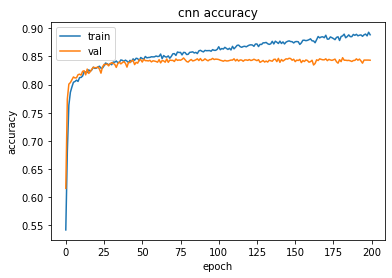


Test confusion matrix :
      0     1
0  1625   358
1   261  1756

Test Accuracy score:  0.84525
Test AUC score:  0.9231394468250331
Test Precision score:  0.8306527909176916
Test Recall score:  0.8705999008428359
Test Specificity score:  0.8194654563792234
Test F1_score:  0.8501573468893731 


Test confusion matrix :
      0     1
0  1658   325
1   515  1502

Test Accuracy score:  0.79
Test AUC score:  0.880714006586976
Test Precision score:  0.8221127531472359
Test Recall score:  0.7446703024293505
Test Specificity score:  0.8361069087241553
Test F1_score:  0.7814776274713839 



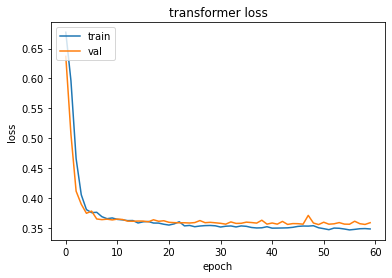

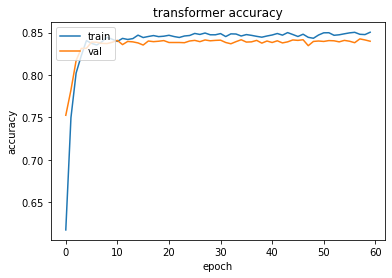


Test confusion matrix :
      0     1
0  1572   411
1   216  1801

Test Accuracy score:  0.84325
Test AUC score:  0.9189001405351536
Test Precision score:  0.8141952983725136
Test Recall score:  0.8929102627664849
Test Specificity score:  0.7927382753403933
Test F1_score:  0.8517379995270751 


Test confusion matrix :
      0     1
0  1572   411
1   328  1689

Test Accuracy score:  0.81525
Test AUC score:  0.8940655962393282
Test Precision score:  0.8042857142857143
Test Recall score:  0.8373822508676252
Test Specificity score:  0.7927382753403933
Test F1_score:  0.8205003643429682 



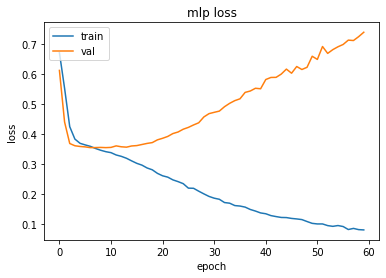

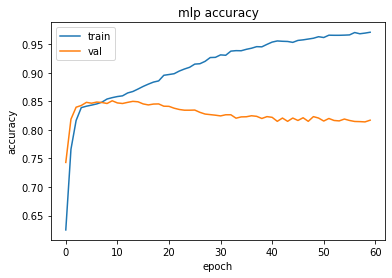


Test confusion matrix :
      0     1
0  1599   410
1   201  1790

Test Accuracy score:  0.84725
Test AUC score:  0.9208771477622422
Test Precision score:  0.8136363636363636
Test Recall score:  0.8990457056755399
Test Specificity score:  0.7959183673469388
Test F1_score:  0.8542114053925077 


Test confusion matrix :
      0     1
0  1580   429
1   308  1683

Test Accuracy score:  0.81575
Test AUC score:  0.8931509613069666
Test Precision score:  0.796875
Test Recall score:  0.8453038674033149
Test Specificity score:  0.7864609258337482
Test F1_score:  0.8203753351206434 



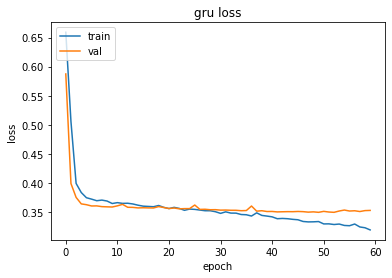

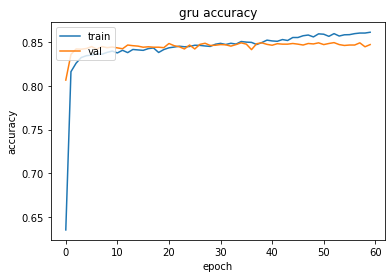


Test confusion matrix :
      0     1
0  1614   395
1   214  1777

Test Accuracy score:  0.84775
Test AUC score:  0.9237212053544085
Test Precision score:  0.8181399631675875
Test Recall score:  0.89251632345555
Test Specificity score:  0.8033847685415629
Test F1_score:  0.8537112659140044 


Test confusion matrix :
      0     1
0  1614   395
1   317  1674

Test Accuracy score:  0.822
Test AUC score:  0.8968584113828303
Test Precision score:  0.8090865152247463
Test Recall score:  0.8407835258663988
Test Specificity score:  0.8033847685415629
Test F1_score:  0.8246305418719212 



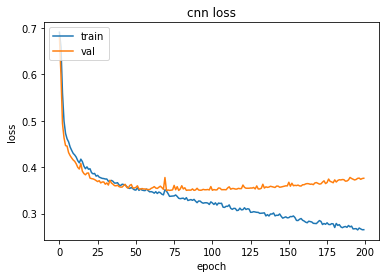

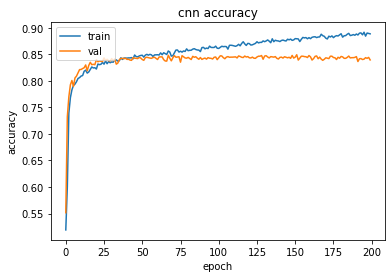


Test confusion matrix :
      0     1
0  1643   366
1   234  1757

Test Accuracy score:  0.85
Test AUC score:  0.926258006724636
Test Precision score:  0.8276024493641074
Test Recall score:  0.8824711200401808
Test Specificity score:  0.8178198108511697
Test F1_score:  0.8541565386485173 


Test confusion matrix :
      0     1
0  1636   373
1   447  1544

Test Accuracy score:  0.795
Test AUC score:  0.8834362645843579
Test Precision score:  0.8054251434533125
Test Recall score:  0.7754897036664993
Test Specificity score:  0.8143354902936785
Test F1_score:  0.7901740020470829 



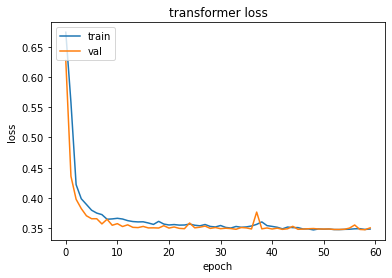

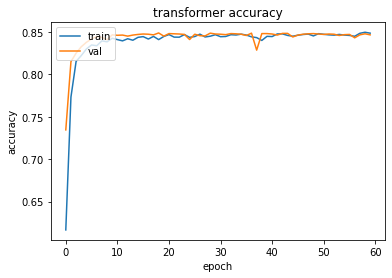


Test confusion matrix :
      0     1
0  1627   382
1   217  1774

Test Accuracy score:  0.85025
Test AUC score:  0.9239724604423238
Test Precision score:  0.8228200371057514
Test Recall score:  0.8910095429432446
Test Specificity score:  0.8098556495769039
Test F1_score:  0.8555582348685797 


Test confusion matrix :
      0     1
0  1613   396
1   320  1671

Test Accuracy score:  0.821
Test AUC score:  0.8968141604867499
Test Precision score:  0.8084179970972424
Test Recall score:  0.8392767453540935
Test Specificity score:  0.8028870084619214
Test F1_score:  0.8235584031542632 



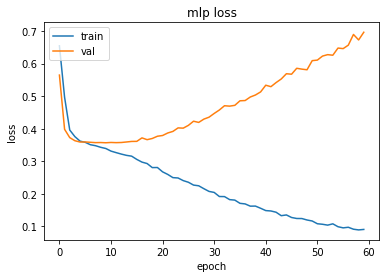

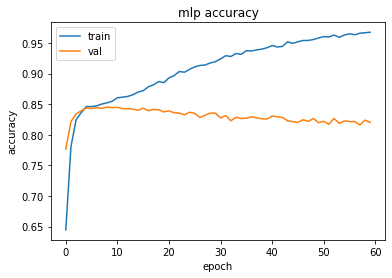


Test confusion matrix :
      0     1
0  1612   388
1   224  1776

Test Accuracy score:  0.847
Test AUC score:  0.91575775
Test Precision score:  0.8207024029574861
Test Recall score:  0.888
Test Specificity score:  0.806
Test F1_score:  0.8530259365994235 


Test confusion matrix :
      0     1
0  1598   402
1   329  1671

Test Accuracy score:  0.81725
Test AUC score:  0.890788875
Test Precision score:  0.8060781476121563
Test Recall score:  0.8355
Test Specificity score:  0.799
Test F1_score:  0.8205254112447827 



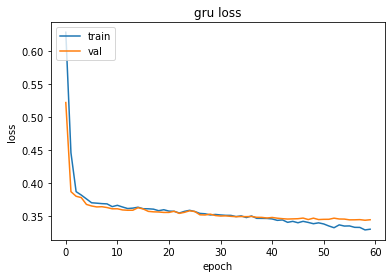

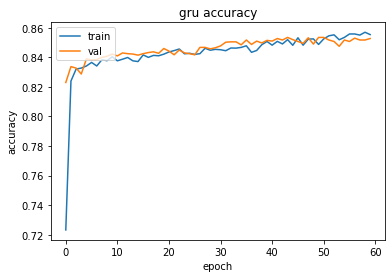


Test confusion matrix :
      0     1
0  1596   404
1   208  1792

Test Accuracy score:  0.847
Test AUC score:  0.92150325
Test Precision score:  0.8160291438979964
Test Recall score:  0.896
Test Specificity score:  0.798
Test F1_score:  0.8541468064823642 


Test confusion matrix :
      0     1
0  1591   409
1   325  1675

Test Accuracy score:  0.8165
Test AUC score:  0.889919125
Test Precision score:  0.803742802303263
Test Recall score:  0.8375
Test Specificity score:  0.7955
Test F1_score:  0.8202742409402547 



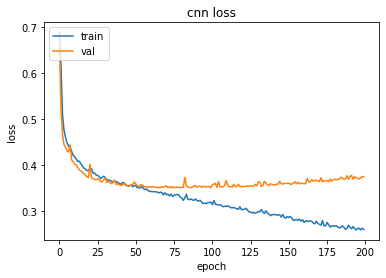

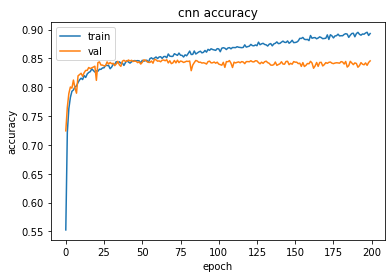


Test confusion matrix :
      0     1
0  1658   342
1   263  1737

Test Accuracy score:  0.84875
Test AUC score:  0.92320925
Test Precision score:  0.8354978354978355
Test Recall score:  0.8685
Test Specificity score:  0.829
Test F1_score:  0.8516793331698946 


Test confusion matrix :
      0     1
0  1662   338
1   443  1557

Test Accuracy score:  0.80475
Test AUC score:  0.883013125
Test Precision score:  0.8216358839050132
Test Recall score:  0.7785
Test Specificity score:  0.831
Test F1_score:  0.7994865211810013 



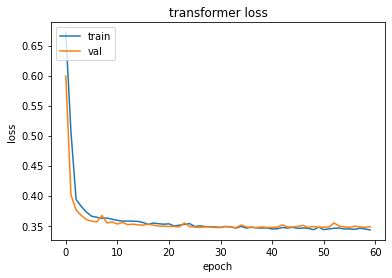

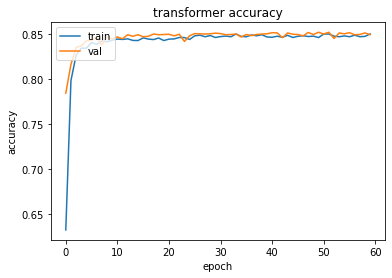


Test confusion matrix :
      0     1
0  1600   400
1   220  1780

Test Accuracy score:  0.845
Test AUC score:  0.919639375
Test Precision score:  0.8165137614678899
Test Recall score:  0.89
Test Specificity score:  0.8
Test F1_score:  0.8516746411483254 


Test confusion matrix :
      0     1
0  1602   398
1   319  1681

Test Accuracy score:  0.82075
Test AUC score:  0.89686825
Test Precision score:  0.8085618085618086
Test Recall score:  0.8405
Test Specificity score:  0.801
Test F1_score:  0.8242216229468007 



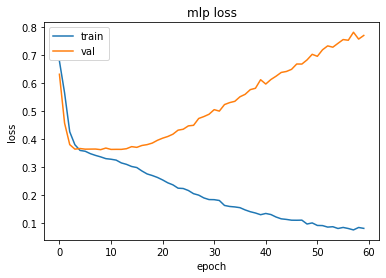

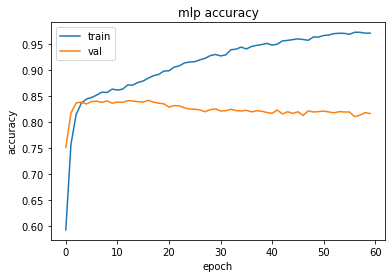


Test confusion matrix :
      0     1
0  1653   432
1   220  1695

Test Accuracy score:  0.837
Test AUC score:  0.9136160940699137
Test Precision score:  0.7968970380818053
Test Recall score:  0.8851174934725848
Test Specificity score:  0.7928057553956834
Test F1_score:  0.838693715982187 


Test confusion matrix :
      0     1
0  1653   432
1   311  1604

Test Accuracy score:  0.81425
Test AUC score:  0.8883004927650568
Test Precision score:  0.787819253438114
Test Recall score:  0.8375979112271541
Test Specificity score:  0.7928057553956834
Test F1_score:  0.8119463426980511 



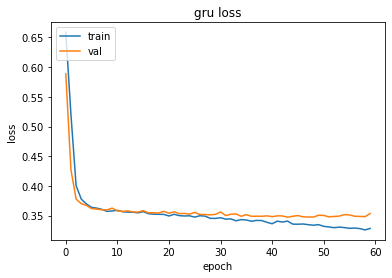

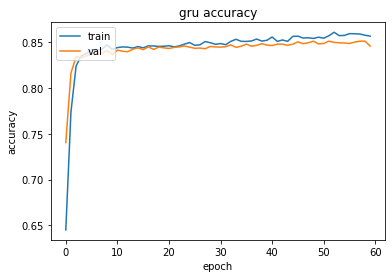


Test confusion matrix :
      0     1
0  1690   395
1   228  1687

Test Accuracy score:  0.84425
Test AUC score:  0.9208795887571928
Test Precision score:  0.8102785782901056
Test Recall score:  0.8809399477806789
Test Specificity score:  0.8105515587529976
Test F1_score:  0.8441330998248686 


Test confusion matrix :
      0     1
0  1678   407
1   315  1600

Test Accuracy score:  0.8195
Test AUC score:  0.894689032064166
Test Precision score:  0.7972097658196313
Test Recall score:  0.835509138381201
Test Specificity score:  0.8047961630695444
Test F1_score:  0.815910249872514 



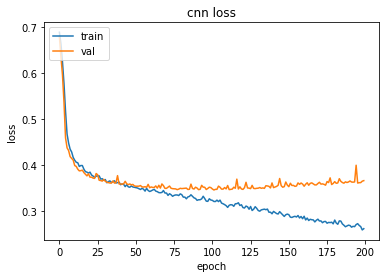

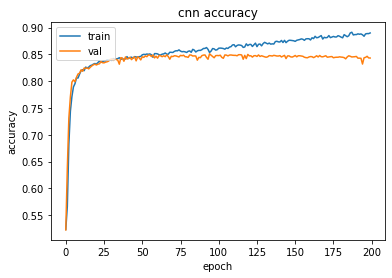


Test confusion matrix :
      0     1
0  1716   369
1   255  1660

Test Accuracy score:  0.844
Test AUC score:  0.9202300405106724
Test Precision score:  0.8181370133070478
Test Recall score:  0.8668407310704961
Test Specificity score:  0.823021582733813
Test F1_score:  0.8417849898580121 


Test confusion matrix :
      0     1
0  1704   381
1   425  1490

Test Accuracy score:  0.7985
Test AUC score:  0.8802629749985913
Test Precision score:  0.7963655799037948
Test Recall score:  0.7780678851174935
Test Specificity score:  0.8172661870503597
Test F1_score:  0.7871104067617539 



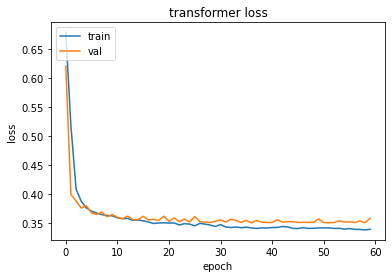

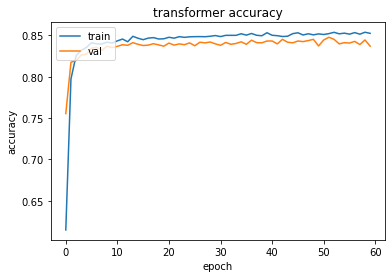


Test confusion matrix :
      0     1
0  1690   395
1   222  1693

Test Accuracy score:  0.84575
Test AUC score:  0.9180559886294619
Test Precision score:  0.810823754789272
Test Recall score:  0.8840731070496084
Test Specificity score:  0.8105515587529976
Test F1_score:  0.8458656007994005 


Test confusion matrix :
      0     1
0  1690   395
1   319  1596

Test Accuracy score:  0.8215
Test AUC score:  0.8914595738552761
Test Precision score:  0.801607232546459
Test Recall score:  0.833420365535248
Test Specificity score:  0.8105515587529976
Test F1_score:  0.8172043010752688 



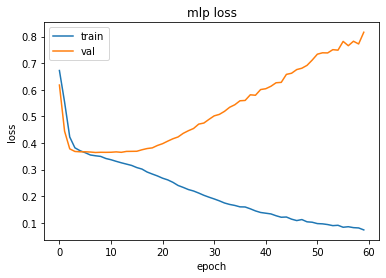

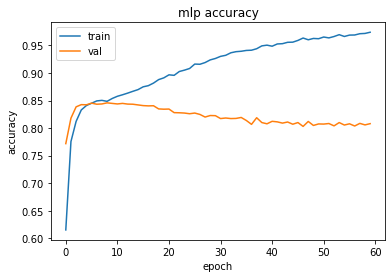


Test confusion matrix :
      0     1
0  1632   345
1   251  1772

Test Accuracy score:  0.851
Test AUC score:  0.9280777382808877
Test Precision score:  0.8370335380255078
Test Recall score:  0.8759268413247652
Test Specificity score:  0.8254931714719271
Test F1_score:  0.8560386473429952 


Test confusion matrix :
      0     1
0  1630   347
1   345  1678

Test Accuracy score:  0.827
Test AUC score:  0.9009110204824589
Test Precision score:  0.8286419753086419
Test Recall score:  0.8294611962432031
Test Specificity score:  0.8244815376833586
Test F1_score:  0.8290513833992094 



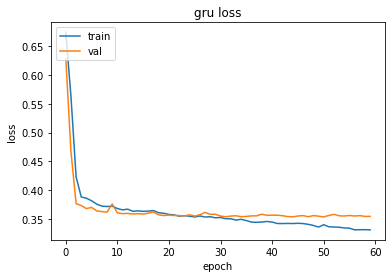

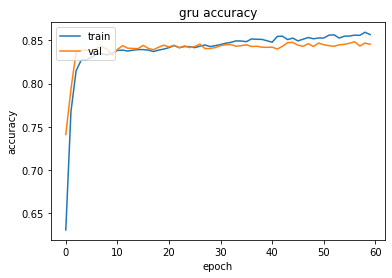


Test confusion matrix :
      0     1
0  1654   323
1   251  1772

Test Accuracy score:  0.8565
Test AUC score:  0.9315749507872416
Test Precision score:  0.8458233890214797
Test Recall score:  0.8759268413247652
Test Specificity score:  0.8366211431461811
Test F1_score:  0.860611947547353 


Test confusion matrix :
      0     1
0  1654   323
1   380  1643

Test Accuracy score:  0.82425
Test AUC score:  0.9041159443336382
Test Precision score:  0.8357070193285859
Test Recall score:  0.8121601581809195
Test Specificity score:  0.8366211431461811
Test F1_score:  0.823765354725495 



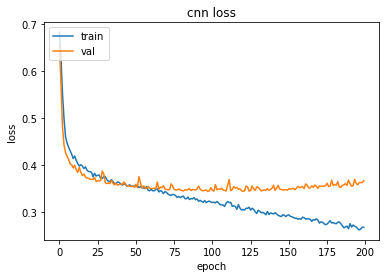

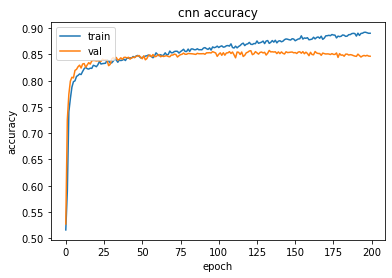


Test confusion matrix :
      0     1
0  1668   309
1   255  1768

Test Accuracy score:  0.859
Test AUC score:  0.9315750758037751
Test Precision score:  0.8512277323062108
Test Recall score:  0.8739495798319328
Test Specificity score:  0.8437025796661608
Test F1_score:  0.8624390243902439 


Test confusion matrix :
      0     1
0  1676   301
1   472  1551

Test Accuracy score:  0.80675
Test AUC score:  0.8923322609415095
Test Precision score:  0.8374730021598272
Test Recall score:  0.7666831438457736
Test Specificity score:  0.847749114820435
Test F1_score:  0.800516129032258 



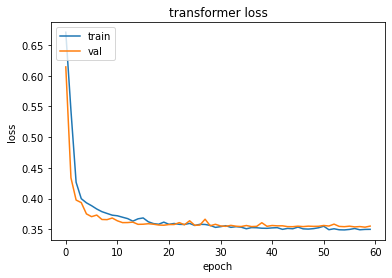

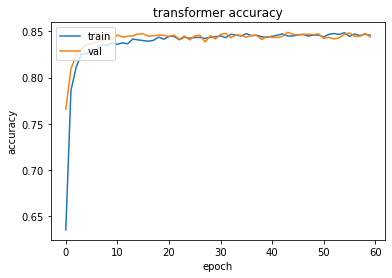


Test confusion matrix :
      0     1
0  1648   329
1   264  1759

Test Accuracy score:  0.85175
Test AUC score:  0.9301727653482175
Test Precision score:  0.8424329501915708
Test Recall score:  0.8695007414730598
Test Specificity score:  0.8335862417804755
Test F1_score:  0.8557528581853564 


Test confusion matrix :
      0     1
0  1650   327
1   371  1652

Test Accuracy score:  0.8255
Test AUC score:  0.9052472189447054
Test Precision score:  0.8347650328448711
Test Recall score:  0.8166089965397924
Test Specificity score:  0.834597875569044
Test F1_score:  0.8255872063968016 



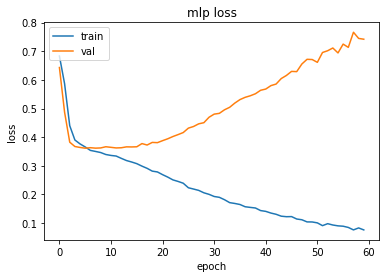

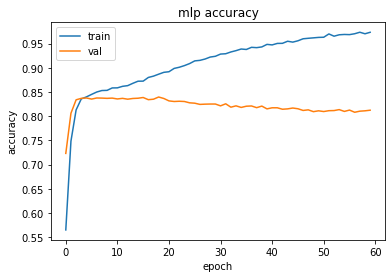


Test confusion matrix :
      0     1
0  1696   363
1   266  1675

Test Accuracy score:  0.84275
Test AUC score:  0.9222678535995951
Test Precision score:  0.8218842001962708
Test Recall score:  0.8629572385368367
Test Specificity score:  0.8237008256435163
Test F1_score:  0.8419200804222167 


Test confusion matrix :
      0     1
0  1693   366
1   399  1542

Test Accuracy score:  0.80875
Test AUC score:  0.8946147885197093
Test Precision score:  0.8081761006289309
Test Recall score:  0.794435857805255
Test Specificity score:  0.8222438076736279
Test F1_score:  0.8012470771628996 



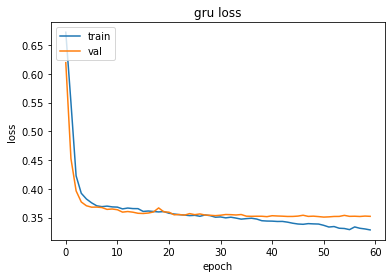

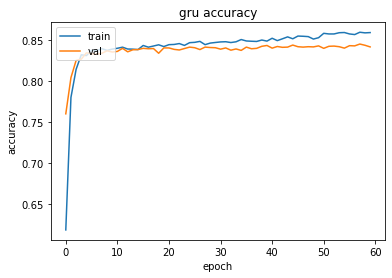


Test confusion matrix :
      0     1
0  1728   331
1   258  1683

Test Accuracy score:  0.85275
Test AUC score:  0.9271583595624092
Test Precision score:  0.8356504468718967
Test Recall score:  0.8670788253477589
Test Specificity score:  0.8392423506556581
Test F1_score:  0.8510745891276865 


Test confusion matrix :
      0     1
0  1713   346
1   389  1552

Test Accuracy score:  0.81625
Test AUC score:  0.8976143989306694
Test Precision score:  0.8177028451001054
Test Recall score:  0.7995878413189078
Test Specificity score:  0.8319572608062166
Test F1_score:  0.8085438916384475 



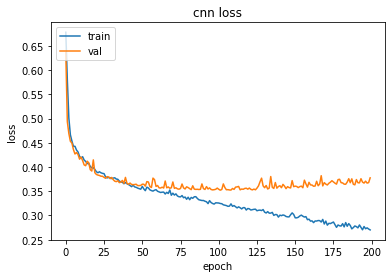

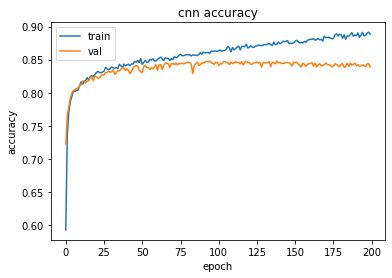


Test confusion matrix :
      0     1
0  1750   309
1   279  1662

Test Accuracy score:  0.853
Test AUC score:  0.9282022680237476
Test Precision score:  0.8432267884322678
Test Recall score:  0.8562596599690881
Test Specificity score:  0.8499271491015056
Test F1_score:  0.8496932515337424 


Test confusion matrix :
      0     1
0  1740   319
1   485  1456

Test Accuracy score:  0.799
Test AUC score:  0.8882057110200151
Test Precision score:  0.8202816901408451
Test Recall score:  0.7501287995878413
Test Specificity score:  0.8450704225352113
Test F1_score:  0.7836383207750269 



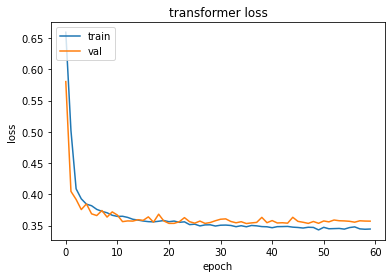

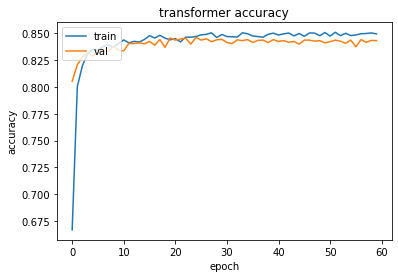


Test confusion matrix :
      0     1
0  1733   326
1   276  1665

Test Accuracy score:  0.8495
Test AUC score:  0.9243170118795883
Test Precision score:  0.8362631843294827
Test Recall score:  0.8578052550231839
Test Specificity score:  0.8416707139388052
Test F1_score:  0.8468972533062055 


Test confusion matrix :
      0     1
0  1724   335
1   382  1559

Test Accuracy score:  0.82075
Test AUC score:  0.9006117573818616
Test Precision score:  0.8231256599788807
Test Recall score:  0.8031942297784647
Test Specificity score:  0.8372996600291404
Test F1_score:  0.8130378096479792 



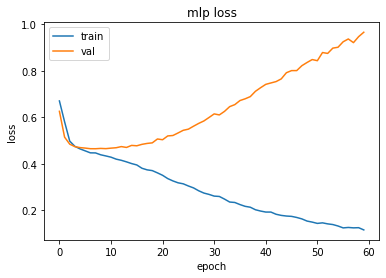

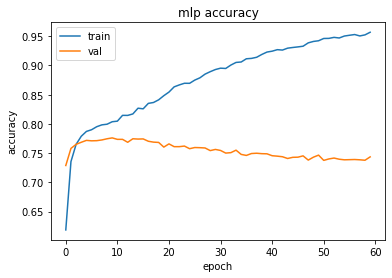


Test confusion matrix :
      0     1
0  1553   447
1   399  1601

Test Accuracy score:  0.7885
Test AUC score:  0.8657509999999999
Test Precision score:  0.78173828125
Test Recall score:  0.8005
Test Specificity score:  0.7765
Test F1_score:  0.79100790513834 


Test confusion matrix :
      0     1
0  1532   468
1   531  1469

Test Accuracy score:  0.75025
Test AUC score:  0.8308766249999999
Test Precision score:  0.7583892617449665
Test Recall score:  0.7345
Test Specificity score:  0.766
Test F1_score:  0.746253492506985 



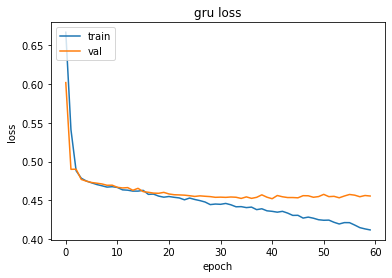

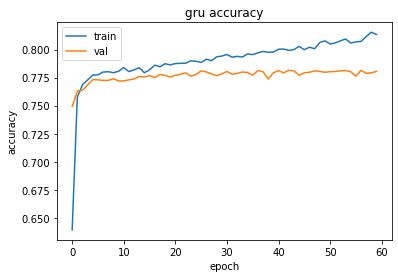


Test confusion matrix :
      0     1
0  1541   459
1   361  1639

Test Accuracy score:  0.795
Test AUC score:  0.8711629999999999
Test Precision score:  0.7812202097235462
Test Recall score:  0.8195
Test Specificity score:  0.7705
Test F1_score:  0.7999023914104442 


Test confusion matrix :
      0     1
0  1521   479
1   474  1526

Test Accuracy score:  0.76175
Test AUC score:  0.837803125
Test Precision score:  0.7610972568578553
Test Recall score:  0.763
Test Specificity score:  0.7605
Test F1_score:  0.7620474406991261 



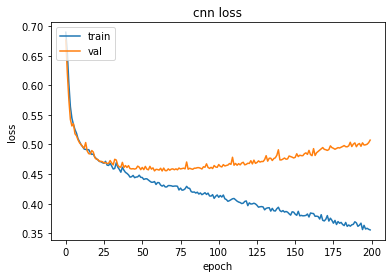

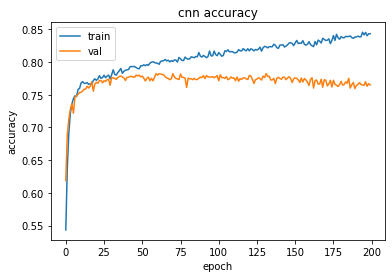


Test confusion matrix :
      0     1
0  1526   474
1   367  1633

Test Accuracy score:  0.78975
Test AUC score:  0.867414
Test Precision score:  0.7750355956336022
Test Recall score:  0.8165
Test Specificity score:  0.763
Test F1_score:  0.7952276600925249 


Test confusion matrix :
      0     1
0  1530   470
1   550  1450

Test Accuracy score:  0.745
Test AUC score:  0.82678175
Test Precision score:  0.7552083333333334
Test Recall score:  0.725
Test Specificity score:  0.765
Test F1_score:  0.7397959183673469 



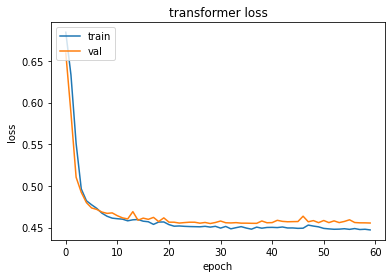

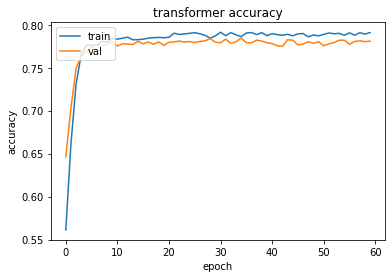


Test confusion matrix :
      0     1
0  1527   473
1   372  1628

Test Accuracy score:  0.78875
Test AUC score:  0.87035375
Test Precision score:  0.774869109947644
Test Recall score:  0.814
Test Specificity score:  0.7635
Test F1_score:  0.7939526944647647 


Test confusion matrix :
      0     1
0  1528   472
1   480  1520

Test Accuracy score:  0.762
Test AUC score:  0.8374535000000001
Test Precision score:  0.7630522088353414
Test Recall score:  0.76
Test Specificity score:  0.764
Test F1_score:  0.7615230460921845 



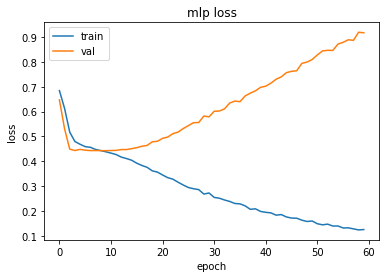

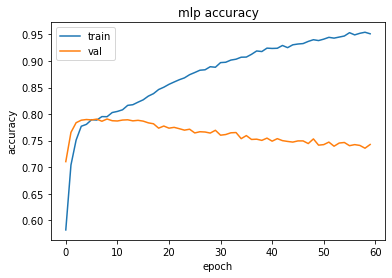


Test confusion matrix :
      0     1
0  1410   556
1   333  1701

Test Accuracy score:  0.77775
Test AUC score:  0.8577331348759791
Test Precision score:  0.7536552946389012
Test Recall score:  0.8362831858407079
Test Specificity score:  0.7171922685656155
Test F1_score:  0.7928221859706364 


Test confusion matrix :
      0     1
0  1420   546
1   457  1577

Test Accuracy score:  0.74925
Test AUC score:  0.820901365494628
Test Precision score:  0.7428167687235044
Test Recall score:  0.7753195673549655
Test Specificity score:  0.7222787385554426
Test F1_score:  0.7587202309357709 



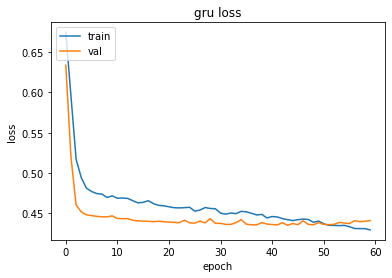

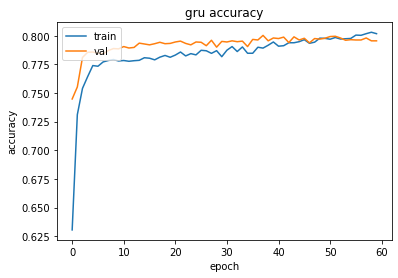


Test confusion matrix :
      0     1
0  1417   549
1   339  1695

Test Accuracy score:  0.778
Test AUC score:  0.8602055994182319
Test Precision score:  0.7553475935828877
Test Recall score:  0.8333333333333334
Test Specificity score:  0.7207527975584944
Test F1_score:  0.7924263674614306 


Test confusion matrix :
      0     1
0  1437   529
1   472  1562

Test Accuracy score:  0.74975
Test AUC score:  0.8308743726937083
Test Precision score:  0.74701099952176
Test Recall score:  0.767944936086529
Test Specificity score:  0.7309257375381485
Test F1_score:  0.7573333333333333 



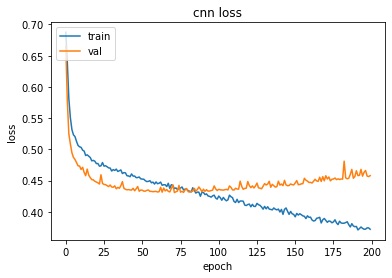

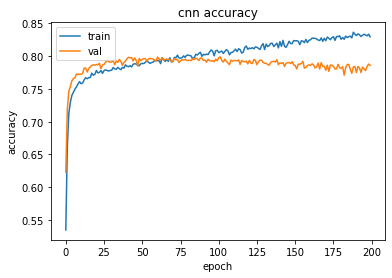


Test confusion matrix :
      0     1
0  1503   463
1   385  1649

Test Accuracy score:  0.788
Test AUC score:  0.862058509909364
Test Precision score:  0.7807765151515151
Test Recall score:  0.8107177974434612
Test Specificity score:  0.7644964394710071
Test F1_score:  0.7954655089242644 


Test confusion matrix :
      0     1
0  1507   459
1   599  1435

Test Accuracy score:  0.7355
Test AUC score:  0.8215251707743538
Test Precision score:  0.7576557550158395
Test Recall score:  0.7055063913470994
Test Specificity score:  0.7665310274669379
Test F1_score:  0.7306517311608962 



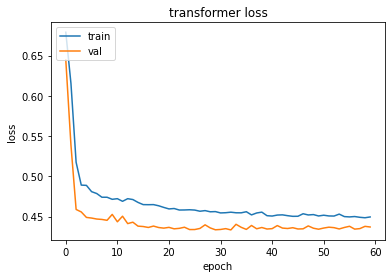

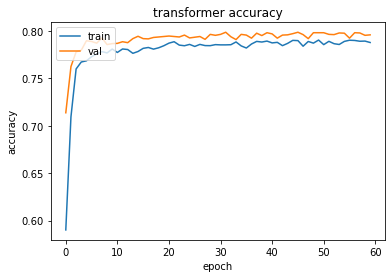


Test confusion matrix :
      0     1
0  1430   536
1   359  1675

Test Accuracy score:  0.77625
Test AUC score:  0.860143831567323
Test Precision score:  0.7575757575757576
Test Recall score:  0.8235004916420846
Test Specificity score:  0.7273652085452695
Test F1_score:  0.7891637220259128 


Test confusion matrix :
      0     1
0  1459   507
1   500  1534

Test Accuracy score:  0.74825
Test AUC score:  0.8275650412969348
Test Precision score:  0.7515923566878981
Test Recall score:  0.7541789577187807
Test Specificity score:  0.742115971515768
Test F1_score:  0.7528834355828221 



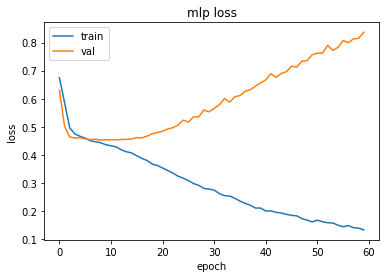

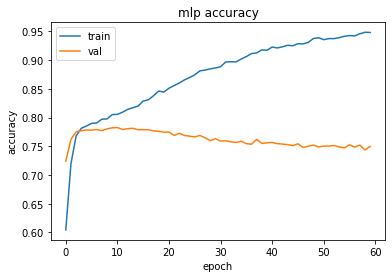


Test confusion matrix :
      0     1
0  1508   525
1   330  1637

Test Accuracy score:  0.78625
Test AUC score:  0.8634770816354751
Test Precision score:  0.7571692876965772
Test Recall score:  0.8322318251143874
Test Specificity score:  0.7417609444171176
Test F1_score:  0.7929280697505449 


Test confusion matrix :
      0     1
0  1504   529
1   465  1502

Test Accuracy score:  0.7515
Test AUC score:  0.8295085837119156
Test Precision score:  0.7395371738060069
Test Recall score:  0.7635993899339095
Test Specificity score:  0.7397934087555337
Test F1_score:  0.751375687843922 



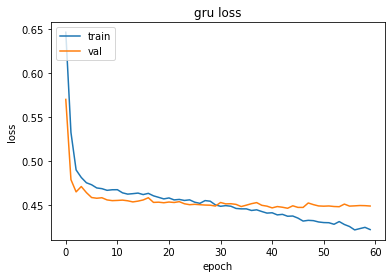

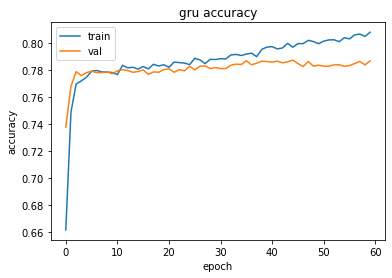


Test confusion matrix :
      0     1
0  1557   476
1   364  1603

Test Accuracy score:  0.79
Test AUC score:  0.869381189028713
Test Precision score:  0.7710437710437711
Test Recall score:  0.8149466192170819
Test Specificity score:  0.76586325627152
Test F1_score:  0.7923875432525952 


Test confusion matrix :
      0     1
0  1563   470
1   498  1469

Test Accuracy score:  0.758
Test AUC score:  0.8348135279829934
Test Precision score:  0.7576070139247034
Test Recall score:  0.7468225724453482
Test Specificity score:  0.7688145597638957
Test F1_score:  0.7521761392729135 



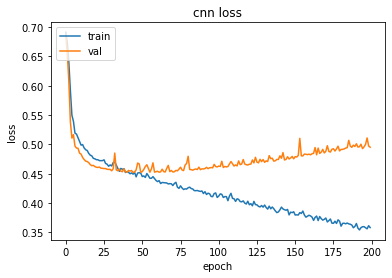

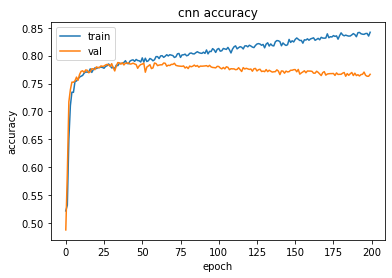


Test confusion matrix :
      0     1
0  1569   464
1   393  1574

Test Accuracy score:  0.78575
Test AUC score:  0.8683224007736106
Test Precision score:  0.7723258096172718
Test Recall score:  0.8002033553634977
Test Specificity score:  0.7717658632562715
Test F1_score:  0.7860174781523096 


Test confusion matrix :
      0     1
0  1578   455
1   574  1393

Test Accuracy score:  0.74275
Test AUC score:  0.828933177057454
Test Precision score:  0.7537878787878788
Test Recall score:  0.708185053380783
Test Specificity score:  0.7761928184948352
Test F1_score:  0.7302752293577982 



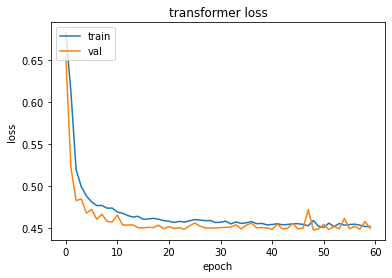

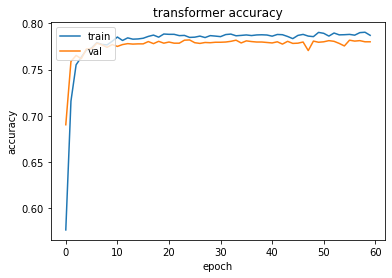


Test confusion matrix :
      0     1
0  1538   495
1   355  1612

Test Accuracy score:  0.7875
Test AUC score:  0.8678512725089406
Test Precision score:  0.7650688182249644
Test Recall score:  0.8195221148957804
Test Specificity score:  0.7565174618789966
Test F1_score:  0.7913598429062347 


Test confusion matrix :
      0     1
0  1562   471
1   483  1484

Test Accuracy score:  0.7615
Test AUC score:  0.8363546975664125
Test Precision score:  0.759079283887468
Test Recall score:  0.7544483985765125
Test Specificity score:  0.7683226758484998
Test F1_score:  0.7567567567567568 



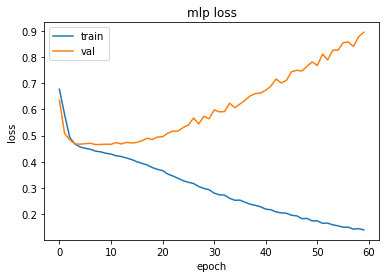

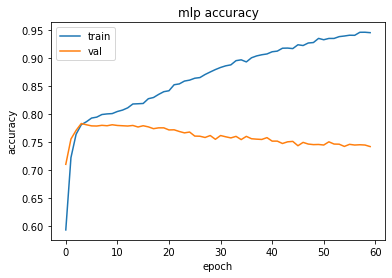


Test confusion matrix :
      0     1
0  1430   560
1   331  1679

Test Accuracy score:  0.77725
Test AUC score:  0.859774744368609
Test Precision score:  0.7498883430102724
Test Recall score:  0.8353233830845771
Test Specificity score:  0.7185929648241206
Test F1_score:  0.7903036008472581 


Test confusion matrix :
      0     1
0  1447   543
1   435  1575

Test Accuracy score:  0.7555
Test AUC score:  0.8293691092277308
Test Precision score:  0.7436260623229461
Test Recall score:  0.7835820895522388
Test Specificity score:  0.7271356783919598
Test F1_score:  0.7630813953488372 



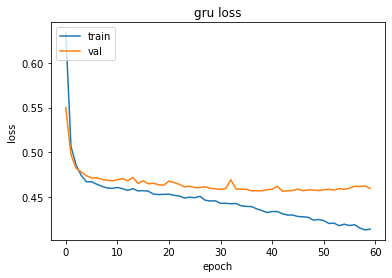

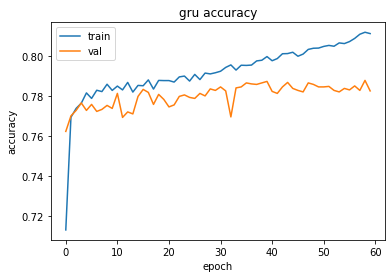


Test confusion matrix :
      0     1
0  1461   529
1   350  1660

Test Accuracy score:  0.78025
Test AUC score:  0.8672051801295031
Test Precision score:  0.758337140246688
Test Recall score:  0.8258706467661692
Test Specificity score:  0.7341708542713568
Test F1_score:  0.790664443915218 


Test confusion matrix :
      0     1
0  1502   488
1   470  1540

Test Accuracy score:  0.7605
Test AUC score:  0.8317782944573615
Test Precision score:  0.7593688362919132
Test Recall score:  0.7661691542288557
Test Specificity score:  0.7547738693467336
Test F1_score:  0.7627538385339278 



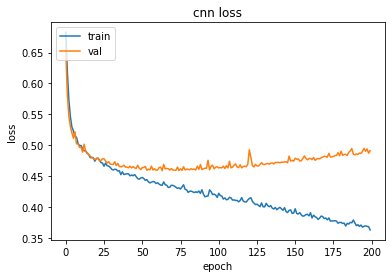

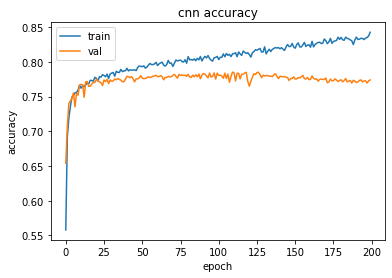


Test confusion matrix :
      0     1
0  1489   501
1   372  1638

Test Accuracy score:  0.78175
Test AUC score:  0.8645768644216105
Test Precision score:  0.7657784011220197
Test Recall score:  0.8149253731343283
Test Specificity score:  0.7482412060301508
Test F1_score:  0.7895878524945769 


Test confusion matrix :
      0     1
0  1507   483
1   539  1471

Test Accuracy score:  0.7445
Test AUC score:  0.8209436485912148
Test Precision score:  0.7528147389969294
Test Recall score:  0.7318407960199005
Test Specificity score:  0.757286432160804
Test F1_score:  0.7421796165489404 



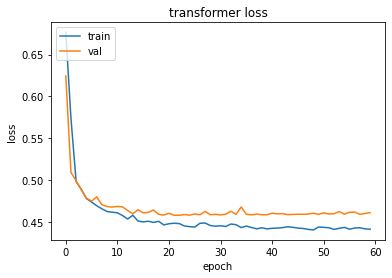

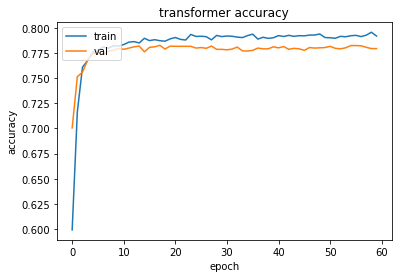


Test confusion matrix :
      0     1
0  1462   528
1   332  1678

Test Accuracy score:  0.785
Test AUC score:  0.8652921323033075
Test Precision score:  0.7606527651858568
Test Recall score:  0.8348258706467662
Test Specificity score:  0.7346733668341708
Test F1_score:  0.7960151802656547 


Test confusion matrix :
      0     1
0  1476   514
1   431  1579

Test Accuracy score:  0.76375
Test AUC score:  0.8340093502337558
Test Precision score:  0.7544194935499283
Test Recall score:  0.7855721393034826
Test Specificity score:  0.7417085427135678
Test F1_score:  0.7696807214233488 



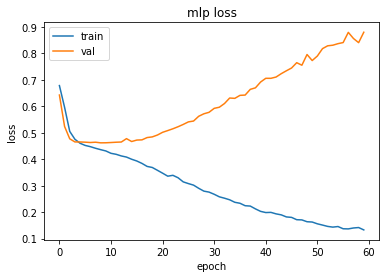

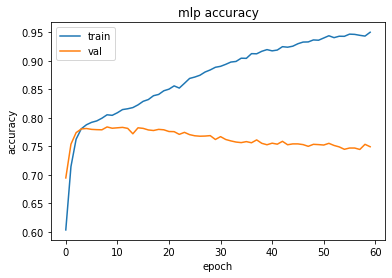


Test confusion matrix :
      0     1
0  1478   505
1   361  1656

Test Accuracy score:  0.7835
Test AUC score:  0.8579667380968276
Test Precision score:  0.7663118926422953
Test Recall score:  0.8210213187902826
Test Specificity score:  0.7453353504790721
Test F1_score:  0.7927237912876975 


Test confusion matrix :
      0     1
0  1447   536
1   488  1529

Test Accuracy score:  0.744
Test AUC score:  0.8218256269015437
Test Precision score:  0.7404358353510896
Test Recall score:  0.7580565195835399
Test Specificity score:  0.72970247100353
Test F1_score:  0.749142577168055 



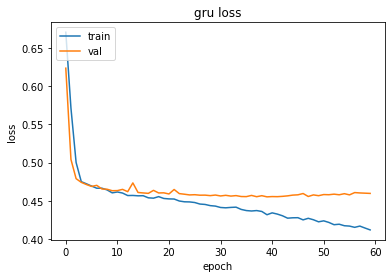

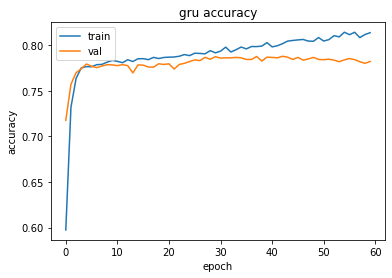


Test confusion matrix :
      0     1
0  1477   506
1   350  1667

Test Accuracy score:  0.786
Test AUC score:  0.865149007015757
Test Precision score:  0.767142199723884
Test Recall score:  0.8264749628160635
Test Specificity score:  0.7448310640443772
Test F1_score:  0.7957040572792363 


Test confusion matrix :
      0     1
0  1473   510
1   480  1537

Test Accuracy score:  0.7525
Test AUC score:  0.8306197622778246
Test Precision score:  0.7508549096238397
Test Recall score:  0.7620228061477442
Test Specificity score:  0.7428139183055976
Test F1_score:  0.7563976377952756 



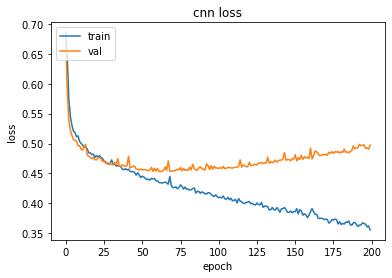

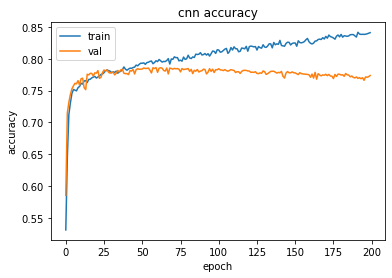


Test confusion matrix :
      0     1
0  1508   475
1   379  1638

Test Accuracy score:  0.7865
Test AUC score:  0.8635328902513205
Test Precision score:  0.77520113582584
Test Recall score:  0.812097174020823
Test Specificity score:  0.7604639435199193
Test F1_score:  0.7932203389830509 


Test confusion matrix :
      0     1
0  1507   476
1   565  1452

Test Accuracy score:  0.73975
Test AUC score:  0.8181636123209902
Test Precision score:  0.7531120331950207
Test Recall score:  0.7198810114030739
Test Specificity score:  0.7599596570852244
Test F1_score:  0.7361216730038023 



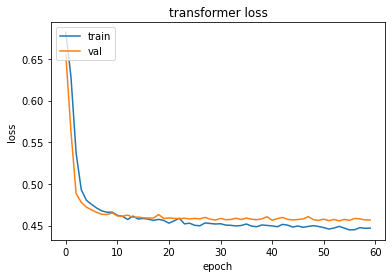

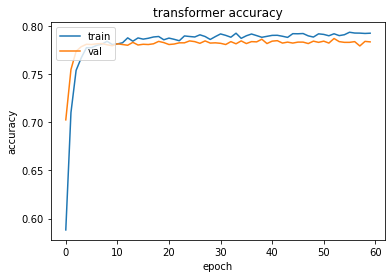


Test confusion matrix :
      0     1
0  1453   530
1   331  1686

Test Accuracy score:  0.78475
Test AUC score:  0.8621992938989842
Test Precision score:  0.7608303249097473
Test Recall score:  0.8358948934060486
Test Specificity score:  0.7327281896116995
Test F1_score:  0.7965981573352233 


Test confusion matrix :
      0     1
0  1434   549
1   447  1570

Test Accuracy score:  0.751
Test AUC score:  0.8258326664101482
Test Precision score:  0.7409155261915998
Test Recall score:  0.7783837382250868
Test Specificity score:  0.7231467473524962
Test F1_score:  0.7591876208897486 



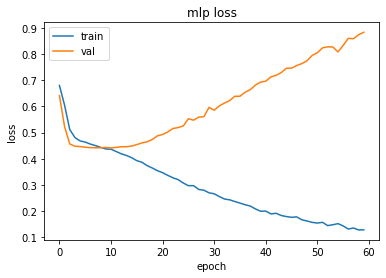

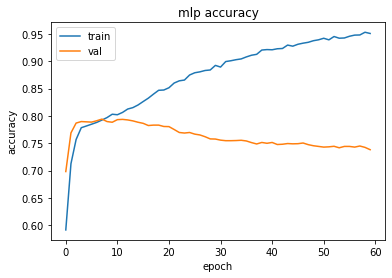


Test confusion matrix :
      0     1
0  1499   510
1   338  1653

Test Accuracy score:  0.788
Test AUC score:  0.861657698568396
Test Precision score:  0.7642163661581137
Test Recall score:  0.8302360622802611
Test Specificity score:  0.7461423593827775
Test F1_score:  0.7958594126143476 


Test confusion matrix :
      0     1
0  1472   537
1   473  1518

Test Accuracy score:  0.7475
Test AUC score:  0.8195628461476345
Test Precision score:  0.7386861313868613
Test Recall score:  0.7624309392265194
Test Specificity score:  0.732702837232454
Test F1_score:  0.750370736529906 



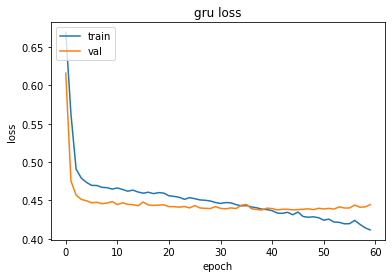

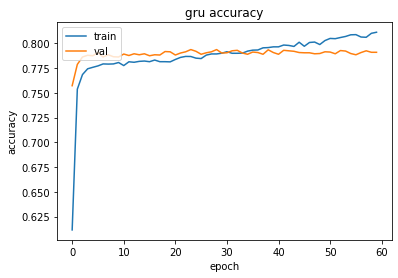


Test confusion matrix :
      0     1
0  1472   537
1   310  1681

Test Accuracy score:  0.78825
Test AUC score:  0.8643205024901754
Test Precision score:  0.7578899909828675
Test Recall score:  0.844299347061778
Test Specificity score:  0.732702837232454
Test F1_score:  0.7987645521501544 


Test confusion matrix :
      0     1
0  1456   553
1   450  1541

Test Accuracy score:  0.74925
Test AUC score:  0.8258782240340365
Test Precision score:  0.7359121298949379
Test Recall score:  0.7739829231541939
Test Specificity score:  0.7247386759581882
Test F1_score:  0.7544675642594859 



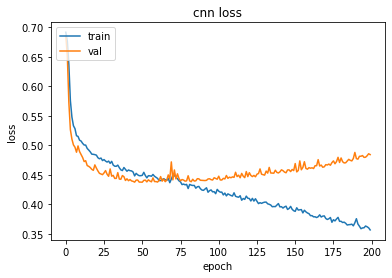

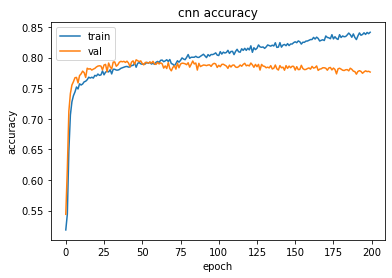


Test confusion matrix :
      0     1
0  1560   449
1   420  1571

Test Accuracy score:  0.78275
Test AUC score:  0.8671449346849274
Test Precision score:  0.7777227722772277
Test Recall score:  0.7890507282772476
Test Specificity score:  0.7765057242409159
Test F1_score:  0.7833457990526054 


Test confusion matrix :
      0     1
0  1538   471
1   603  1388

Test Accuracy score:  0.7315
Test AUC score:  0.8181480674983669
Test Precision score:  0.7466379774072082
Test Recall score:  0.6971371170266197
Test Specificity score:  0.7655550024888004
Test F1_score:  0.721038961038961 



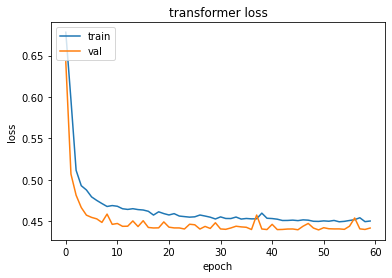

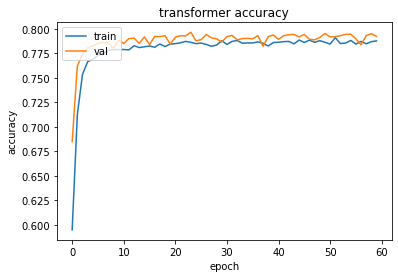


Test confusion matrix :
      0     1
0  1499   510
1   334  1657

Test Accuracy score:  0.789
Test AUC score:  0.8637583661069137
Test Precision score:  0.7646515920627596
Test Recall score:  0.832245102963335
Test Specificity score:  0.7461423593827775
Test F1_score:  0.7970177970177971 


Test confusion matrix :
      0     1
0  1488   521
1   467  1524

Test Accuracy score:  0.753
Test AUC score:  0.8264609858349632
Test Precision score:  0.7452322738386308
Test Recall score:  0.7654445002511301
Test Specificity score:  0.7406669985067198
Test F1_score:  0.755203171456888 



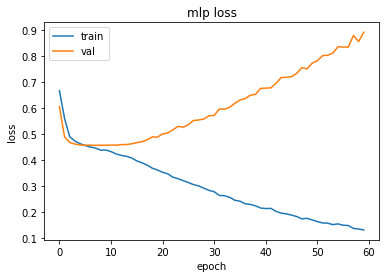

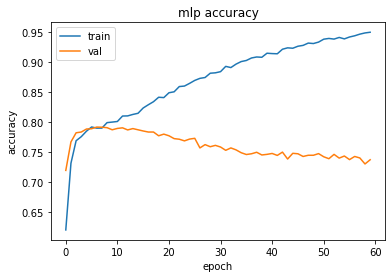


Test confusion matrix :
      0     1
0  1487   513
1   356  1644

Test Accuracy score:  0.78275
Test AUC score:  0.861882625
Test Precision score:  0.7621696801112656
Test Recall score:  0.822
Test Specificity score:  0.7435
Test F1_score:  0.790955015636276 


Test confusion matrix :
      0     1
0  1471   529
1   466  1534

Test Accuracy score:  0.75125
Test AUC score:  0.823646375
Test Precision score:  0.7435773145904023
Test Recall score:  0.767
Test Specificity score:  0.7355
Test F1_score:  0.7551070637460006 



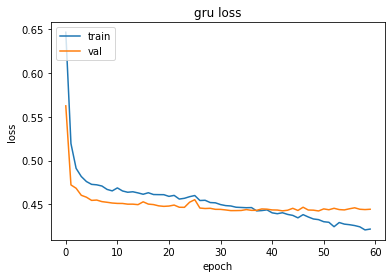

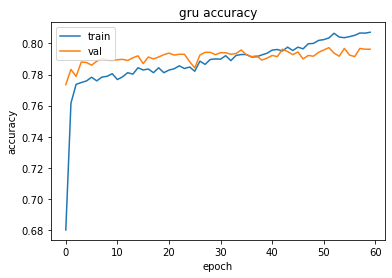


Test confusion matrix :
      0     1
0  1506   494
1   344  1656

Test Accuracy score:  0.7905
Test AUC score:  0.8680645
Test Precision score:  0.7702325581395348
Test Recall score:  0.828
Test Specificity score:  0.753
Test F1_score:  0.7980722891566264 


Test confusion matrix :
      0     1
0  1464   536
1   476  1524

Test Accuracy score:  0.747
Test AUC score:  0.8241992499999999
Test Precision score:  0.7398058252427184
Test Recall score:  0.762
Test Specificity score:  0.732
Test F1_score:  0.7507389162561576 



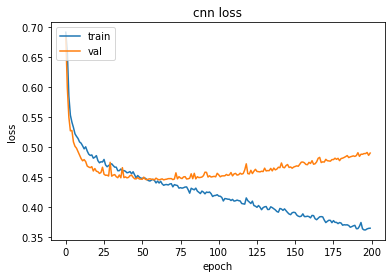

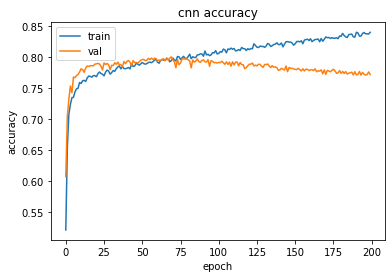


Test confusion matrix :
      0     1
0  1533   467
1   380  1620

Test Accuracy score:  0.78825
Test AUC score:  0.8687147499999999
Test Precision score:  0.776233828461907
Test Recall score:  0.81
Test Specificity score:  0.7665
Test F1_score:  0.7927575238561293 


Test confusion matrix :
      0     1
0  1503   497
1   525  1475

Test Accuracy score:  0.7445
Test AUC score:  0.819688125
Test Precision score:  0.7479716024340771
Test Recall score:  0.7375
Test Specificity score:  0.7515
Test F1_score:  0.7426988922457199 



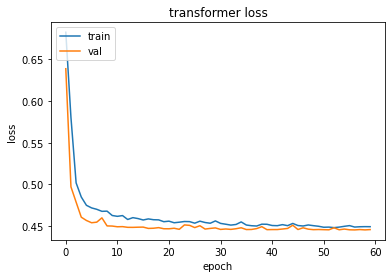

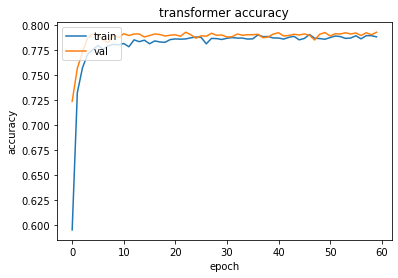


Test confusion matrix :
      0     1
0  1498   502
1   339  1661

Test Accuracy score:  0.78975
Test AUC score:  0.866882
Test Precision score:  0.7679149329634767
Test Recall score:  0.8305
Test Specificity score:  0.749
Test F1_score:  0.7979822243574346 


Test confusion matrix :
      0     1
0  1459   541
1   452  1548

Test Accuracy score:  0.75175
Test AUC score:  0.832057625
Test Precision score:  0.7410244135950216
Test Recall score:  0.774
Test Specificity score:  0.7295
Test F1_score:  0.7571533382245047 



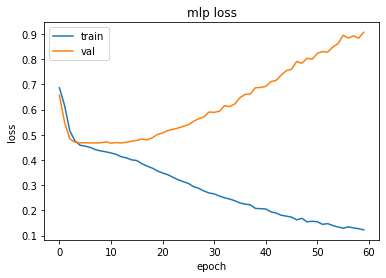

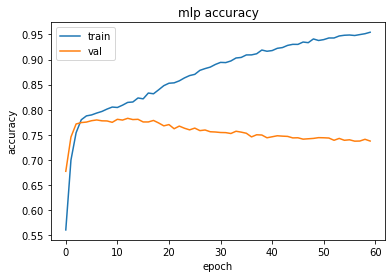


Test confusion matrix :
      0     1
0  1515   570
1   305  1610

Test Accuracy score:  0.78125
Test AUC score:  0.8645136527853434
Test Precision score:  0.7385321100917431
Test Recall score:  0.8407310704960835
Test Specificity score:  0.7266187050359713
Test F1_score:  0.7863247863247863 


Test confusion matrix :
      0     1
0  1519   566
1   447  1468

Test Accuracy score:  0.74675
Test AUC score:  0.8188874905297694
Test Precision score:  0.7217305801376598
Test Recall score:  0.766579634464752
Test Specificity score:  0.728537170263789
Test F1_score:  0.7434793618637631 



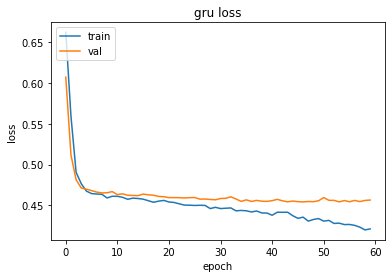

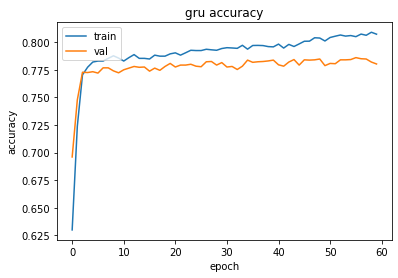


Test confusion matrix :
      0     1
0  1573   512
1   335  1580

Test Accuracy score:  0.78825
Test AUC score:  0.8706543694548277
Test Precision score:  0.7552581261950286
Test Recall score:  0.825065274151436
Test Specificity score:  0.7544364508393285
Test F1_score:  0.7886199151484901 


Test confusion matrix :
      0     1
0  1569   516
1   467  1448

Test Accuracy score:  0.75425
Test AUC score:  0.8300542855532806
Test Precision score:  0.7372708757637475
Test Recall score:  0.7561357702349869
Test Specificity score:  0.7525179856115108
Test F1_score:  0.7465841711781388 



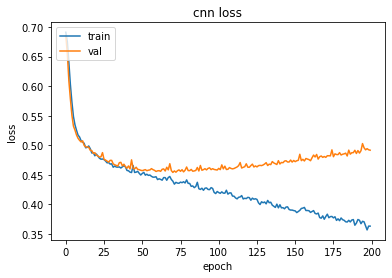

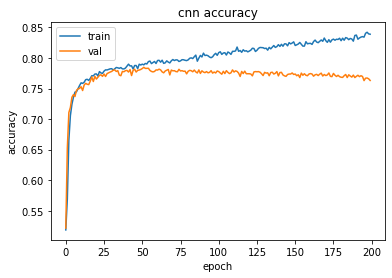


Test confusion matrix :
      0     1
0  1575   510
1   344  1571

Test Accuracy score:  0.7865
Test AUC score:  0.8691387568796138
Test Precision score:  0.754925516578568
Test Recall score:  0.8203655352480418
Test Specificity score:  0.7553956834532374
Test F1_score:  0.7862862862862863 


Test confusion matrix :
      0     1
0  1562   523
1   521  1394

Test Accuracy score:  0.739
Test AUC score:  0.8185116867341635
Test Precision score:  0.7271778821074596
Test Recall score:  0.7279373368146214
Test Specificity score:  0.7491606714628297
Test F1_score:  0.7275574112734864 



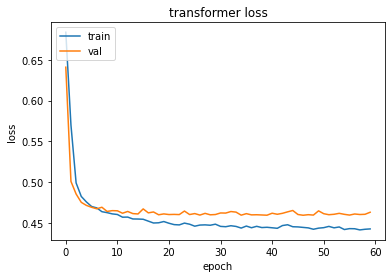

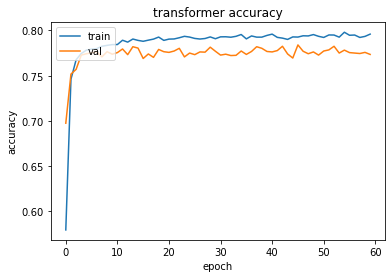


Test confusion matrix :
      0     1
0  1558   527
1   322  1593

Test Accuracy score:  0.78775
Test AUC score:  0.8675055569121726
Test Precision score:  0.7514150943396226
Test Recall score:  0.8318537859007833
Test Specificity score:  0.747242206235012
Test F1_score:  0.7895910780669145 


Test confusion matrix :
      0     1
0  1542   543
1   459  1456

Test Accuracy score:  0.7495
Test AUC score:  0.8249220153902989
Test Precision score:  0.7283641820910455
Test Recall score:  0.760313315926893
Test Specificity score:  0.739568345323741
Test F1_score:  0.7439959121103731 



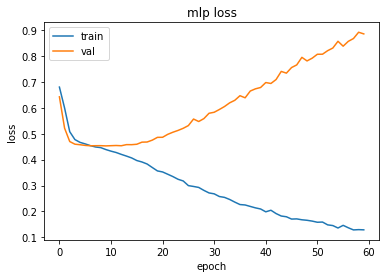

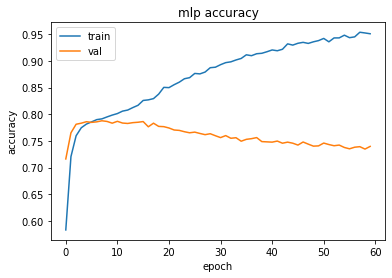


Test confusion matrix :
      0     1
0  1500   477
1   369  1654

Test Accuracy score:  0.7885
Test AUC score:  0.8687598934959149
Test Precision score:  0.7761614265603003
Test Recall score:  0.8175976272862086
Test Specificity score:  0.7587253414264037
Test F1_score:  0.796340876263842 


Test confusion matrix :
      0     1
0  1492   485
1   486  1537

Test Accuracy score:  0.75725
Test AUC score:  0.8325751080580407
Test Precision score:  0.7601384767556875
Test Recall score:  0.7597627286208601
Test Specificity score:  0.7546788062721295
Test F1_score:  0.7599505562422744 



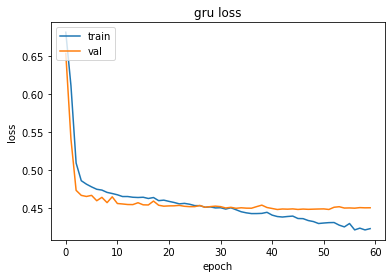

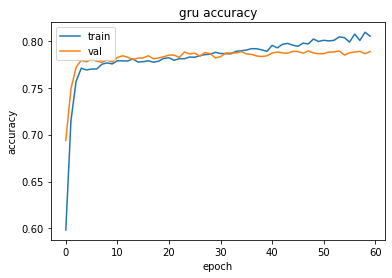


Test confusion matrix :
      0     1
0  1508   469
1   330  1693

Test Accuracy score:  0.80025
Test AUC score:  0.8743088773490293
Test Precision score:  0.7830712303422757
Test Recall score:  0.8368759268413247
Test Specificity score:  0.7627718765806778
Test F1_score:  0.8090800477897252 


Test confusion matrix :
      0     1
0  1495   482
1   496  1527

Test Accuracy score:  0.7555
Test AUC score:  0.8353592262576726
Test Precision score:  0.7600796416127427
Test Recall score:  0.754819574888779
Test Specificity score:  0.7561962569549823
Test F1_score:  0.7574404761904762 



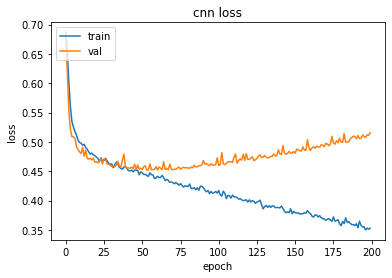

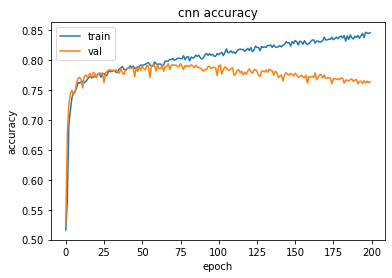


Test confusion matrix :
      0     1
0  1568   409
1   399  1624

Test Accuracy score:  0.798
Test AUC score:  0.8753852697019181
Test Precision score:  0.7988194786030497
Test Recall score:  0.8027681660899654
Test Specificity score:  0.7931208902377339
Test F1_score:  0.8007889546351085 


Test confusion matrix :
      0     1
0  1572   405
1   597  1426

Test Accuracy score:  0.7495
Test AUC score:  0.8321853065067855
Test Precision score:  0.778809393773894
Test Recall score:  0.7048937221947602
Test Specificity score:  0.795144157814871
Test F1_score:  0.7400103788271924 



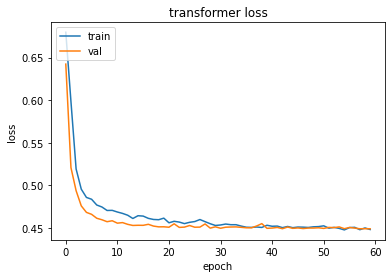

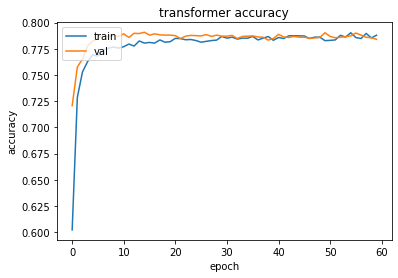


Test confusion matrix :
      0     1
0  1511   466
1   346  1677

Test Accuracy score:  0.797
Test AUC score:  0.8725888998820095
Test Precision score:  0.782547830144657
Test Recall score:  0.828966880869995
Test Specificity score:  0.7642893272635306
Test F1_score:  0.8050888142102736 


Test confusion matrix :
      0     1
0  1508   469
1   478  1545

Test Accuracy score:  0.76325
Test AUC score:  0.8382051026248221
Test Precision score:  0.7671300893743793
Test Recall score:  0.7637172516065249
Test Specificity score:  0.7627718765806778
Test F1_score:  0.765419866237305 



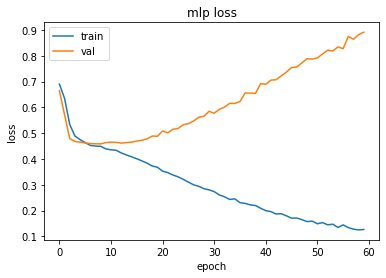

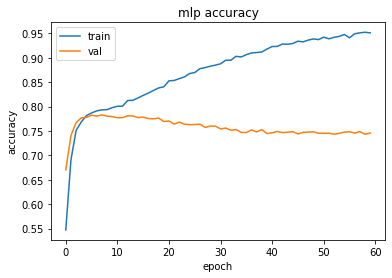


Test confusion matrix :
      0     1
0  1549   510
1   343  1598

Test Accuracy score:  0.78675
Test AUC score:  0.8733998261987493
Test Precision score:  0.7580645161290323
Test Recall score:  0.8232869654817104
Test Specificity score:  0.7523069451189898
Test F1_score:  0.7893306989380094 


Test confusion matrix :
      0     1
0  1559   500
1   448  1493

Test Accuracy score:  0.763
Test AUC score:  0.8378186116467856
Test Precision score:  0.7491219267436026
Test Recall score:  0.7691911385883565
Test Specificity score:  0.7571636716852841
Test F1_score:  0.759023894255211 



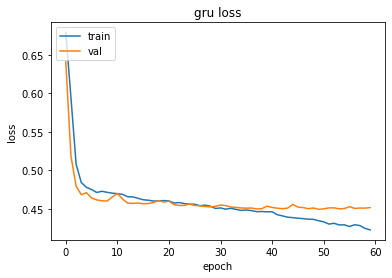

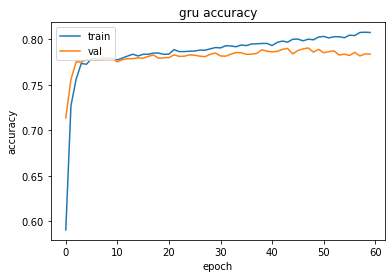


Test confusion matrix :
      0     1
0  1570   489
1   363  1578

Test Accuracy score:  0.787
Test AUC score:  0.8721167095665002
Test Precision score:  0.7634252539912917
Test Recall score:  0.8129829984544049
Test Specificity score:  0.7625060709082079
Test F1_score:  0.7874251497005987 


Test confusion matrix :
      0     1
0  1583   476
1   448  1493

Test Accuracy score:  0.769
Test AUC score:  0.8395533713213925
Test Precision score:  0.7582529202640934
Test Recall score:  0.7691911385883565
Test Specificity score:  0.7688198154443905
Test F1_score:  0.7636828644501278 



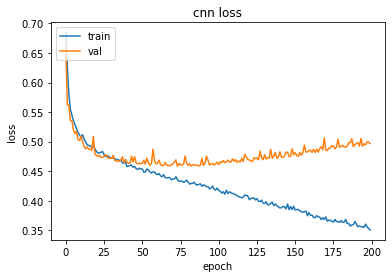

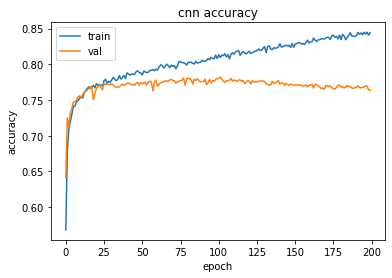


Test confusion matrix :
      0     1
0  1642   417
1   413  1528

Test Accuracy score:  0.7925
Test AUC score:  0.8794500914420774
Test Precision score:  0.7856041131105398
Test Recall score:  0.7872230808861411
Test Specificity score:  0.797474502185527
Test F1_score:  0.78641276376737 


Test confusion matrix :
      0     1
0  1639   420
1   591  1350

Test Accuracy score:  0.74725
Test AUC score:  0.8333262021274014
Test Precision score:  0.7627118644067796
Test Recall score:  0.6955177743431221
Test Specificity score:  0.7960174842156387
Test F1_score:  0.7275666936135813 



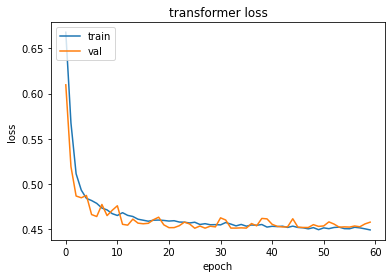

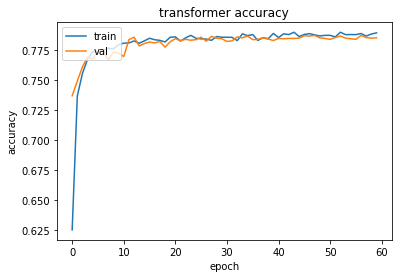


Test confusion matrix :
      0     1
0  1576   483
1   358  1583

Test Accuracy score:  0.78975
Test AUC score:  0.8747672662134222
Test Precision score:  0.7662149080348499
Test Recall score:  0.8155589902112313
Test Specificity score:  0.7654201068479844
Test F1_score:  0.7901172947342152 


Test confusion matrix :
      0     1
0  1578   481
1   447  1494

Test Accuracy score:  0.768
Test AUC score:  0.843994361092741
Test Precision score:  0.7564556962025316
Test Recall score:  0.7697063369397218
Test Specificity score:  0.7663914521612433
Test F1_score:  0.763023493360572 



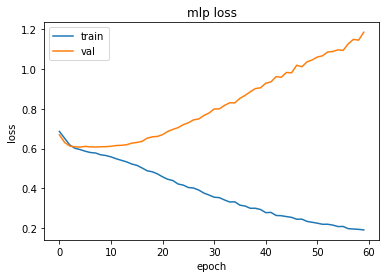

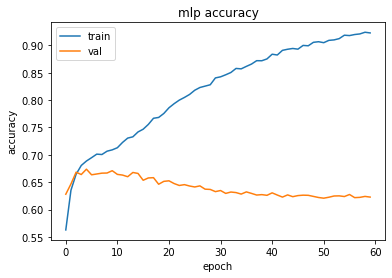


Test confusion matrix :
      0     1
0  1356   644
1   596  1404

Test Accuracy score:  0.69
Test AUC score:  0.74942475
Test Precision score:  0.685546875
Test Recall score:  0.702
Test Specificity score:  0.678
Test F1_score:  0.6936758893280632 


Test confusion matrix :
      0     1
0  1353   647
1   806  1194

Test Accuracy score:  0.63675
Test AUC score:  0.6855395
Test Precision score:  0.6485605649103748
Test Recall score:  0.597
Test Specificity score:  0.6765
Test F1_score:  0.6217130955480344 



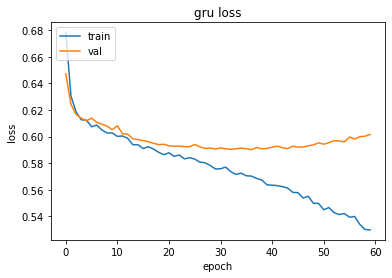

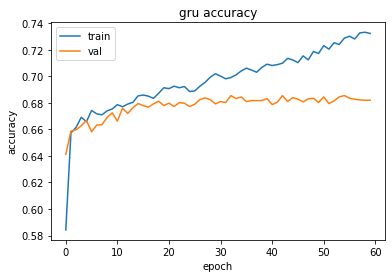


Test confusion matrix :
      0     1
0  1329   671
1   540  1460

Test Accuracy score:  0.69725
Test AUC score:  0.753799625
Test Precision score:  0.685124354763022
Test Recall score:  0.73
Test Specificity score:  0.6645
Test F1_score:  0.7068506414911643 


Test confusion matrix :
      0     1
0  1306   694
1   770  1230

Test Accuracy score:  0.634
Test AUC score:  0.6887955000000001
Test Precision score:  0.6392931392931392
Test Recall score:  0.615
Test Specificity score:  0.653
Test F1_score:  0.6269113149847094 



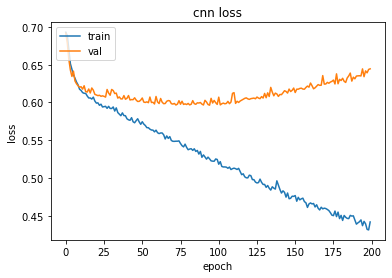

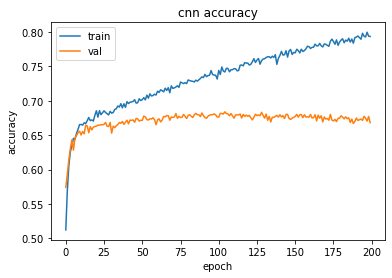


Test confusion matrix :
      0     1
0  1386   614
1   607  1393

Test Accuracy score:  0.69475
Test AUC score:  0.757836625
Test Precision score:  0.6940707523667164
Test Recall score:  0.6965
Test Specificity score:  0.693
Test F1_score:  0.6952832543049663 


Test confusion matrix :
      0     1
0  1396   604
1   922  1078

Test Accuracy score:  0.6185
Test AUC score:  0.6663895000000001
Test Precision score:  0.6409036860879905
Test Recall score:  0.539
Test Specificity score:  0.698
Test F1_score:  0.5855513307984792 



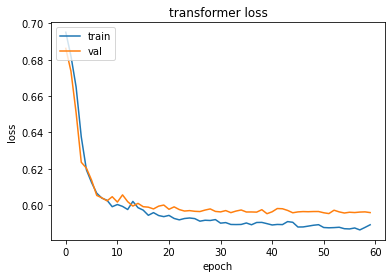

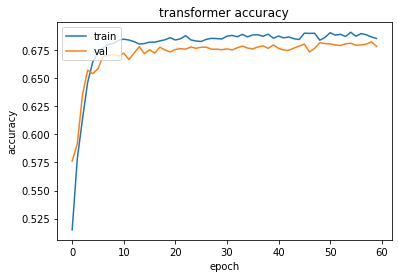


Test confusion matrix :
      0     1
0  1337   663
1   573  1427

Test Accuracy score:  0.691
Test AUC score:  0.75687675
Test Precision score:  0.6827751196172249
Test Recall score:  0.7135
Test Specificity score:  0.6685
Test F1_score:  0.697799511002445 


Test confusion matrix :
      0     1
0  1326   674
1   758  1242

Test Accuracy score:  0.642
Test AUC score:  0.6970085
Test Precision score:  0.6482254697286013
Test Recall score:  0.621
Test Specificity score:  0.663
Test F1_score:  0.6343207354443309 



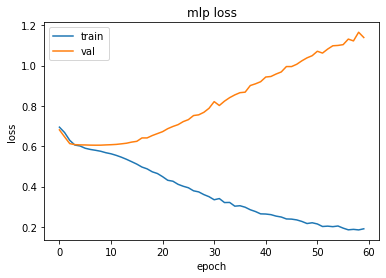

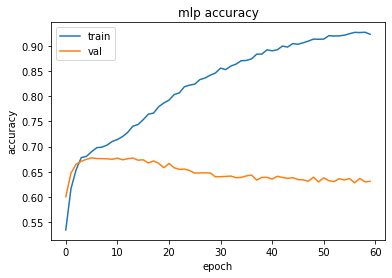


Test confusion matrix :
      0     1
0  1293   673
1   625  1409

Test Accuracy score:  0.6755
Test AUC score:  0.7372835749531614
Test Precision score:  0.6767531219980788
Test Recall score:  0.6927236971484759
Test Specificity score:  0.6576805696846388
Test F1_score:  0.684645286686103 


Test confusion matrix :
      0     1
0  1265   701
1   830  1204

Test Accuracy score:  0.61725
Test AUC score:  0.6618327696704348
Test Precision score:  0.6320209973753281
Test Recall score:  0.591937069813176
Test Specificity score:  0.6434384537131231
Test F1_score:  0.6113226707286112 



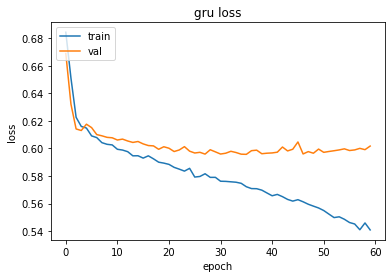

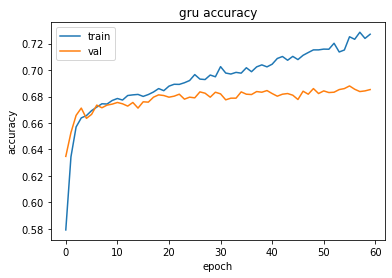


Test confusion matrix :
      0     1
0  1309   657
1   640  1394

Test Accuracy score:  0.67575
Test AUC score:  0.7422317549771884
Test Precision score:  0.6796684544124817
Test Recall score:  0.6853490658800393
Test Specificity score:  0.6658189216683622
Test F1_score:  0.6824969400244798 


Test confusion matrix :
      0     1
0  1326   640
1   880  1154

Test Accuracy score:  0.62
Test AUC score:  0.6746234661817265
Test Precision score:  0.6432552954292085
Test Recall score:  0.567354965585054
Test Specificity score:  0.6744659206510681
Test F1_score:  0.6029258098223614 



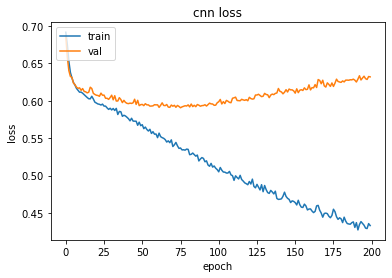

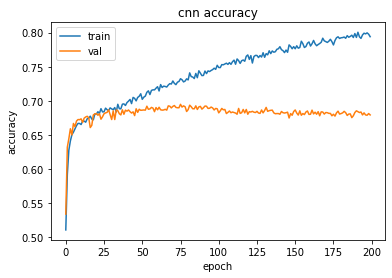


Test confusion matrix :
      0     1
0  1344   622
1   617  1417

Test Accuracy score:  0.69025
Test AUC score:  0.7544942988523684
Test Precision score:  0.6949485041687101
Test Recall score:  0.6966568338249755
Test Specificity score:  0.6836215666327569
Test F1_score:  0.6958016204272035 


Test confusion matrix :
      0     1
0  1344   622
1   982  1052

Test Accuracy score:  0.599
Test AUC score:  0.6465761104959333
Test Precision score:  0.6284348864994026
Test Recall score:  0.5172074729596854
Test Specificity score:  0.6836215666327569
Test F1_score:  0.5674217907227617 



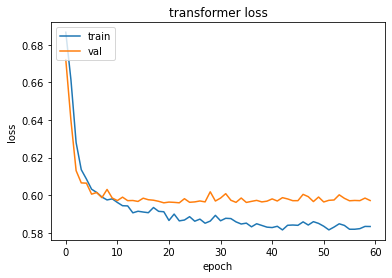

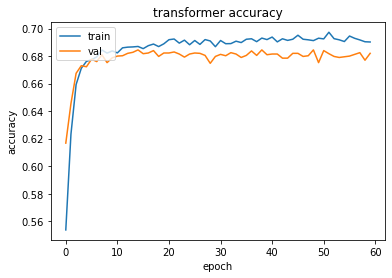


Test confusion matrix :
      0     1
0  1289   677
1   605  1429

Test Accuracy score:  0.6795
Test AUC score:  0.7428486832694648
Test Precision score:  0.6785375118708452
Test Recall score:  0.7025565388397247
Test Specificity score:  0.655645981688708
Test F1_score:  0.6903381642512076 


Test confusion matrix :
      0     1
0  1266   700
1   796  1238

Test Accuracy score:  0.626
Test AUC score:  0.672315549193717
Test Precision score:  0.6388028895768834
Test Recall score:  0.6086529006882989
Test Specificity score:  0.6439471007121058
Test F1_score:  0.6233635448136958 



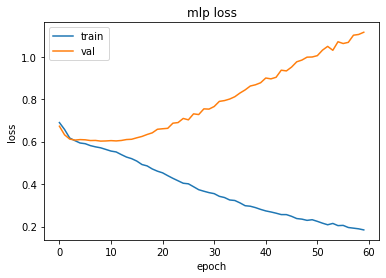

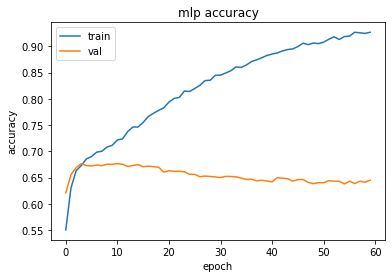


Test confusion matrix :
      0     1
0  1283   750
1   527  1440

Test Accuracy score:  0.68075
Test AUC score:  0.7433088658387246
Test Precision score:  0.6575342465753424
Test Recall score:  0.7320793085917641
Test Specificity score:  0.6310870634530251
Test F1_score:  0.6928073129660812 


Test confusion matrix :
      0     1
0  1307   726
1   734  1233

Test Accuracy score:  0.635
Test AUC score:  0.6841014966324581
Test Precision score:  0.6294027565084227
Test Recall score:  0.6268429079816981
Test Specificity score:  0.6428922774225283
Test F1_score:  0.6281202241467142 



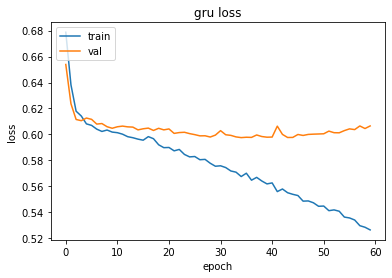

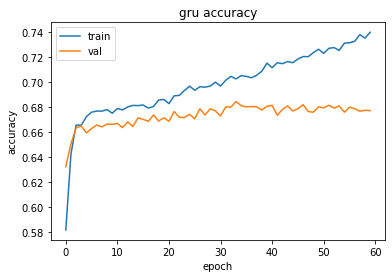


Test confusion matrix :
      0     1
0  1346   687
1   561  1406

Test Accuracy score:  0.688
Test AUC score:  0.7514228248640693
Test Precision score:  0.6717630195891066
Test Recall score:  0.7147941026944585
Test Specificity score:  0.6620757501229709
Test F1_score:  0.6926108374384237 


Test confusion matrix :
      0     1
0  1372   661
1   806  1161

Test Accuracy score:  0.63325
Test AUC score:  0.6895278489568784
Test Precision score:  0.637211855104281
Test Recall score:  0.5902389425521098
Test Specificity score:  0.6748647319232661
Test F1_score:  0.6128266033254157 



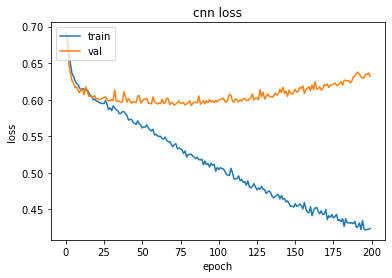

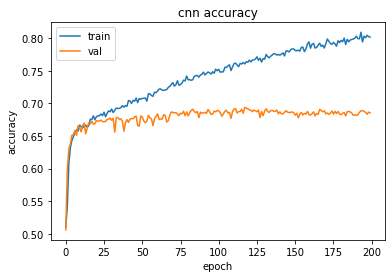


Test confusion matrix :
      0     1
0  1391   642
1   586  1381

Test Accuracy score:  0.693
Test AUC score:  0.7633900829500831
Test Precision score:  0.6826495304003954
Test Recall score:  0.7020843924758515
Test Specificity score:  0.6842105263157895
Test F1_score:  0.6922305764411028 


Test confusion matrix :
      0     1
0  1410   623
1   910  1057

Test Accuracy score:  0.61675
Test AUC score:  0.6701071866815741
Test Precision score:  0.6291666666666667
Test Recall score:  0.5373665480427047
Test Specificity score:  0.6935563207083129
Test F1_score:  0.5796545105566219 



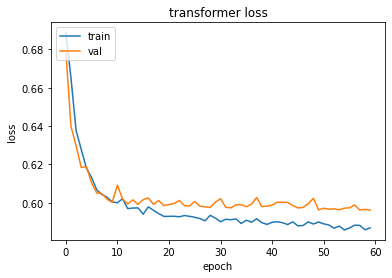

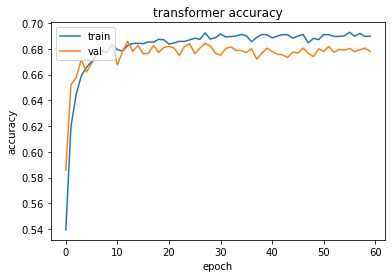


Test confusion matrix :
      0     1
0  1312   721
1   527  1440

Test Accuracy score:  0.688
Test AUC score:  0.7487125870018112
Test Precision score:  0.6663581675150393
Test Recall score:  0.7320793085917641
Test Specificity score:  0.6453516969995081
Test F1_score:  0.6976744186046512 


Test confusion matrix :
      0     1
0  1333   700
1   716  1251

Test Accuracy score:  0.646
Test AUC score:  0.6942967722962576
Test Precision score:  0.6412096360840595
Test Recall score:  0.6359938993390951
Test Specificity score:  0.6556812592228234
Test F1_score:  0.6385911179173048 



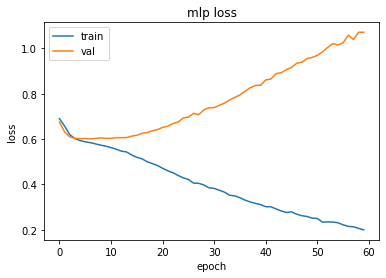

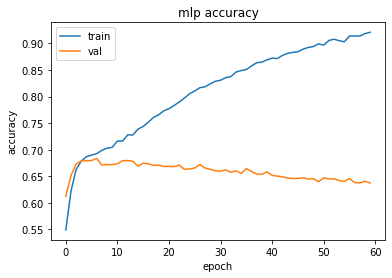


Test confusion matrix :
      0     1
0  1260   730
1   560  1450

Test Accuracy score:  0.6775
Test AUC score:  0.7396529913247831
Test Precision score:  0.6651376146788991
Test Recall score:  0.7213930348258707
Test Specificity score:  0.6331658291457286
Test F1_score:  0.6921241050119332 


Test confusion matrix :
      0     1
0  1291   699
1   800  1210

Test Accuracy score:  0.62525
Test AUC score:  0.6678251956298908
Test Precision score:  0.6338397066526977
Test Recall score:  0.6019900497512438
Test Specificity score:  0.6487437185929649
Test F1_score:  0.6175044654248533 



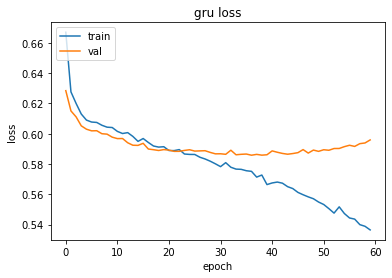

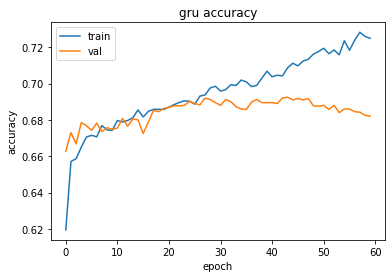


Test confusion matrix :
      0     1
0  1284   706
1   548  1462

Test Accuracy score:  0.6865
Test AUC score:  0.7542588564714119
Test Precision score:  0.6743542435424354
Test Recall score:  0.727363184079602
Test Specificity score:  0.6452261306532663
Test F1_score:  0.6998563906175204 


Test confusion matrix :
      0     1
0  1280   710
1   761  1249

Test Accuracy score:  0.63225
Test AUC score:  0.6839443486087153
Test Precision score:  0.6375701888718734
Test Recall score:  0.6213930348258706
Test Specificity score:  0.6432160804020101
Test F1_score:  0.6293776769967246 



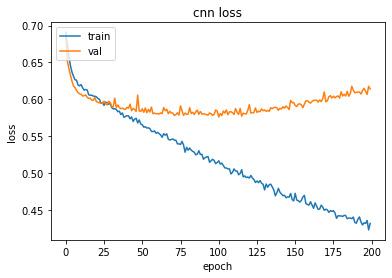

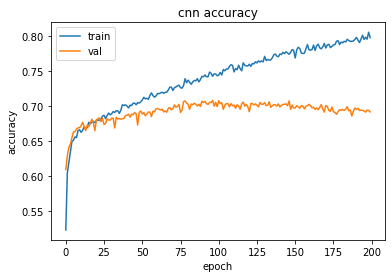


Test confusion matrix :
      0     1
0  1319   671
1   564  1446

Test Accuracy score:  0.69125
Test AUC score:  0.7560349008725218
Test Precision score:  0.6830420406235238
Test Recall score:  0.7194029850746269
Test Specificity score:  0.6628140703517588
Test F1_score:  0.7007511509571116 


Test confusion matrix :
      0     1
0  1327   663
1   964  1046

Test Accuracy score:  0.59325
Test AUC score:  0.6371911797794945
Test Precision score:  0.6120538326506729
Test Recall score:  0.5203980099502488
Test Specificity score:  0.6668341708542713
Test F1_score:  0.5625168055929014 



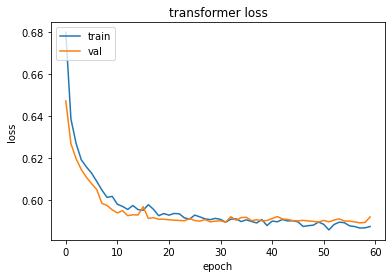

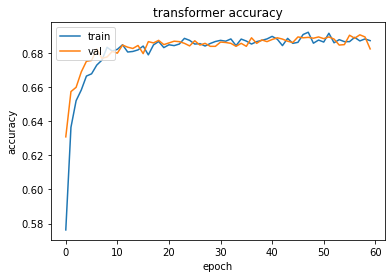


Test confusion matrix :
      0     1
0  1256   734
1   533  1477

Test Accuracy score:  0.68325
Test AUC score:  0.7516347908697716
Test Precision score:  0.6680235187697874
Test Recall score:  0.7348258706467662
Test Specificity score:  0.6311557788944724
Test F1_score:  0.6998341625207297 


Test confusion matrix :
      0     1
0  1272   718
1   789  1221

Test Accuracy score:  0.62325
Test AUC score:  0.6778014450361258
Test Precision score:  0.629706034038164
Test Recall score:  0.6074626865671642
Test Specificity score:  0.6391959798994975
Test F1_score:  0.6183844011142061 



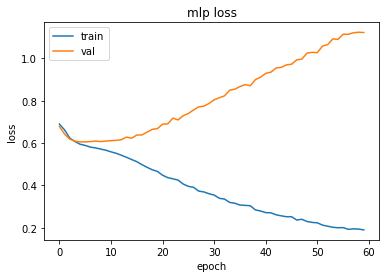

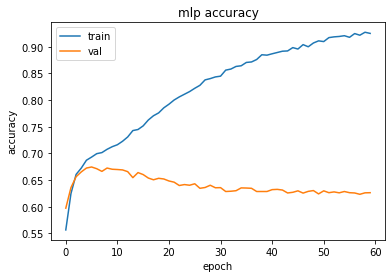


Test confusion matrix :
      0     1
0  1295   688
1   621  1396

Test Accuracy score:  0.67275
Test AUC score:  0.7396056865108503
Test Precision score:  0.6698656429942419
Test Recall score:  0.6921170054536441
Test Specificity score:  0.6530509329299042
Test F1_score:  0.6808095586442332 


Test confusion matrix :
      0     1
0  1286   697
1   803  1214

Test Accuracy score:  0.625
Test AUC score:  0.6753560444742132
Test Precision score:  0.6352694924123495
Test Recall score:  0.601883986117997
Test Specificity score:  0.64851235501765
Test F1_score:  0.6181262729124236 



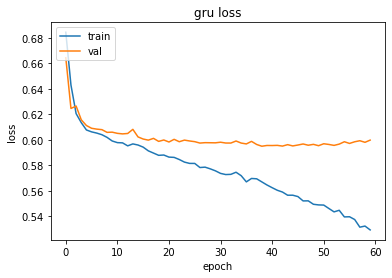

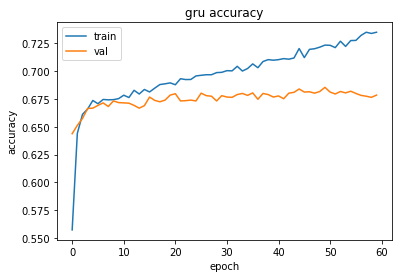


Test confusion matrix :
      0     1
0  1286   697
1   566  1451

Test Accuracy score:  0.68425
Test AUC score:  0.7516065535734957
Test Precision score:  0.675512104283054
Test Recall score:  0.7193852255825484
Test Specificity score:  0.64851235501765
Test F1_score:  0.6967587034813926 


Test confusion matrix :
      0     1
0  1290   693
1   790  1227

Test Accuracy score:  0.62925
Test AUC score:  0.683564262517967
Test Precision score:  0.6390625
Test Recall score:  0.608329201784829
Test Specificity score:  0.6505295007564297
Test F1_score:  0.6233172466344933 



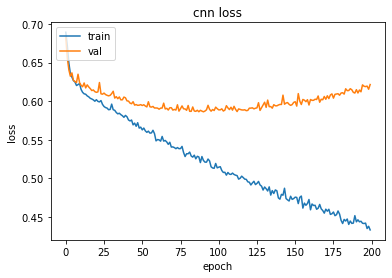

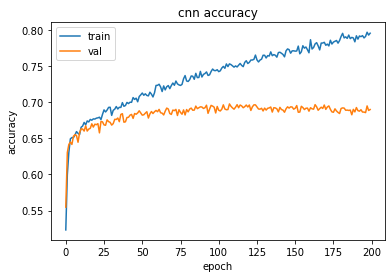


Test confusion matrix :
      0     1
0  1300   683
1   526  1491

Test Accuracy score:  0.69775
Test AUC score:  0.7639584459977233
Test Precision score:  0.6858325666973321
Test Recall score:  0.7392166584035696
Test Specificity score:  0.6555723651033787
Test F1_score:  0.7115246957766642 


Test confusion matrix :
      0     1
0  1281   702
1   878  1139

Test Accuracy score:  0.605
Test AUC score:  0.6463469485670339
Test Precision score:  0.6186854970124932
Test Recall score:  0.564700049578582
Test Specificity score:  0.6459909228441755
Test F1_score:  0.5904613789528254 



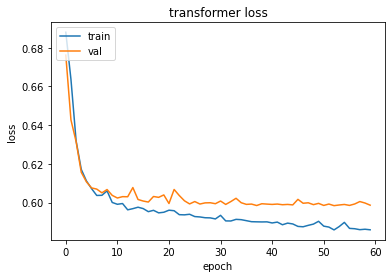

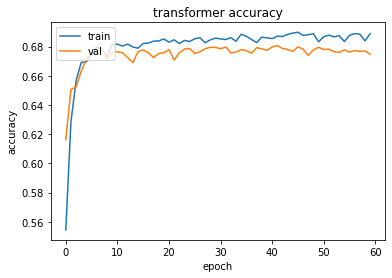


Test confusion matrix :
      0     1
0  1287   696
1   580  1437

Test Accuracy score:  0.681
Test AUC score:  0.7470189721207358
Test Precision score:  0.6736990154711674
Test Recall score:  0.7124442240951909
Test Specificity score:  0.649016641452345
Test F1_score:  0.6925301204819277 


Test confusion matrix :
      0     1
0  1275   708
1   759  1258

Test Accuracy score:  0.63325
Test AUC score:  0.6889605273981044
Test Precision score:  0.6398779247202442
Test Recall score:  0.6236985622211205
Test Specificity score:  0.642965204236006
Test F1_score:  0.6316846598041679 



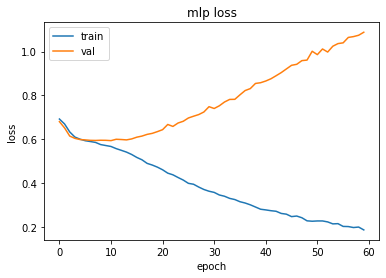

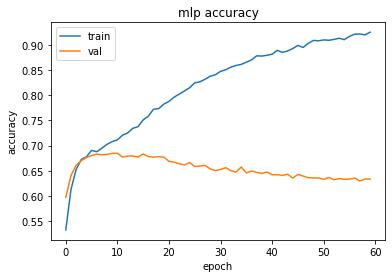


Test confusion matrix :
      0     1
0  1299   710
1   537  1454

Test Accuracy score:  0.68825
Test AUC score:  0.7489154155371647
Test Precision score:  0.6719038817005545
Test Recall score:  0.730286288297338
Test Specificity score:  0.646590343454455
Test F1_score:  0.6998796630565584 


Test confusion matrix :
      0     1
0  1260   749
1   784  1207

Test Accuracy score:  0.61675
Test AUC score:  0.6640289465861684
Test Precision score:  0.6170756646216768
Test Recall score:  0.6062280261175289
Test Specificity score:  0.627177700348432
Test F1_score:  0.6116037496833037 



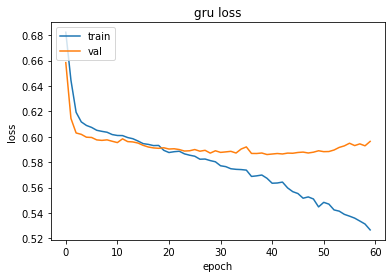

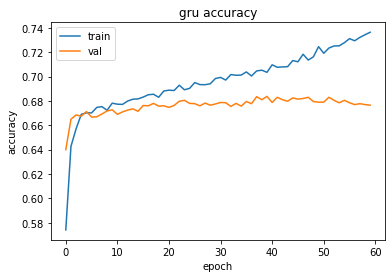


Test confusion matrix :
      0     1
0  1332   677
1   546  1445

Test Accuracy score:  0.69425
Test AUC score:  0.7565298197288496
Test Precision score:  0.680961357210179
Test Recall score:  0.7257659467604219
Test Specificity score:  0.6630164260826281
Test F1_score:  0.7026501337223439 


Test confusion matrix :
      0     1
0  1316   693
1   813  1178

Test Accuracy score:  0.6235
Test AUC score:  0.6744466575448153
Test Precision score:  0.6296098343132015
Test Recall score:  0.5916624811652436
Test Specificity score:  0.6550522648083623
Test F1_score:  0.6100466079751423 



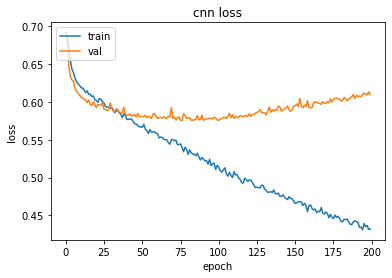

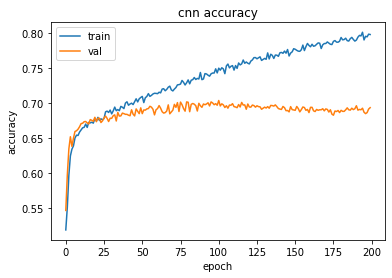


Test confusion matrix :
      0     1
0  1328   681
1   517  1474

Test Accuracy score:  0.7005
Test AUC score:  0.7757184582987805
Test Precision score:  0.6839907192575406
Test Recall score:  0.7403314917127072
Test Specificity score:  0.6610253857640617
Test F1_score:  0.7110467920887602 


Test confusion matrix :
      0     1
0  1319   690
1   856  1135

Test Accuracy score:  0.6135
Test AUC score:  0.6587412145095939
Test Precision score:  0.6219178082191781
Test Recall score:  0.5700652938222
Test Specificity score:  0.6565455450472872
Test F1_score:  0.5948637316561846 



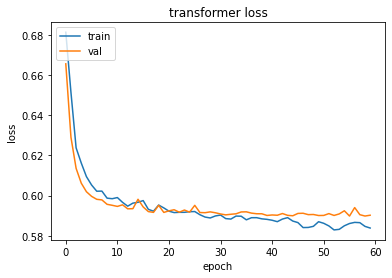

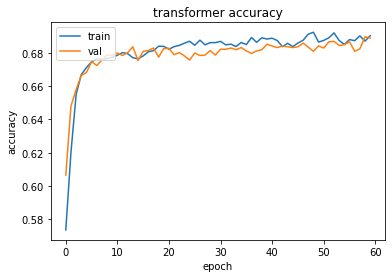


Test confusion matrix :
      0     1
0  1308   701
1   525  1466

Test Accuracy score:  0.6935
Test AUC score:  0.7532665036466988
Test Precision score:  0.6765113059529303
Test Recall score:  0.7363134103465595
Test Specificity score:  0.6510701841712294
Test F1_score:  0.7051467051467051 


Test confusion matrix :
      0     1
0  1279   730
1   773  1218

Test Accuracy score:  0.62425
Test AUC score:  0.6724721175603805
Test Precision score:  0.6252566735112937
Test Recall score:  0.6117528879959819
Test Specificity score:  0.6366351418616227
Test F1_score:  0.6184310738766184 



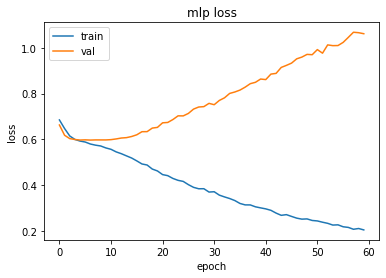

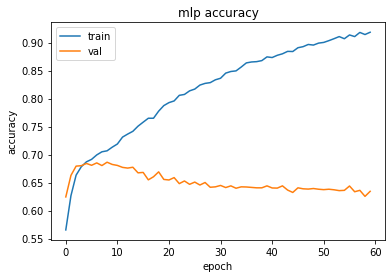


Test confusion matrix :
      0     1
0  1322   678
1   616  1384

Test Accuracy score:  0.6765
Test AUC score:  0.7324247500000001
Test Precision score:  0.6711930164888458
Test Recall score:  0.692
Test Specificity score:  0.661
Test F1_score:  0.6814377154111275 


Test confusion matrix :
      0     1
0  1278   722
1   862  1138

Test Accuracy score:  0.604
Test AUC score:  0.653096125
Test Precision score:  0.6118279569892473
Test Recall score:  0.569
Test Specificity score:  0.639
Test F1_score:  0.5896373056994818 



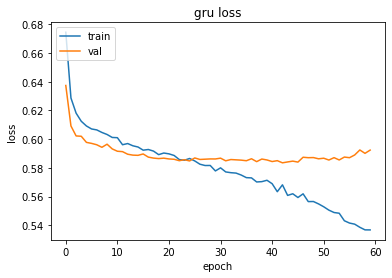

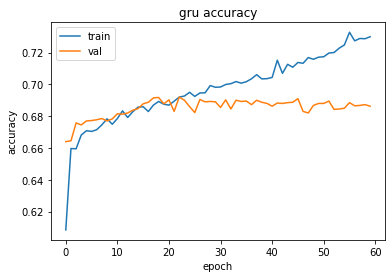


Test confusion matrix :
      0     1
0  1336   664
1   594  1406

Test Accuracy score:  0.6855
Test AUC score:  0.74810625
Test Precision score:  0.6792270531400966
Test Recall score:  0.703
Test Specificity score:  0.668
Test F1_score:  0.6909090909090908 


Test confusion matrix :
      0     1
0  1299   701
1   825  1175

Test Accuracy score:  0.6185
Test AUC score:  0.665845
Test Precision score:  0.6263326226012793
Test Recall score:  0.5875
Test Specificity score:  0.6495
Test F1_score:  0.6062951496388028 



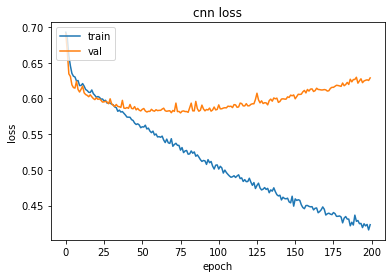

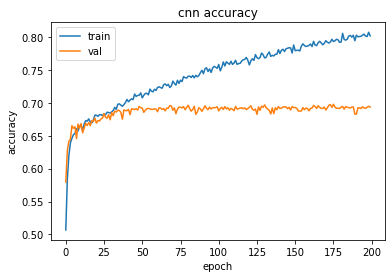


Test confusion matrix :
      0     1
0  1373   627
1   624  1376

Test Accuracy score:  0.68725
Test AUC score:  0.75762925
Test Precision score:  0.6869695456814778
Test Recall score:  0.688
Test Specificity score:  0.6865
Test F1_score:  0.6874843867099675 


Test confusion matrix :
      0     1
0  1298   702
1   982  1018

Test Accuracy score:  0.579
Test AUC score:  0.6299792500000001
Test Precision score:  0.5918604651162791
Test Recall score:  0.509
Test Specificity score:  0.649
Test F1_score:  0.5473118279569892 



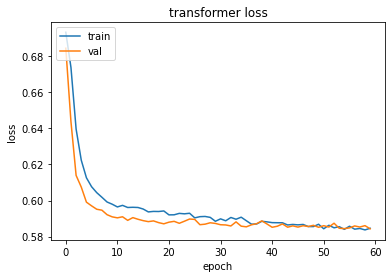

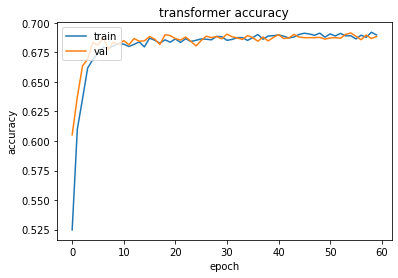


Test confusion matrix :
      0     1
0  1326   674
1   606  1394

Test Accuracy score:  0.68
Test AUC score:  0.7441378750000001
Test Precision score:  0.6740812379110251
Test Recall score:  0.697
Test Specificity score:  0.663
Test F1_score:  0.6853490658800393 


Test confusion matrix :
      0     1
0  1288   712
1   820  1180

Test Accuracy score:  0.617
Test AUC score:  0.6685995000000001
Test Precision score:  0.6236786469344608
Test Recall score:  0.59
Test Specificity score:  0.644
Test F1_score:  0.606372045220966 



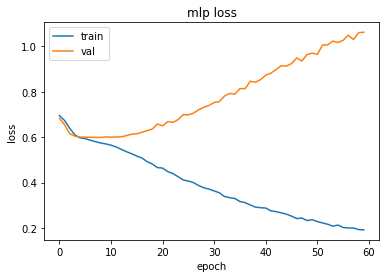

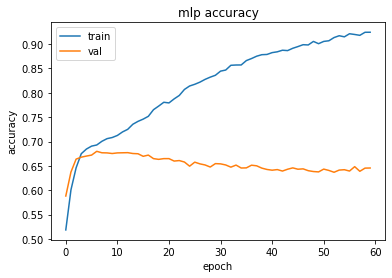


Test confusion matrix :
      0     1
0  1348   737
1   580  1335

Test Accuracy score:  0.67075
Test AUC score:  0.7371955594793095
Test Precision score:  0.6443050193050193
Test Recall score:  0.6971279373368147
Test Specificity score:  0.6465227817745803
Test F1_score:  0.6696764484574869 


Test confusion matrix :
      0     1
0  1335   750
1   774  1141

Test Accuracy score:  0.619
Test AUC score:  0.6606257552704572
Test Precision score:  0.6033844526705446
Test Recall score:  0.595822454308094
Test Specificity score:  0.6402877697841727
Test F1_score:  0.5995796111403048 



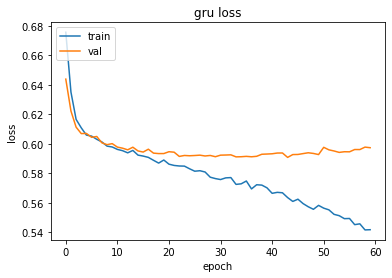

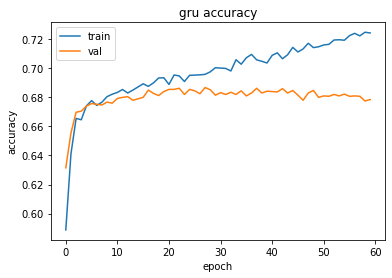


Test confusion matrix :
      0     1
0  1338   747
1   535  1380

Test Accuracy score:  0.6795
Test AUC score:  0.747231937687448
Test Precision score:  0.6488011283497884
Test Recall score:  0.720626631853786
Test Specificity score:  0.641726618705036
Test F1_score:  0.6828302820385949 


Test confusion matrix :
      0     1
0  1309   776
1   731  1184

Test Accuracy score:  0.62325
Test AUC score:  0.6707351403472522
Test Precision score:  0.6040816326530613
Test Recall score:  0.6182767624020887
Test Specificity score:  0.6278177458033574
Test F1_score:  0.6110967741935484 



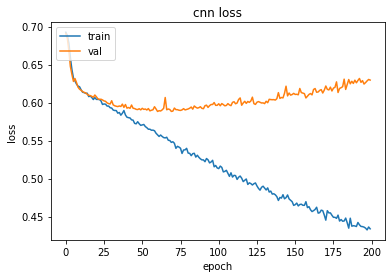

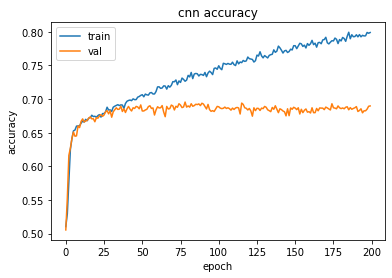


Test confusion matrix :
      0     1
0  1380   705
1   566  1349

Test Accuracy score:  0.68225
Test AUC score:  0.7522421123153696
Test Precision score:  0.6567672833495618
Test Recall score:  0.7044386422976502
Test Specificity score:  0.6618705035971223
Test F1_score:  0.6797682035777274 


Test confusion matrix :
      0     1
0  1362   723
1   817  1098

Test Accuracy score:  0.615
Test AUC score:  0.6590727000644915
Test Precision score:  0.6029654036243822
Test Recall score:  0.5733681462140993
Test Specificity score:  0.6532374100719425
Test F1_score:  0.58779443254818 



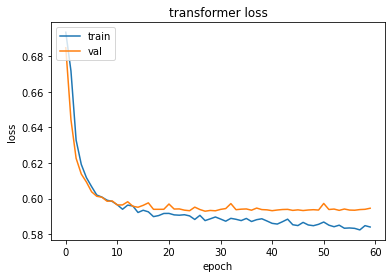

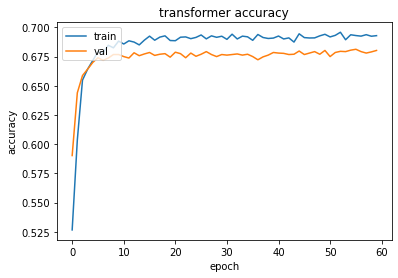


Test confusion matrix :
      0     1
0  1329   756
1   566  1349

Test Accuracy score:  0.6695
Test AUC score:  0.7420726186674681
Test Precision score:  0.640855106888361
Test Recall score:  0.7044386422976502
Test Specificity score:  0.637410071942446
Test F1_score:  0.6711442786069651 


Test confusion matrix :
      0     1
0  1319   766
1   741  1174

Test Accuracy score:  0.62325
Test AUC score:  0.6722690359461778
Test Precision score:  0.6051546391752577
Test Recall score:  0.6130548302872063
Test Specificity score:  0.6326139088729017
Test F1_score:  0.6090791180285344 



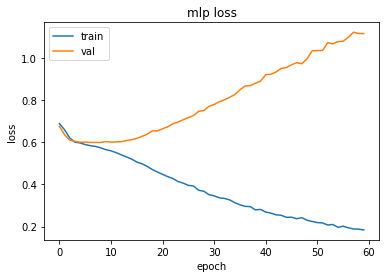

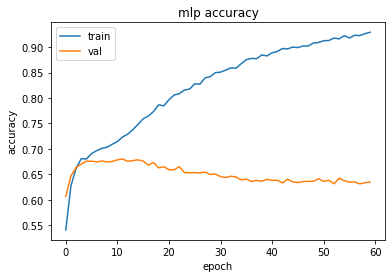


Test confusion matrix :
      0     1
0  1339   638
1   600  1423

Test Accuracy score:  0.6905
Test AUC score:  0.7519670726453573
Test Precision score:  0.6904415332362931
Test Recall score:  0.7034107760751359
Test Specificity score:  0.6772888214466363
Test F1_score:  0.6968658178256611 


Test confusion matrix :
      0     1
0  1315   662
1   853  1170

Test Accuracy score:  0.62125
Test AUC score:  0.6748547495406267
Test Precision score:  0.638646288209607
Test Recall score:  0.5783489866534849
Test Specificity score:  0.6651492159838138
Test F1_score:  0.6070038910505836 



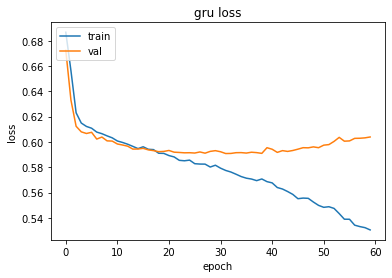

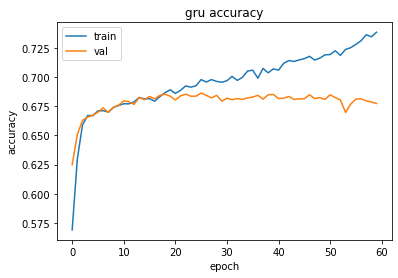


Test confusion matrix :
      0     1
0  1322   655
1   594  1429

Test Accuracy score:  0.68775
Test AUC score:  0.7549818463491798
Test Precision score:  0.685700575815739
Test Recall score:  0.7063766683143846
Test Specificity score:  0.6686899342438037
Test F1_score:  0.6958850742634526 


Test confusion matrix :
      0     1
0  1302   675
1   825  1198

Test Accuracy score:  0.625
Test AUC score:  0.6874291625067415
Test Precision score:  0.6396155899626268
Test Recall score:  0.5921898171033119
Test Specificity score:  0.6585735963581184
Test F1_score:  0.6149897330595482 



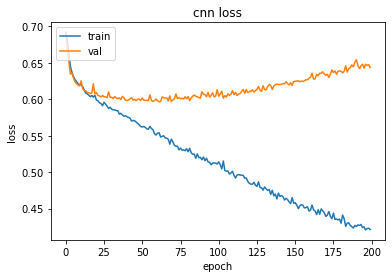

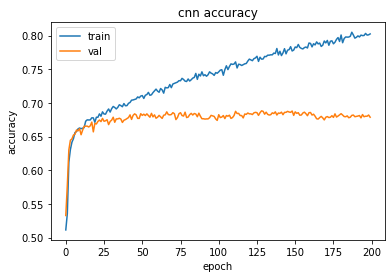


Test confusion matrix :
      0     1
0  1301   676
1   521  1502

Test Accuracy score:  0.70075
Test AUC score:  0.7626171061122834
Test Precision score:  0.689623507805326
Test Recall score:  0.7424616905585764
Test Specificity score:  0.6580677794638341
Test F1_score:  0.7150678409902403 


Test confusion matrix :
      0     1
0  1255   722
1   824  1199

Test Accuracy score:  0.6135
Test AUC score:  0.6577327351542241
Test Precision score:  0.6241540864133264
Test Recall score:  0.59268413247652
Test Specificity score:  0.6348002023267577
Test F1_score:  0.6080121703853955 



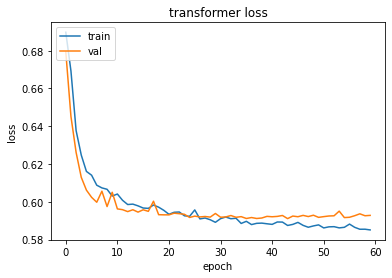

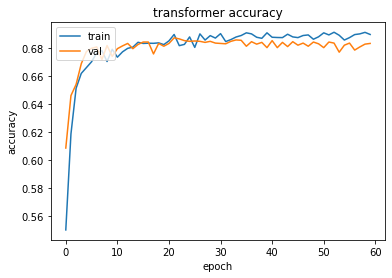


Test confusion matrix :
      0     1
0  1352   625
1   646  1377

Test Accuracy score:  0.68225
Test AUC score:  0.7492202093726896
Test Precision score:  0.6878121878121878
Test Recall score:  0.680672268907563
Test Specificity score:  0.6838644410723318
Test F1_score:  0.684223602484472 


Test confusion matrix :
      0     1
0  1343   634
1   886  1137

Test Accuracy score:  0.62
Test AUC score:  0.6826147758041
Test Precision score:  0.6420101637492942
Test Recall score:  0.5620365793376174
Test Specificity score:  0.6793120890237734
Test F1_score:  0.5993674222456511 



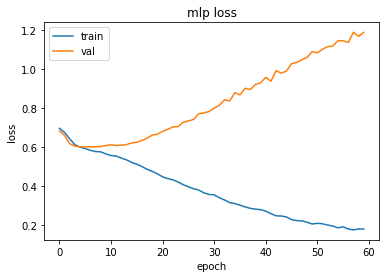

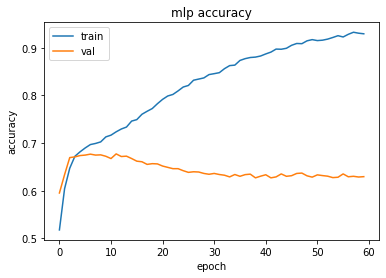


Test confusion matrix :
      0     1
0  1372   687
1   576  1365

Test Accuracy score:  0.68425
Test AUC score:  0.7458906113044877
Test Precision score:  0.6652046783625731
Test Recall score:  0.7032457496136012
Test Specificity score:  0.6663428848955804
Test F1_score:  0.6836964688204358 


Test confusion matrix :
      0     1
0  1351   708
1   794  1147

Test Accuracy score:  0.6245
Test AUC score:  0.6697170712812824
Test Precision score:  0.6183288409703505
Test Recall score:  0.5909325090159712
Test Specificity score:  0.6561437591063624
Test F1_score:  0.6043203371970496 



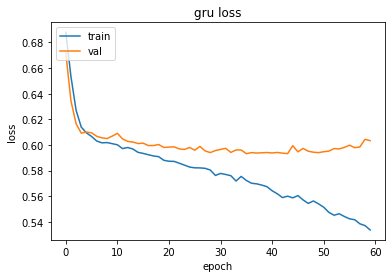

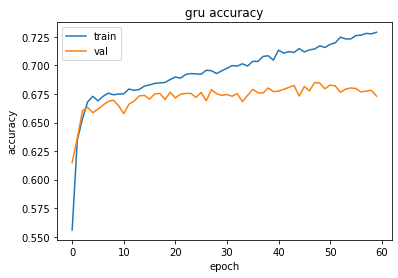


Test confusion matrix :
      0     1
0  1383   676
1   560  1381

Test Accuracy score:  0.691
Test AUC score:  0.7565754097503352
Test Precision score:  0.6713660670879922
Test Recall score:  0.7114889232354457
Test Specificity score:  0.6716852841185041
Test F1_score:  0.6908454227113556 


Test confusion matrix :
      0     1
0  1361   698
1   793  1148

Test Accuracy score:  0.62725
Test AUC score:  0.6778503993099995
Test Precision score:  0.6218851570964247
Test Recall score:  0.5914477073673364
Test Specificity score:  0.6610004856726567
Test F1_score:  0.6062846580406654 



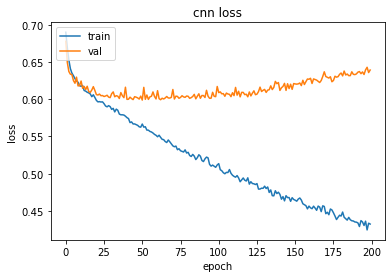

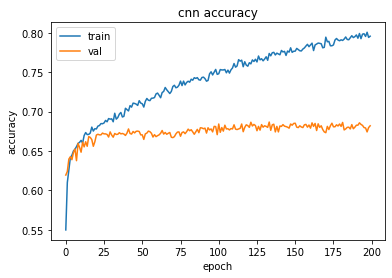


Test confusion matrix :
      0     1
0  1326   733
1   509  1432

Test Accuracy score:  0.6895
Test AUC score:  0.760784322556705
Test Precision score:  0.661431870669746
Test Recall score:  0.7377640391550747
Test Specificity score:  0.6440019426906265
Test F1_score:  0.697515830491963 


Test confusion matrix :
      0     1
0  1334   725
1   765  1176

Test Accuracy score:  0.6275
Test AUC score:  0.6714265589629375
Test Precision score:  0.6186217780115728
Test Recall score:  0.6058732612055642
Test Specificity score:  0.647887323943662
Test F1_score:  0.6121811556480999 



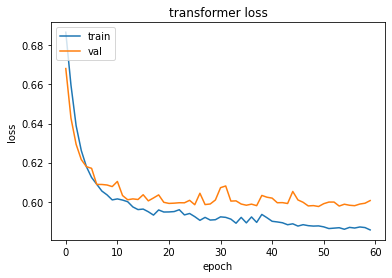

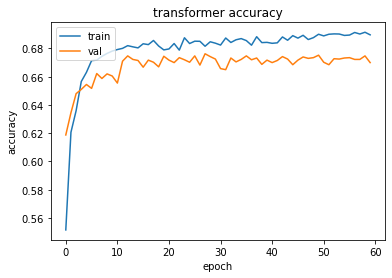


Test confusion matrix :
      0     1
0  1372   687
1   579  1362

Test Accuracy score:  0.6835
Test AUC score:  0.7440362475444255
Test Precision score:  0.664714494875549
Test Recall score:  0.7017001545595054
Test Specificity score:  0.6663428848955804
Test F1_score:  0.6827067669172933 


Test confusion matrix :
      0     1
0  1348   711
1   789  1152

Test Accuracy score:  0.625
Test AUC score:  0.673023949091697
Test Precision score:  0.6183574879227053
Test Recall score:  0.5935085007727975
Test Specificity score:  0.6546867411364741
Test F1_score:  0.6056782334384858 



In [26]:
round_df = pd.DataFrame(columns=["model","round","shuffle","acc","auc","pre","recall","f1"])
epoch_seed = 0
for r in [6,5,4,3]:
    df = getdata_random(f'../data/R{r}_1.out_N_unique', False)
    for itr in range(10):
        seed_num = itr
        reset_seed(seed_num)
        X_train,X_test,Y_train,Y_test = data_split(df,seed = itr)
        X_valid,X_test,Y_valid,Y_test=train_test_split(X_test,Y_test,test_size=0.5,random_state=seed_num)
        X_test_shuffle = np.array([np.random.permutation(seq) for seq in X_test])
    
        datas = [X_train,Y_train,X_valid,Y_valid,X_test,Y_test,X_test_shuffle]

        reset_seed(seed_num)
        model ,round_df,_,_ = gru_train(datas,round_df,60,r,seed = seed_num )
        
        reset_seed(seed_num)
        model ,round_df,_,_ = cnn_train(datas,round_df,200,r,seed = seed_num )
        
        reset_seed(seed_num)
        model ,round_df,_,_ = transformer_train(datas,round_df,60,r,seed = seed_num )

# Time constant experiment

### Time constant data load

In [50]:
time_df = pd.read_csv('../data/time_constant_df.csv')
print(time_df)
time_x = preprocessing(time_df)
time_y = time_df.ans
time_y = np.array(time_df.ans)
time_y = keras.utils.np_utils.to_categorical(time_y)

                               seq    time    ans
0   ATAACGCTGTTAGGGCACTCGGCCAGGGGG   118.0   True
1   CTCCATGGCATCGAGATATCGCGGAACGCA    28.5  False
2   CACTCAACAGCTCTCACTCACCAACAACAT    29.4  False
3   AGATTTAAATCTGATATCTTAAGGGGCAGT    14.0  False
4   TGATGTGTAAGGACCACGTTAGATCCCGGC    75.2  False
..                             ...     ...    ...
67  GGGTCGTCGGCGGCACCATCATCCGATCAC  1000.0   True
68  TCGTTGACGGTGGTCGCCCCATCATAGGCC   959.5   True
69  CGTATTGCAGGTGGTCTCCCTATTAGCAAA   413.8   True
70  TGGTCGCACCGGCCTGTAGACGATTCGGCT   249.9   True
71  CCAGTTTCGGCTGGCTCGGCCAATCTTTTA   873.2   True

[72 rows x 3 columns]


In [67]:
def cnn_round6_gen():
    reset_seed(seed_num)
    copy_model = tf.keras.models.load_model(f'../pre_trained_models/R6_cnn_{itr}.h5')
    new_model = tf.keras.Sequential()

    for layer in copy_model.layers[:-6]:
        new_model.add(layer)
    new_model.add(tf.keras.layers.Conv1D(16, 3,strides=1, activation='relu', name="conv1d_new1"))
    new_model.add(tf.keras.layers.Dropout(0.1, name="drop_new1"))
    new_model.add(tf.keras.layers.Conv1D(8, 3,strides=1, activation='relu', name="conv1d_new2"))
    new_model.add(tf.keras.layers.Dropout(0.1, name="drop_new2"))
    new_model.add(tf.keras.layers.Flatten(name="flatten_new1"))
    new_model.add(tf.keras.layers.Dense(2, activation="softmax", name="dense_new1"))

    for i in range(len(new_model.layers)-6):
        new_model.layers[i].trainable = False
    for j in range(-6,0):
        new_model.layers[j].trainable = True

    new_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy','AUC'])
    return new_model

### Evaluation Function

In [69]:
def transfer_evaluation(pred, answer,verbose=0):
    prediction = np.round(pred)
    prediction2 = pred
    
    confusion = confusion_matrix(answer, prediction)
    
    
    acc = accuracy_score(answer, prediction)
    
    
    auc  = roc_auc_score(answer, prediction2)
    
    
    pre = precision_score(answer, prediction)
    

    recall = recall_score(answer, prediction)
    

    specificity = confusion[0,0]/(confusion[0,1]+confusion[0,0])
    

    f1 = f1_score(answer, prediction)
    
    
    
    if verbose == 1:
        print('\nTest confusion matrix :')
        print(pd.DataFrame(confusion))
        print('\nTest Accuracy score: ',acc)
        print('Test AUC score: ', auc)
        print('Test Precision score: ', pre)
        print('Test Recall score: ', recall)
        print('Test Specificity score: ', specificity)
        print('Test F1_score: ', f1,'\n')
    
    return acc , auc, pre, recall, specificity, f1

In [70]:
def fold_predict(model,X,Y):
    prediction = model.predict(X,verbose = 0)
    proba = prediction.T[1].T
    answer = np.argmax(Y, axis=1)
    return proba, answer

### Model transfer

In [71]:
def cnn_transfer(data,itr,record_df,answer_df):
    reset_seed(seed_num)
    skfold = KFold(n_splits=4,shuffle = True,random_state=seed_num)
    ys = []
    preds = []
    preds_s = []
    fold_num = 0
    
    
    for train_i,test_i in skfold.split(data[0],data[1]):
        model_save = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'time_cnn_{itr}_{fold_num}.h5',
        save_weights_only=False,
        save_best_only=False,
        save_freq='epoch', 
        mode='auto',  
        verbose=0
        )


        X_train2, X_test2 = data[0][train_i], data[0][test_i]
        Y_train2, Y_test2 = data[1][train_i], data[1][test_i]
        X_test_s = np.array([np.random.permutation(seq) for seq in X_test2])
        cnn = cnn_round6_gen()

        history = cnn.fit(X_train2, Y_train2, batch_size = 6, epochs= 70, validation_data=(X_test2,Y_test2),callbacks=[model_save], verbose=0)

        make_plot('cnn(transfer-learning)',history)
        pred, answer = fold_predict(cnn,X_test2,Y_test2)
        ys += list(answer)
        preds += list(pred)
        pred, _ = fold_predict(cnn,X_test_s,Y_test2)
        preds_s += list(pred)
        
        fold_num += 1

    answer_df.loc[len(answer_df)] = ['cnn','answer',0,itr] + ys
    
    
    acc , auc, pre, recall, specificity, f1= transfer_evaluation(preds,ys)
    record_df.loc[len(record_df)] = ['cnn',0, acc , auc, pre, recall, f1]
    answer_df.loc[len(answer_df)] = ['cnn','pred',0,itr] + preds
    
    acc , auc, pre, recall, specificity, f1= transfer_evaluation(preds_s,ys)
    record_df.loc[len(record_df)] = ['cnn',1, acc , auc, pre, recall, f1]
    answer_df.loc[len(answer_df)] = ['cnn','pred',1,itr] + preds_s
    
    
    return cnn, record_df,answer_df,np.array(ys) ,np.array(preds),np.array(preds_s)
        #         df.loc[len(df)] = ['transformer',r,0, acc , auc, pre, recall, f1]

### Time constant Result

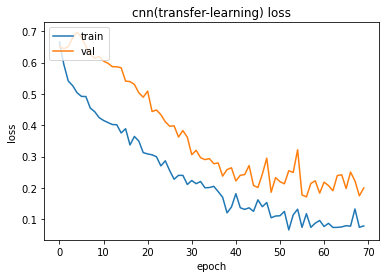

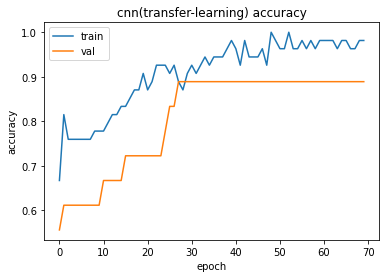

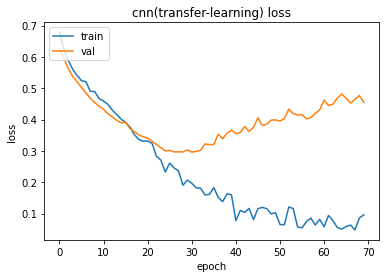

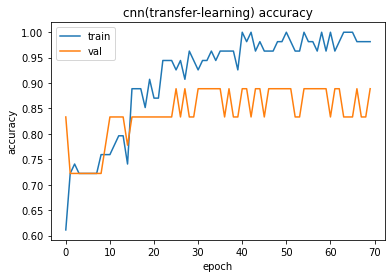

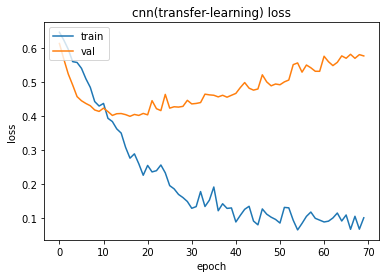

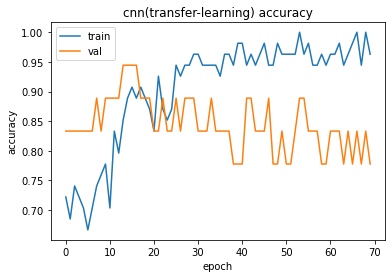

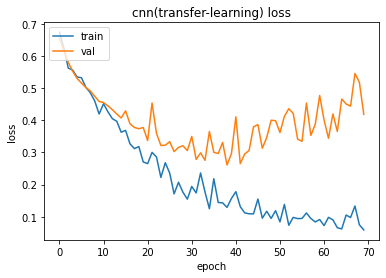

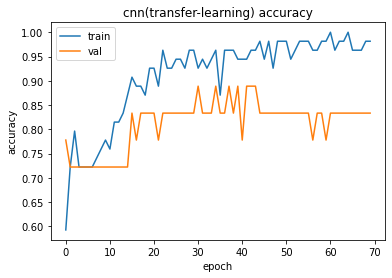

  model  shuffle       acc       auc       pre  recall        f1
0   cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1   cnn        1  0.805556  0.862500  0.714286    0.50  0.588235


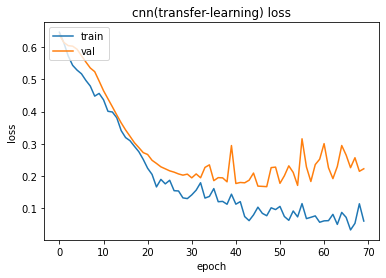

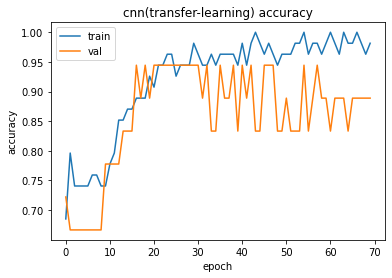

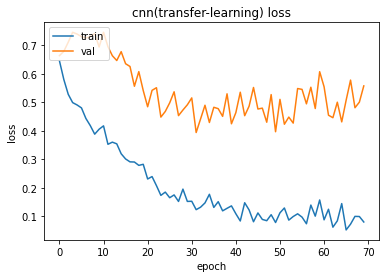

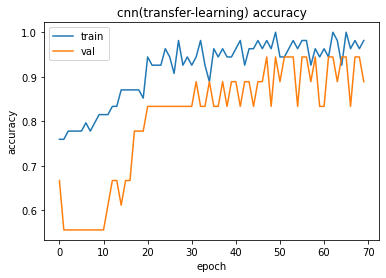

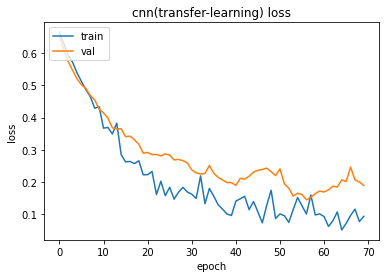

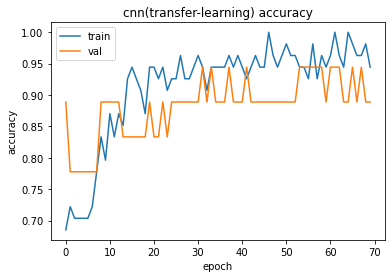

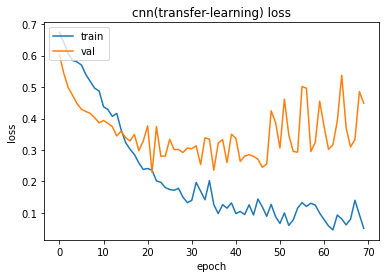

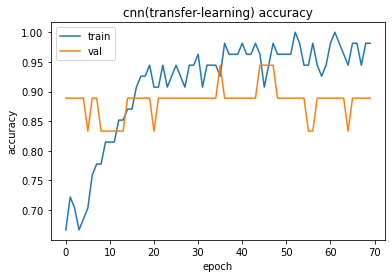

  model  shuffle       acc       auc       pre  recall        f1
0   cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1   cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2   cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3   cnn        1  0.763889  0.766346  0.600000    0.45  0.514286


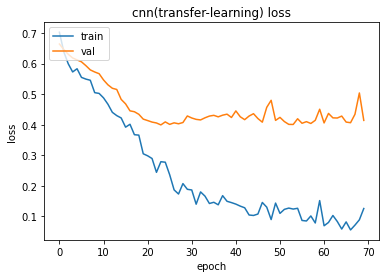

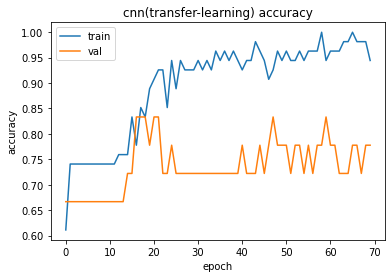

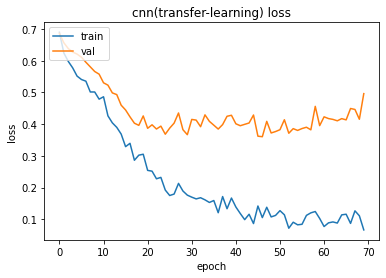

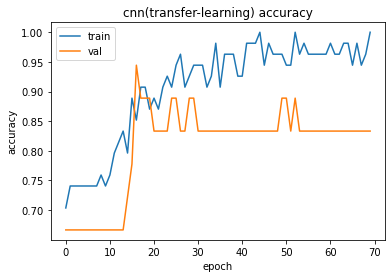

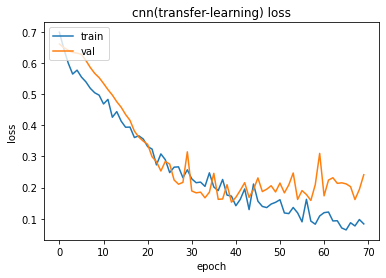

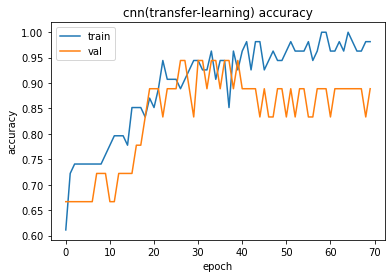

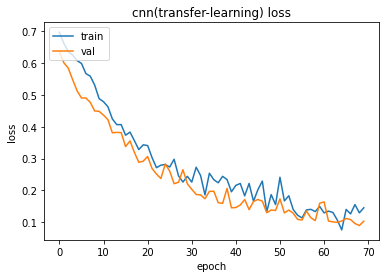

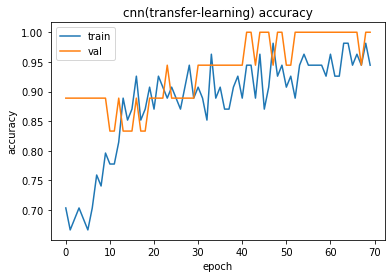

  model  shuffle       acc       auc       pre  recall        f1
0   cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1   cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2   cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3   cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4   cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5   cnn        1  0.791667  0.875000  0.631579    0.60  0.615385


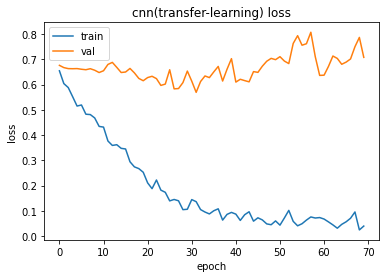

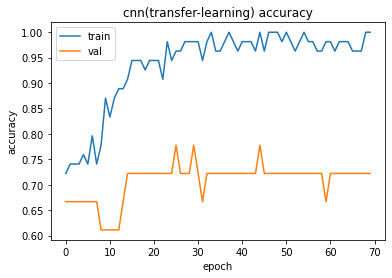

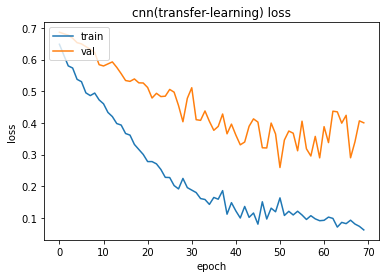

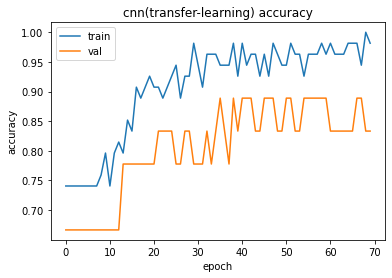

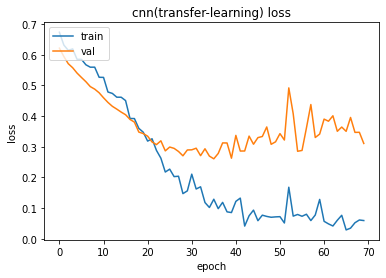

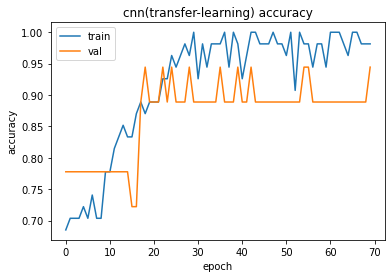

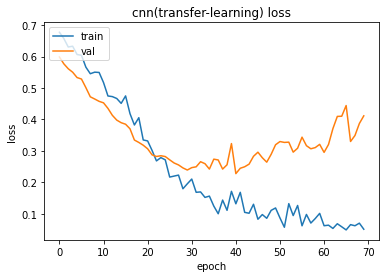

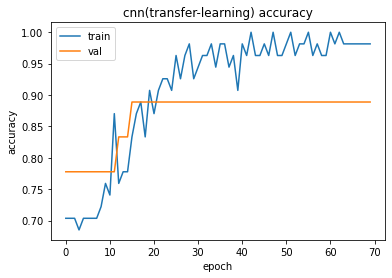

  model  shuffle       acc       auc       pre  recall        f1
0   cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1   cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2   cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3   cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4   cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5   cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6   cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7   cnn        1  0.708333  0.701923  0.444444    0.20  0.275862


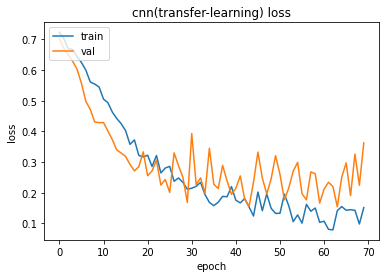

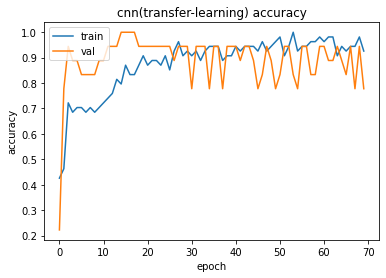

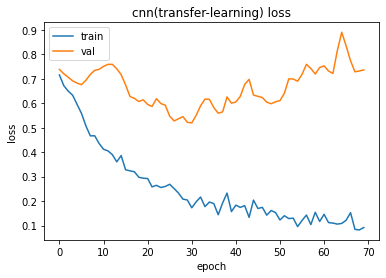

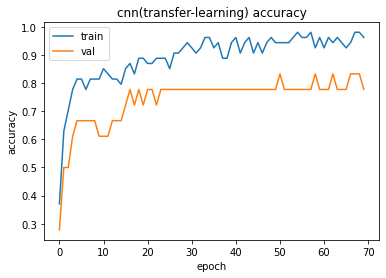

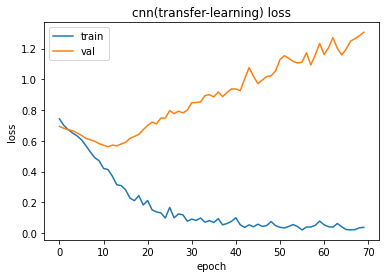

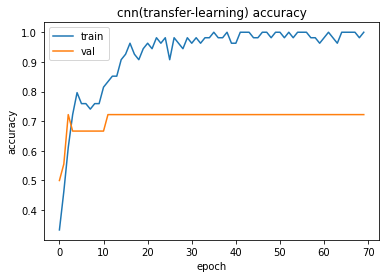

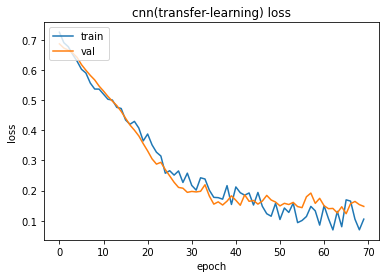

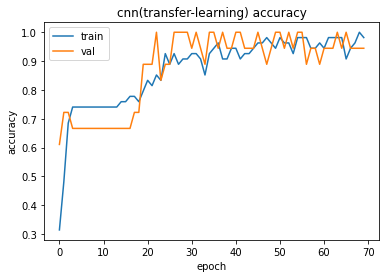

  model  shuffle       acc       auc       pre  recall        f1
0   cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1   cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2   cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3   cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4   cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5   cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6   cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7   cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8   cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9   cnn        1  0.805556  0.810577  0.687500    0.55  0.611111


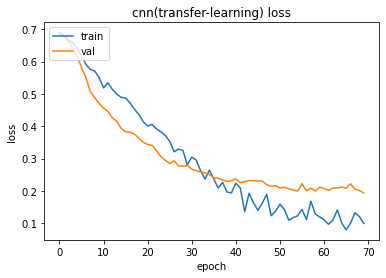

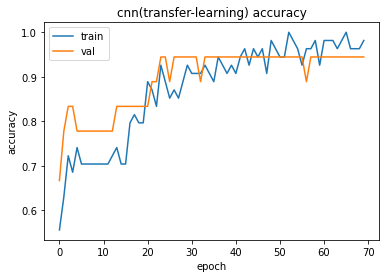

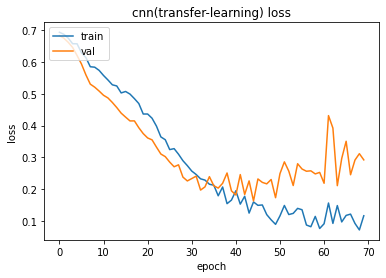

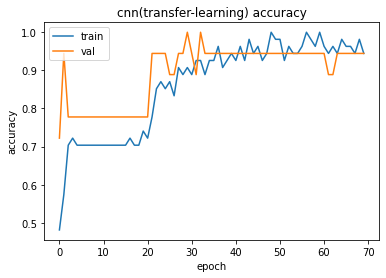

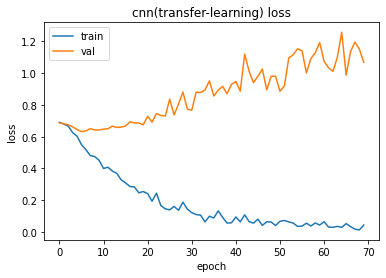

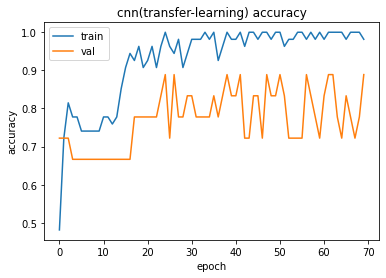

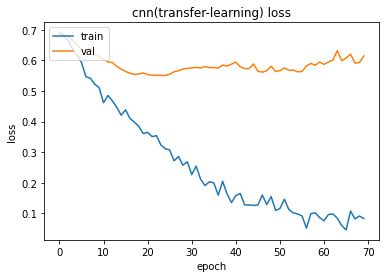

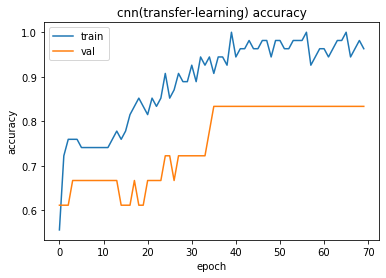

   model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667


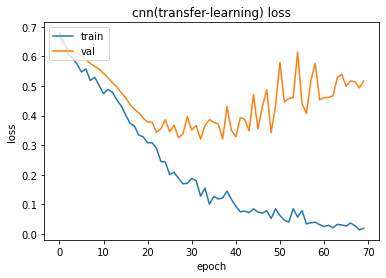

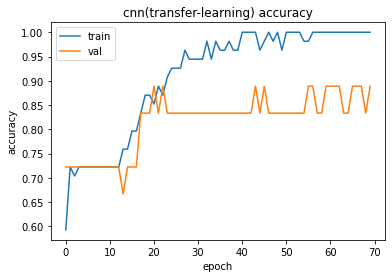

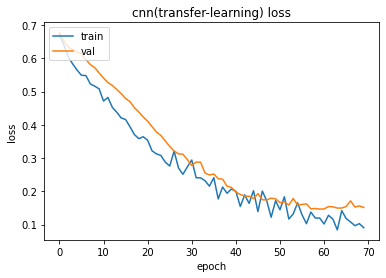

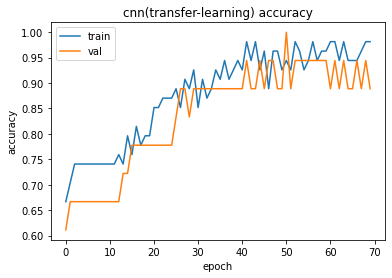

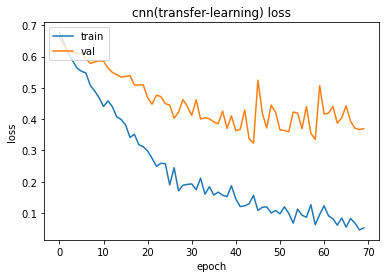

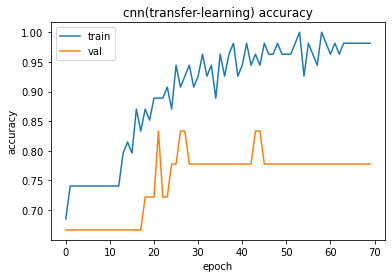

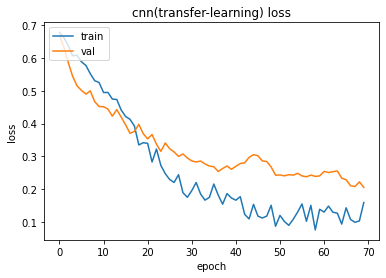

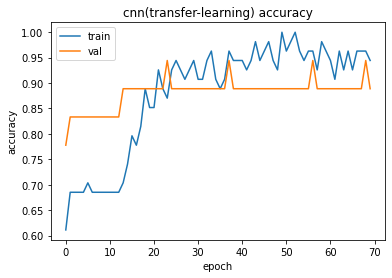

   model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667
12   cnn        0  0.861111  0.950000  0.777778    0.70  0.736842
13   cnn        1  0.777778  0.821154  0.700000    0.35  0.466667


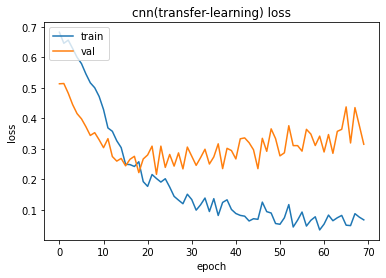

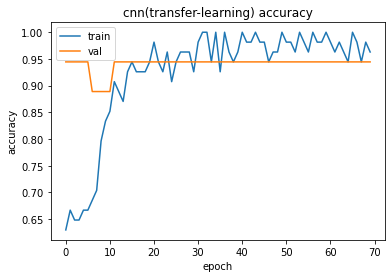

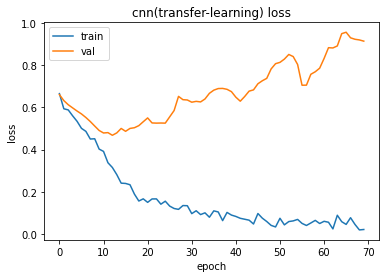

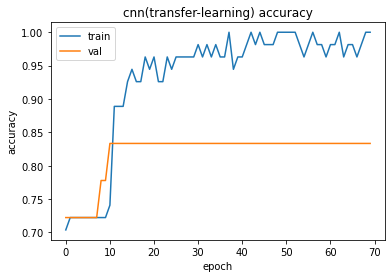

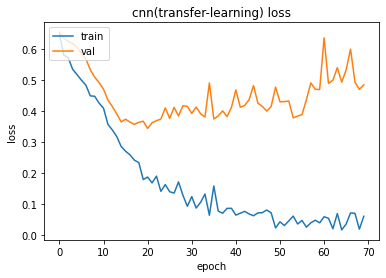

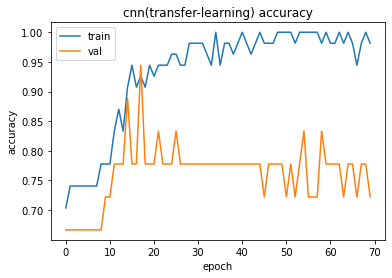

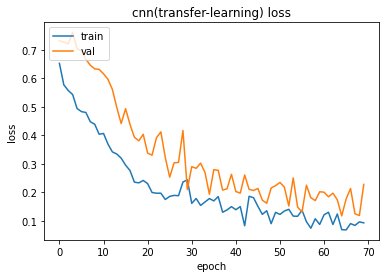

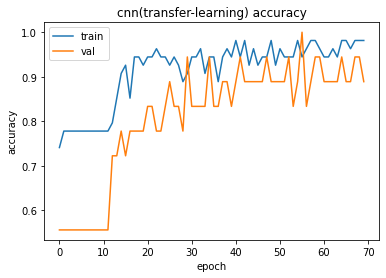

   model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667
12   cnn        0  0.861111  0.950000  0.777778    0.70  0.736842
13   cnn        1  0.777778  0.821154  0.700000    0.35  0.466667
14   cnn  

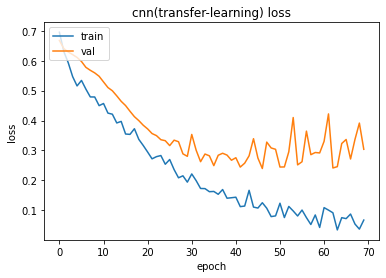

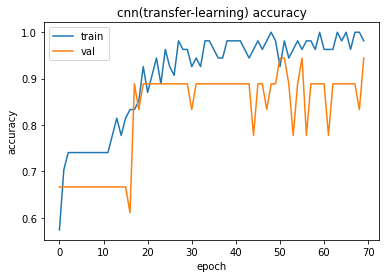

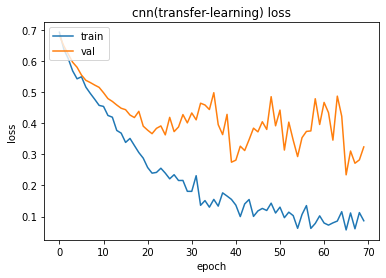

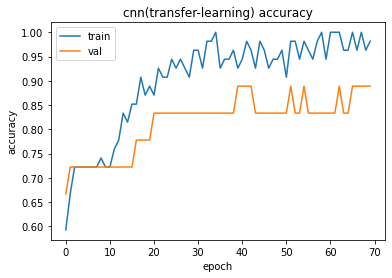

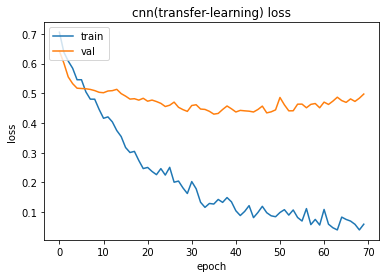

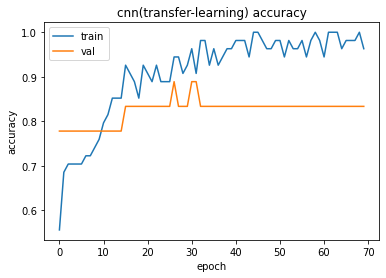

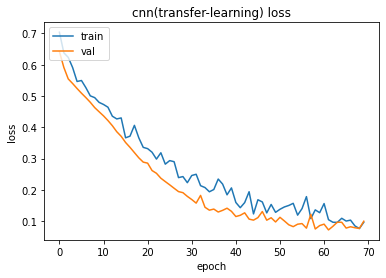

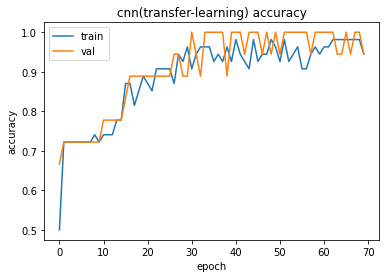

   model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667
12   cnn        0  0.861111  0.950000  0.777778    0.70  0.736842
13   cnn        1  0.777778  0.821154  0.700000    0.35  0.466667
14   cnn  

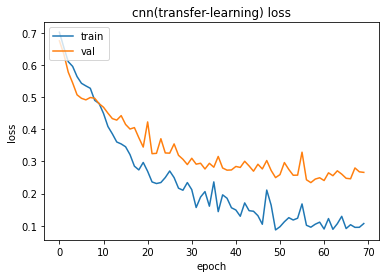

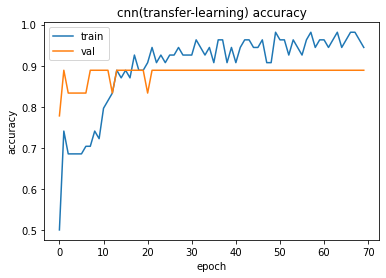

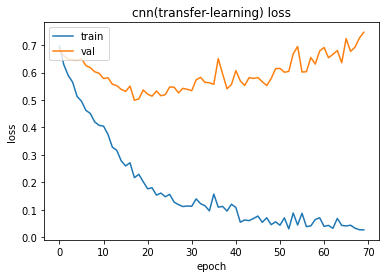

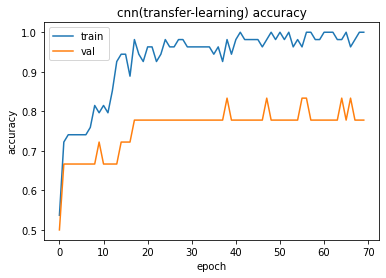

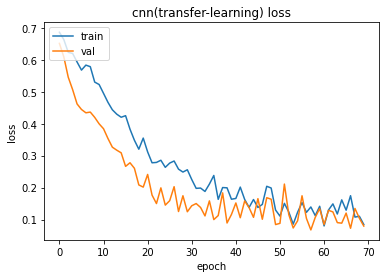

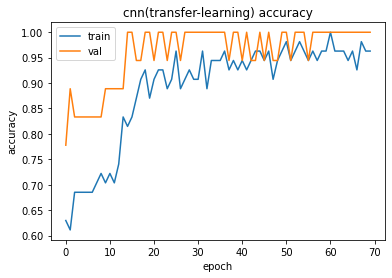

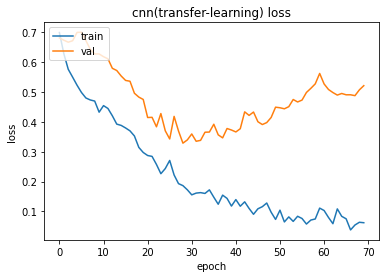

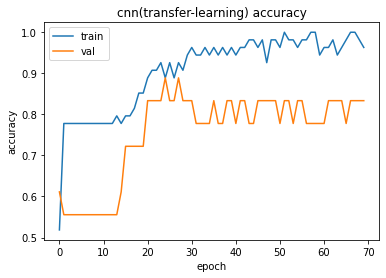

   model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667
12   cnn        0  0.861111  0.950000  0.777778    0.70  0.736842
13   cnn        1  0.777778  0.821154  0.700000    0.35  0.466667
14   cnn  

In [74]:
time_constant_df = pd.DataFrame(columns=["model","shuffle","acc","auc","pre","recall","f1"])
roc_df = pd.DataFrame(columns=['model','label','shuffle','itr']+[i for i in range(72)])
epoch_seed = 0
for itr in range(10):
    seed_num = itr
    reset_seed(seed_num)
    _,time_constant_df,roc_df, ans,cnn_pred,cnn_pred_s = cnn_transfer([time_x,time_y],itr,time_constant_df,roc_df)
    print(time_constant_df)

In [75]:
time_constant_df

model  shuffle       acc       auc       pre  recall        f1
0    cnn        0  0.847222  0.908654  0.714286    0.75  0.731707
1    cnn        1  0.805556  0.862500  0.714286    0.50  0.588235
2    cnn        0  0.888889  0.923077  0.772727    0.85  0.809524
3    cnn        1  0.763889  0.766346  0.600000    0.45  0.514286
4    cnn        0  0.875000  0.933654  0.761905    0.80  0.780488
5    cnn        1  0.791667  0.875000  0.631579    0.60  0.615385
6    cnn        0  0.847222  0.914423  0.800000    0.60  0.685714
7    cnn        1  0.708333  0.701923  0.444444    0.20  0.275862
8    cnn        0  0.805556  0.832692  0.650000    0.65  0.650000
9    cnn        1  0.805556  0.810577  0.687500    0.55  0.611111
10   cnn        0  0.902778  0.859615  0.882353    0.75  0.810811
11   cnn        1  0.833333  0.859615  0.750000    0.60  0.666667
12   cnn        0  0.861111  0.950000  0.777778    0.70  0.736842
13   cnn        1  0.777778  0.821154  0.700000    0.35  0.466667
14   cnn        0  0.847222  0.906731  0.764706    0.65  0.702703
15   cnn        1  0.722222  0.811538  0.500000    0.40  0.444444
16   cnn        0  0.902778  0.941346  0.882353    0.75  0.810811
17   cnn        1  0.833333  0.836538  0.722222    0.65  0.684211
18   cnn        0  0.875000  0.901923  0.789474    0.75  0.769231
19   cnn        1  0.791667  0.826923  0.692308    0.45  0.545455